출처: https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

# Titanic Top 4% with ensemble modeling

- **1 Introduction**
- **2 Load and check data**
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
- **3 Feature analysis**
    - 3.1 Numerical values
    - 3.2 Categorical values
- **4 Filling missing Values**
    - 4.1 Age
- **5 Feature engineering**
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- **6 Modeling**
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    - 6.2 Ensemble modeling
        - 6.2.1 Combining models
    - 6.3 Prediction
        - 6.3.1 Predict and Submit results

----------------

# 1. Introduction

이 스크립트는 세가지 주요 파트를 따릅니다:
- **Feature analysis**
- **Feature engineering**
- **Modeling**

In [1]:
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

-----

# 2. Load and check data

## 2.1 Load data

In [2]:
train = pd.read_csv("./titanic/train.csv")
print(len(train))
test = pd.read_csv("./titanic/test.csv")
print(len(test))
IDtest = test["PassengerId"]

891
418


## 2.2 이상치 탐지

In [3]:
def detect_outliers(df, n, features):
    """
    feature의 데이터 프레임 df를 가져와 n개 이상의 이상치를 포함하는 관측값에 해당하는
    인덱스 목록을 리턴. (Tukey Method)
    """
    
    outlier_indices = []
    
    # features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile ( 75%)
        Q3 = np.percentile(df[col], 75)
        # IQR
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        # feature column의 이상치에 대한 인덱스 리스트를 정의
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # outlier_indices에 outlier가 발견된 인덱스 목록을 추가
        outlier_indices.extend(outlier_list_col)
    
    # 이상치가 n개 보다 많은 인덱스 목록을 선택
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 2, ["Age","SibSp","Parch","Fare"])

이상치는 예측에 있어서 큰 영향을 미친다. (특히 regression 문제)

위에선 이상치를 탐지하기 위해 Tukey Method를 사용.

이상치는 (IQR +- outlier_step) 값의 바깥에 있는 feature을 가지는 행입니다. 계산을 위해서 numerical value를 가지는 feature만 사용했습니다. (Age, SibSp, Parch and Fare)

In [4]:
print(len(train.loc[outliers_to_drop]))
train.loc[outliers_to_drop]

10


PassengerId  Survived  Pclass                               Name     Sex  \
27            28         0       1     Fortune, Mr. Charles Alexander    male   
88            89         1       1         Fortune, Miss. Mabel Helen  female   
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
324          325         0       3           Sage, Mr. George John Jr    male   
341          342         1       1     Fortune, Miss. Alice Elizabeth  female   
792          793         0       3            Sage, Miss. Stella Anna  female   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch    Ticket    Fare        Cabin Embarked  
27   19.0      3      2     19950  263.00  C23 C25 C27        S  
88   23.0      3      2     19950  263.00  C23 C25 C27        S  
159   NaN      8      2  CA. 2343   69.55          NaN        S  
180   NaN      8      2  CA. 2343   69.55          NaN        S  
201   NaN      8      2  CA. 2343   69.55          NaN        S  
324   NaN      8      2  CA. 2343   69.55          NaN        S  
341  24.0      3      2     19950  263.00  C23 C25 C27        S  
792   NaN      8      2  CA. 2343   69.55          NaN        S  
846   NaN      8      2  CA. 2343   69.55          NaN        S  
863   NaN      8      2  CA. 2343   69.55          NaN        S

10개의 이상치를 발견. 28, 89 243 탑승객은 티켓 가격이 매우 높고, 다른 7명의 탑승객은 SibSP의 값이 매우 크다

In [5]:
# outliers 제거
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True) # drop=True는 인덱스 제거
print(len(train))

881


## 2.3 joining train and test set

동일하게 feature을 범주형으로 변환해주기 위해 train 데이터 세트와 test 데이터 세트를 합친다.

In [6]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [7]:
dataset.sample(5)

PassengerId  Survived  Pclass                                     Name  \
841           851       0.0       3  Andersson, Master. Sigvard Harald Elias   
455           463       0.0       1                        Gee, Mr. Arthur H   
343           351       0.0       3                   Odahl, Mr. Nils Martin   
1175         1186       NaN       3                Wittevrongel, Mr. Camille   
1031         1042       NaN       1    Earnshaw, Mrs. Boulton (Olive Potter)   

         Sex   Age  SibSp  Parch  Ticket     Fare Cabin Embarked  
841     male   4.0      4      2  347082  31.2750   NaN        S  
455     male  47.0      0      0  111320  38.5000   E63        S  
343     male  23.0      0      0    7267   9.2250   NaN        S  
1175    male  36.0      0      0  345771   9.5000   NaN        S  
1031  female  23.0      0      1   11767  83.1583   C54        C

## 2.4 check for null and missing values

In [8]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin feature는 결측치의 중요한 부분을 차지한다.

**Survived Feature의 결측치는 합친 테스트 데이터 세트에 해당한다(우리가 그 부분을 예측해야 하기 때문에 테스트 데이터 세트에는 Survived 칼럼의 값은 없음)**

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   881.000000  881.000000  881.000000  711.000000  881.000000   
mean    446.713961    0.385925    2.307605   29.731603    0.455165   
std     256.617021    0.487090    0.835055   14.547835    0.871571   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     226.000000    0.000000    2.000000   20.250000    0.000000   
50%     448.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.000000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    5.000000   

            Parch        Fare  
count  881.000000  881.000000  
mean     0.363224   31.121566  
std      0.791839   47.996249  
min      0.000000    0.000000  
25%      0.000000    7.895800  
50%      0.000000   14.454200  
75%      0.000000   30.500000  
max      6.000000  512.329200

------

## 3. Feature analysis
### 3.1 Numerical values

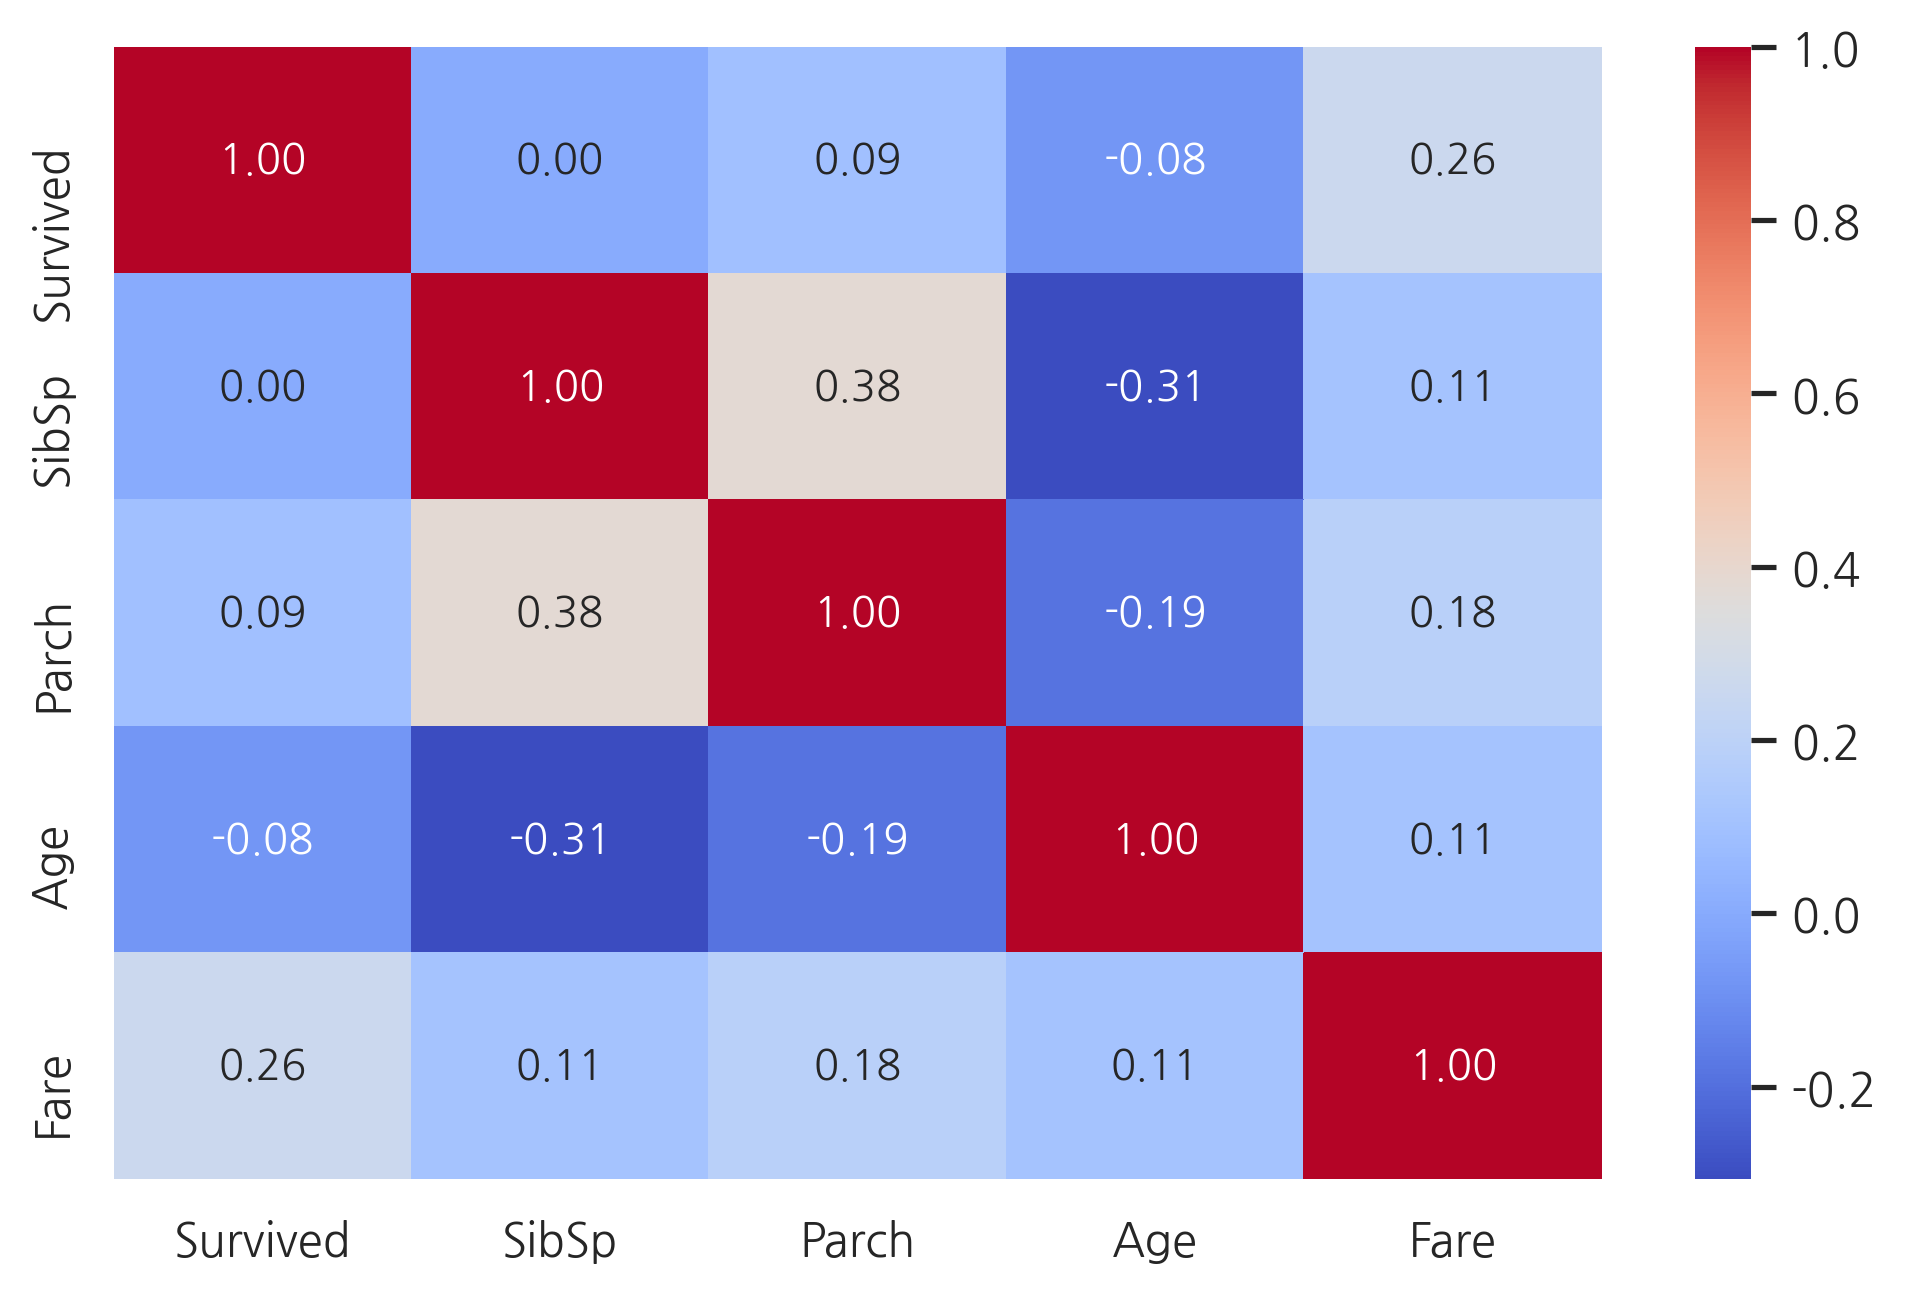

In [13]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                annot=True, fmt=".2f", cmap="coolwarm")

오직 Fare feature만 생존확률과 유의미한 상관관계를 가진다.

이러한 결과가 다른 feature들은 유용하지 않다는 것을 의미하진 않는다. 이러한 feature들의 하위 집합이 생존과 상관관계가 있을 수 있다. 이러한 것들을 정의하기 위해 이러한 feature들을 더욱 상세히 살펴봐야 한다.

#### SibSP

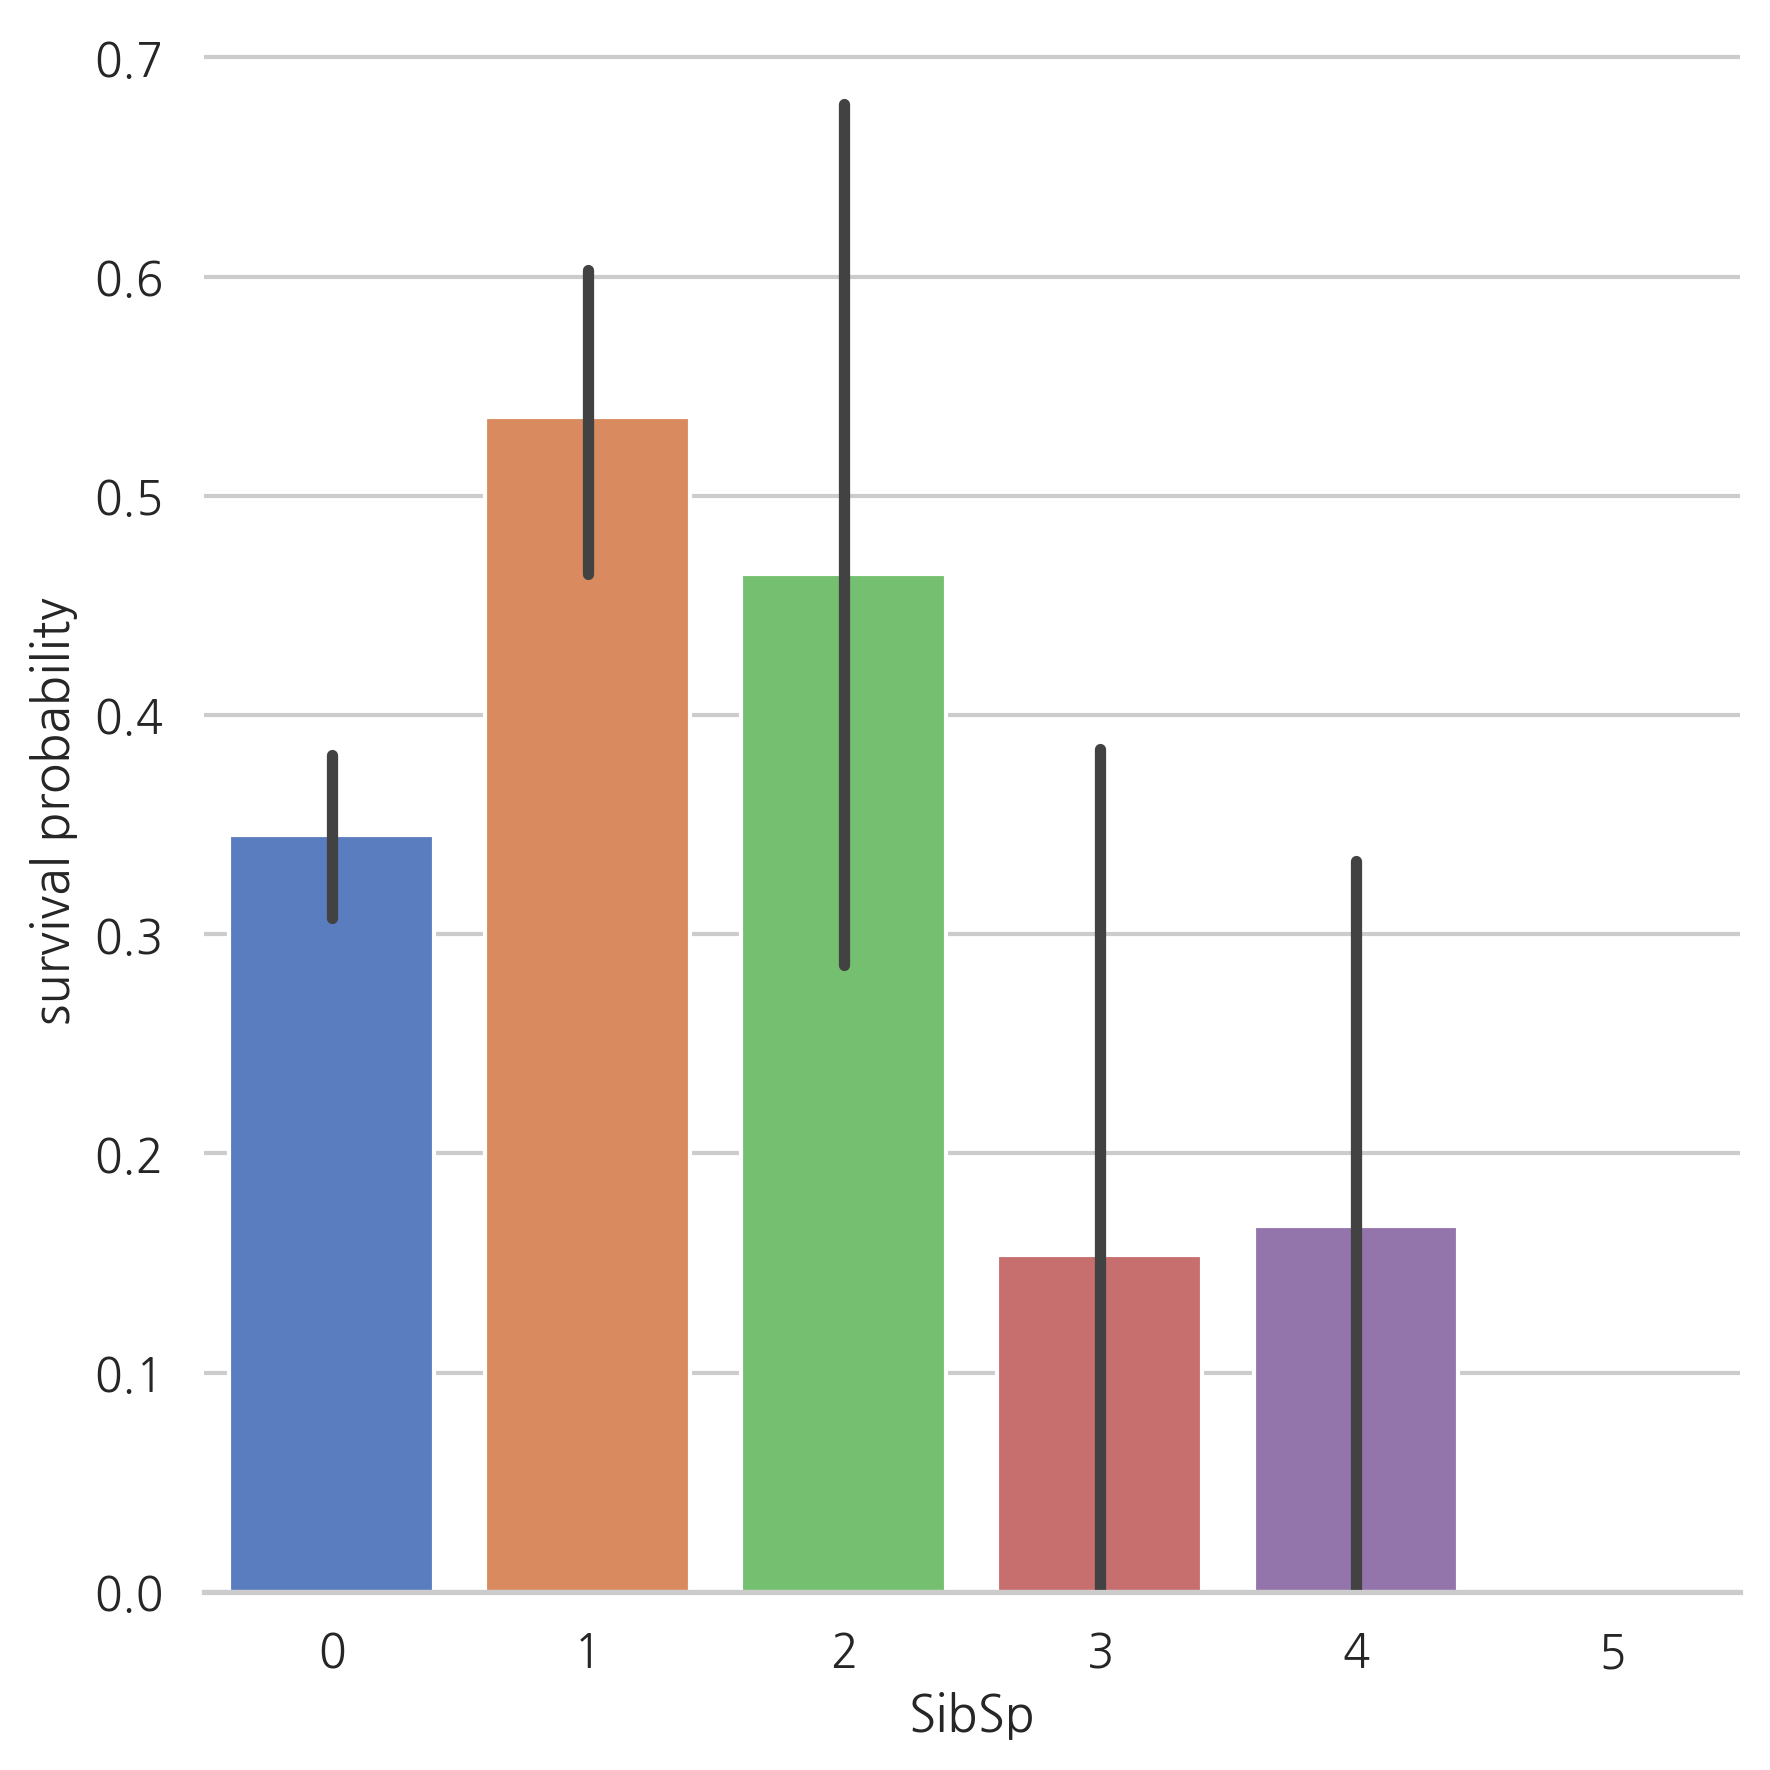

In [14]:
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6,
                   palette="muted")
g.despine(left=True) # 왼쪽 축 제거
g = g.set_ylabels("survival probability")

많은 형제/배우자를 가진 탑승객이면 살아남을 가능성이 적은 것처럼 보인다.

혼자 탑승한 탑승객이나 1명 혹은 2명인 탑승객은 살아남을 가능성이 높다.

이를 통해, 이러한 카테고리를 설명하는 새로운 feature을 고려할 수 있다.

#### Parch

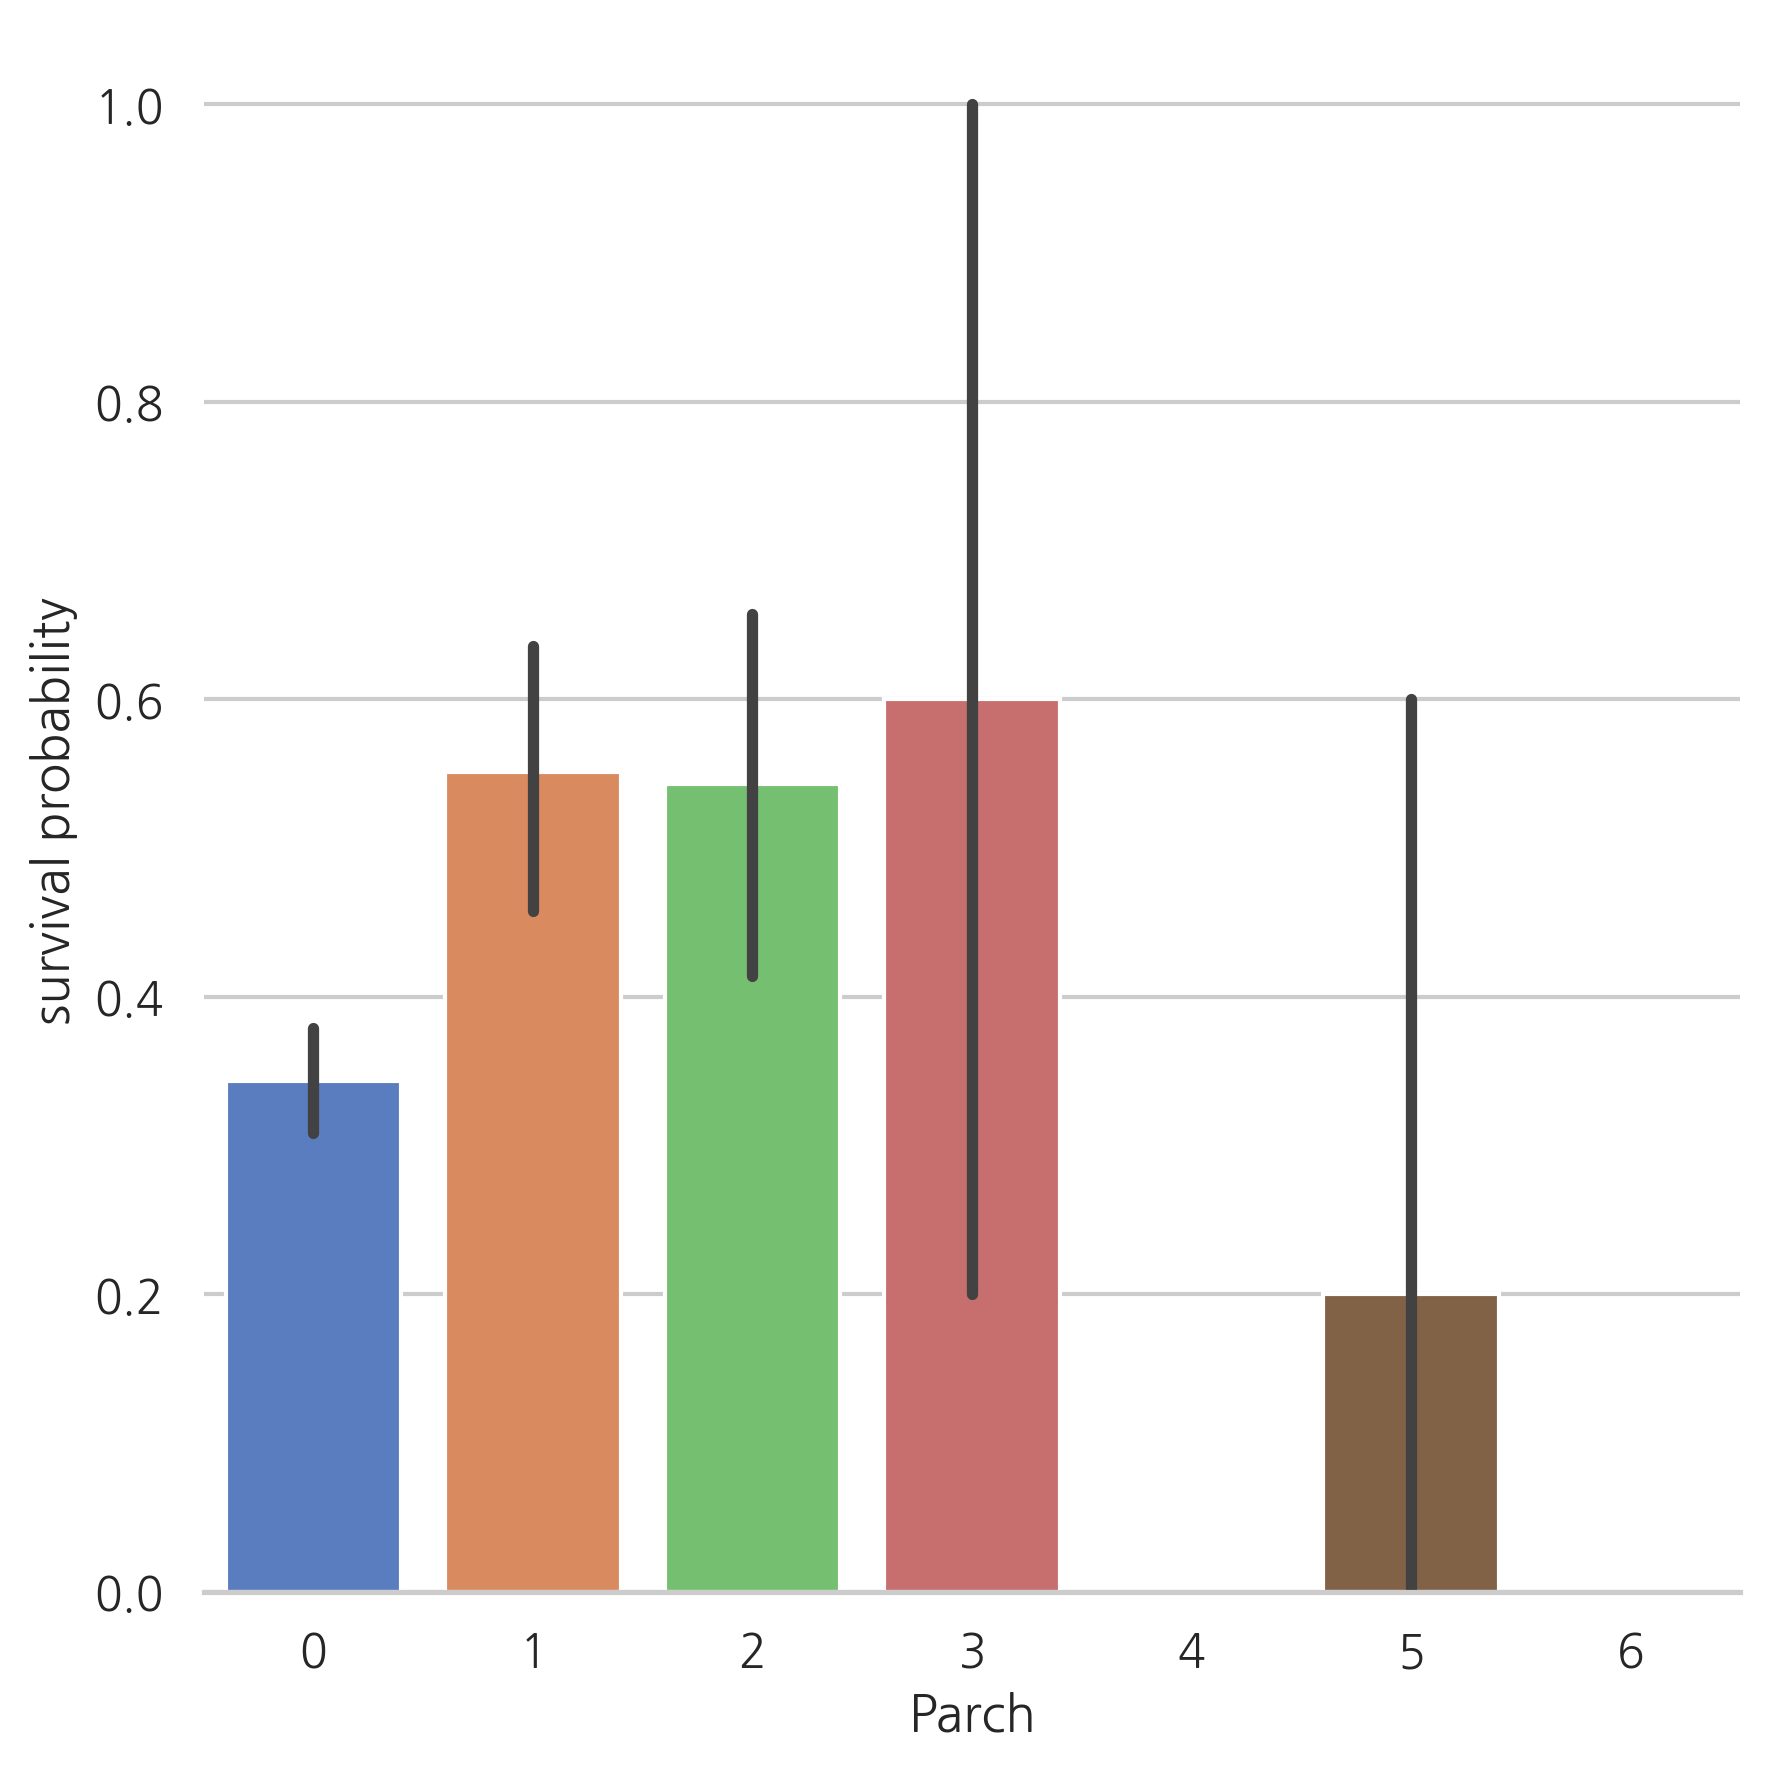

In [15]:
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6,
                   palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

가족 수가 적으면 생존할 가능성이 높다. (1인 탑승객이나 가족수가 3명 이상인 경우보다 더 높다)

#### Age

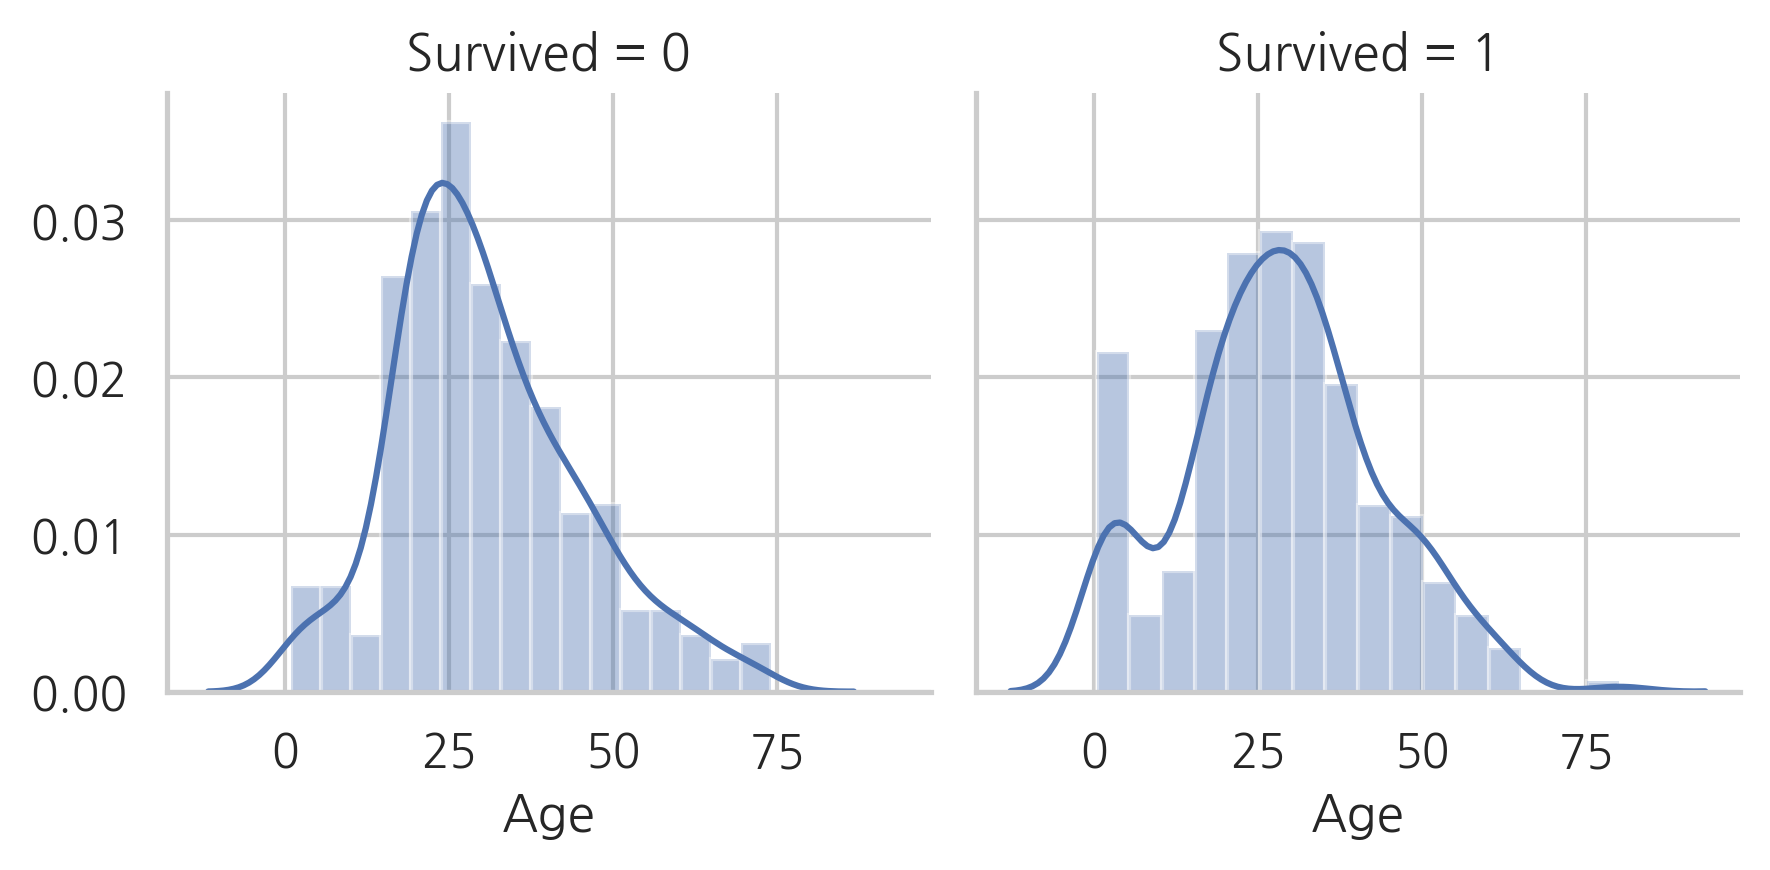

In [16]:
g = sns.FacetGrid(train, col="Survived") # Survived 칼럼의 값에 따른 그리드 생성
g = g.map(sns.distplot, "Age")

생존자와 사망자의 age 분포가 다르다는 것으알 수 있으며, 젊은 사람들에 비해 60-80대의 승객은 생존률이 낮다.

이 분포를 보았을때, 젊은 승객은 생존할 가능성이 더 높아 보인다.

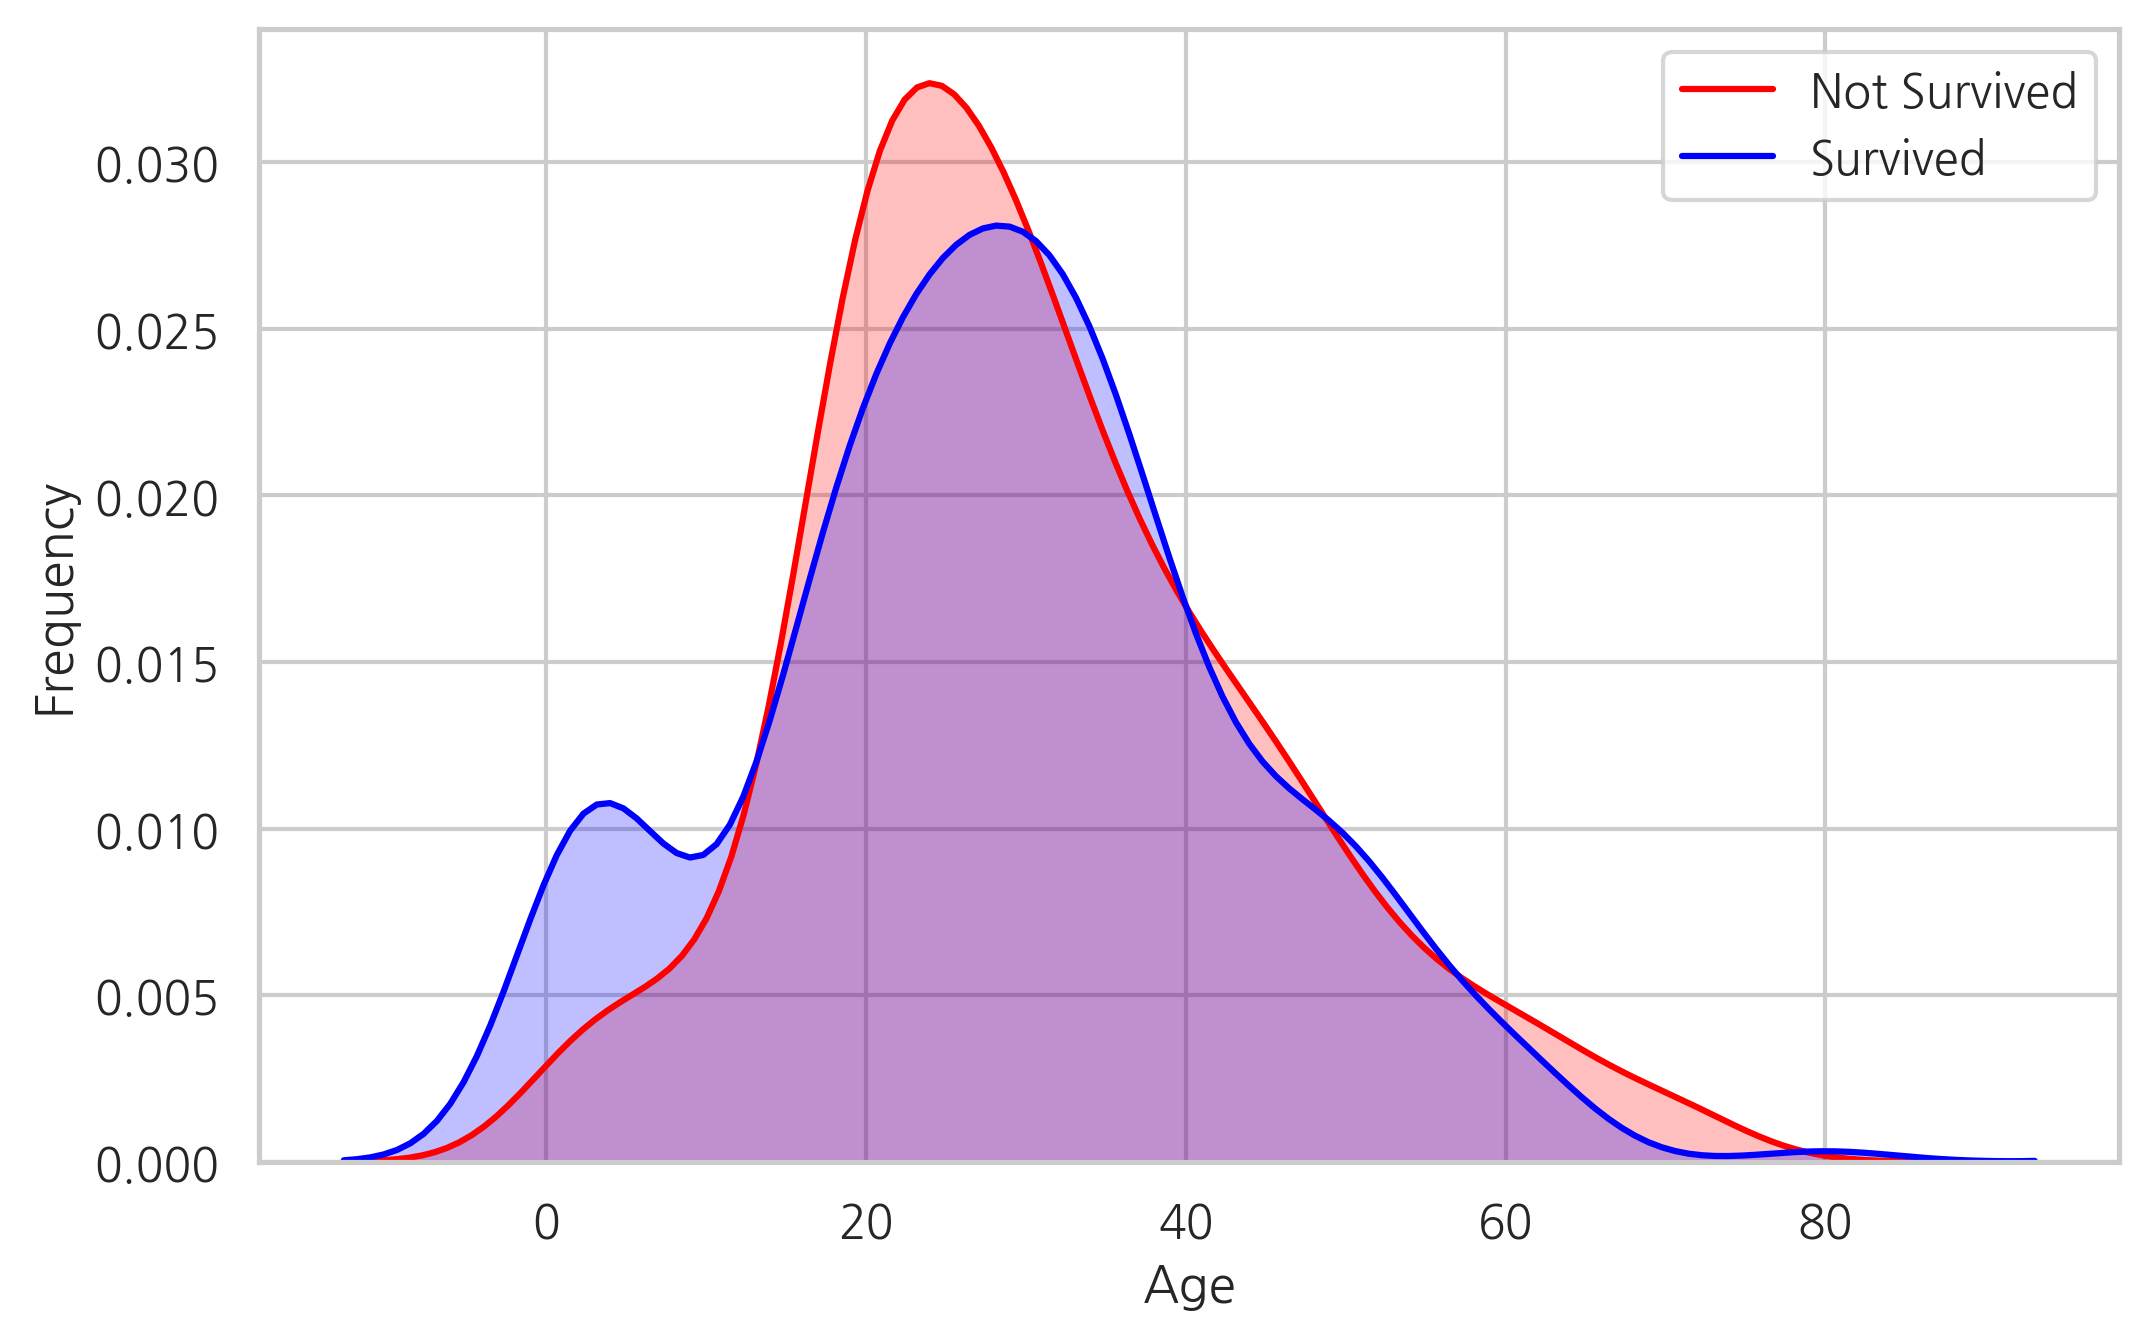

In [17]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
                color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
                color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

두 밀도를 겹쳐 보았을때, 0-5살에 해당하는 승객이 생존률이 가장 높다는 것을 확인할 수 있다.

#### Fare

In [18]:
dataset["Fare"].isnull().sum()

1

In [19]:
# 중간값을 결측치에 채워 넣는다
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

결측치가 하나이기 때문에 예측을 하는데 있어서 큰 영향을 미치지 않는다. 따라서, 그냥 간단하게 중간값을 채워넣는다.

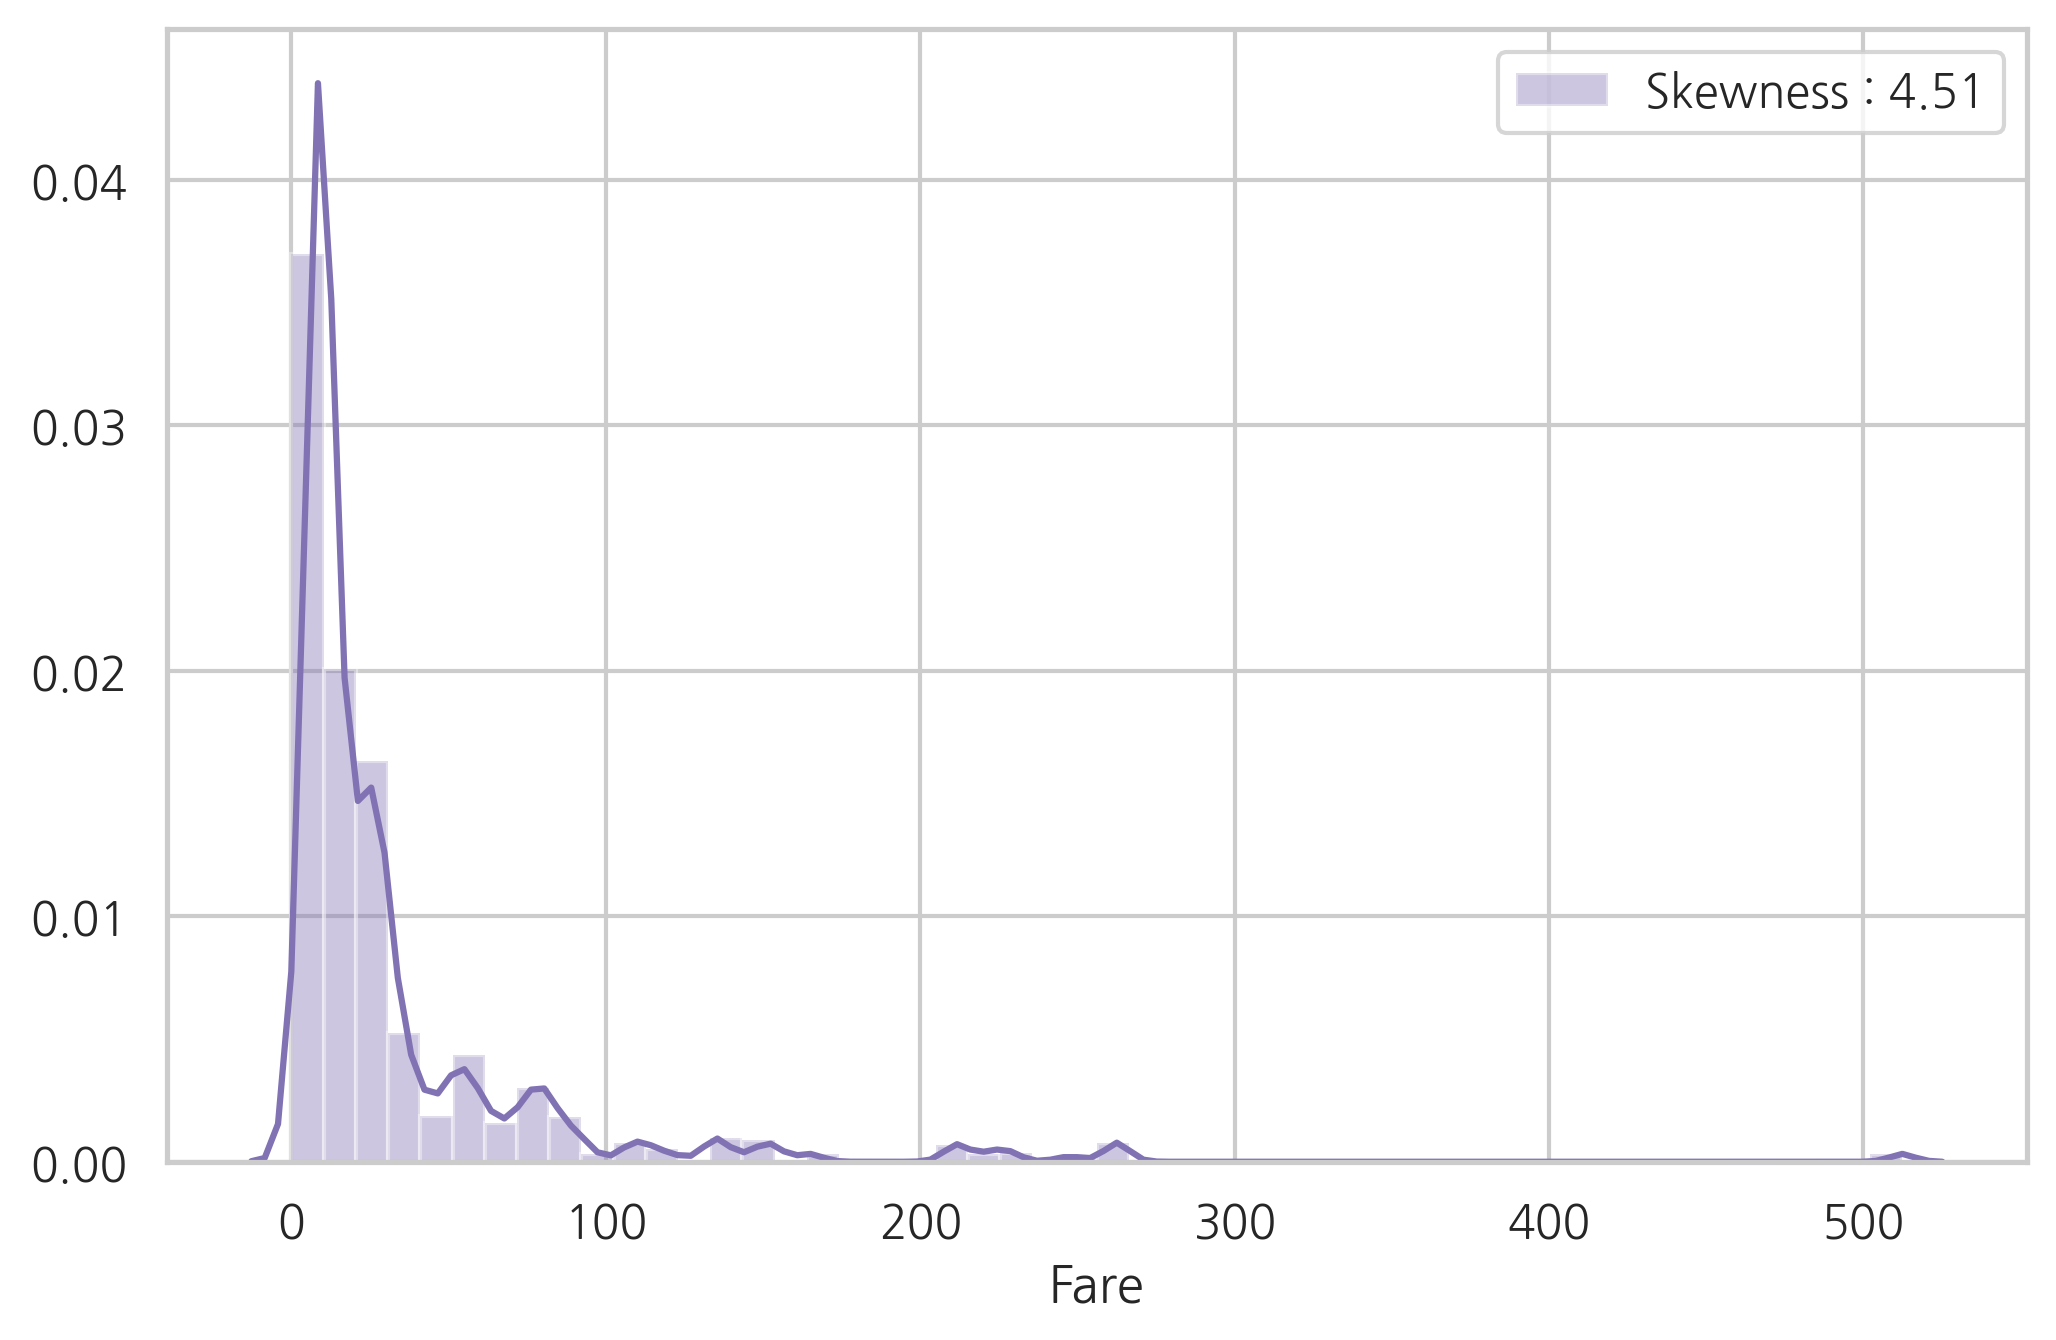

In [20]:
g = sns.distplot(dataset["Fare"], color="m", 
                 label="Skewness : %.2f" % (dataset["Fare"].skew()))
# skew의 값이 -2 ~ +2이면 치우침이 없는 데이터
g = g.legend(loc="best")

Fare 분포는 한쪽으로 치우침이 심하다. 이런 경우 스케일링을 하더라도 모델에 매우 큰 값의 가중치가 부여될 수 있다.

이런 경우 한쪽의 치우침(왜도)를 줄이기 위해 log 함수로 바꿔주는 것이 좋다.

In [21]:
dataset["Fare"] = dataset["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

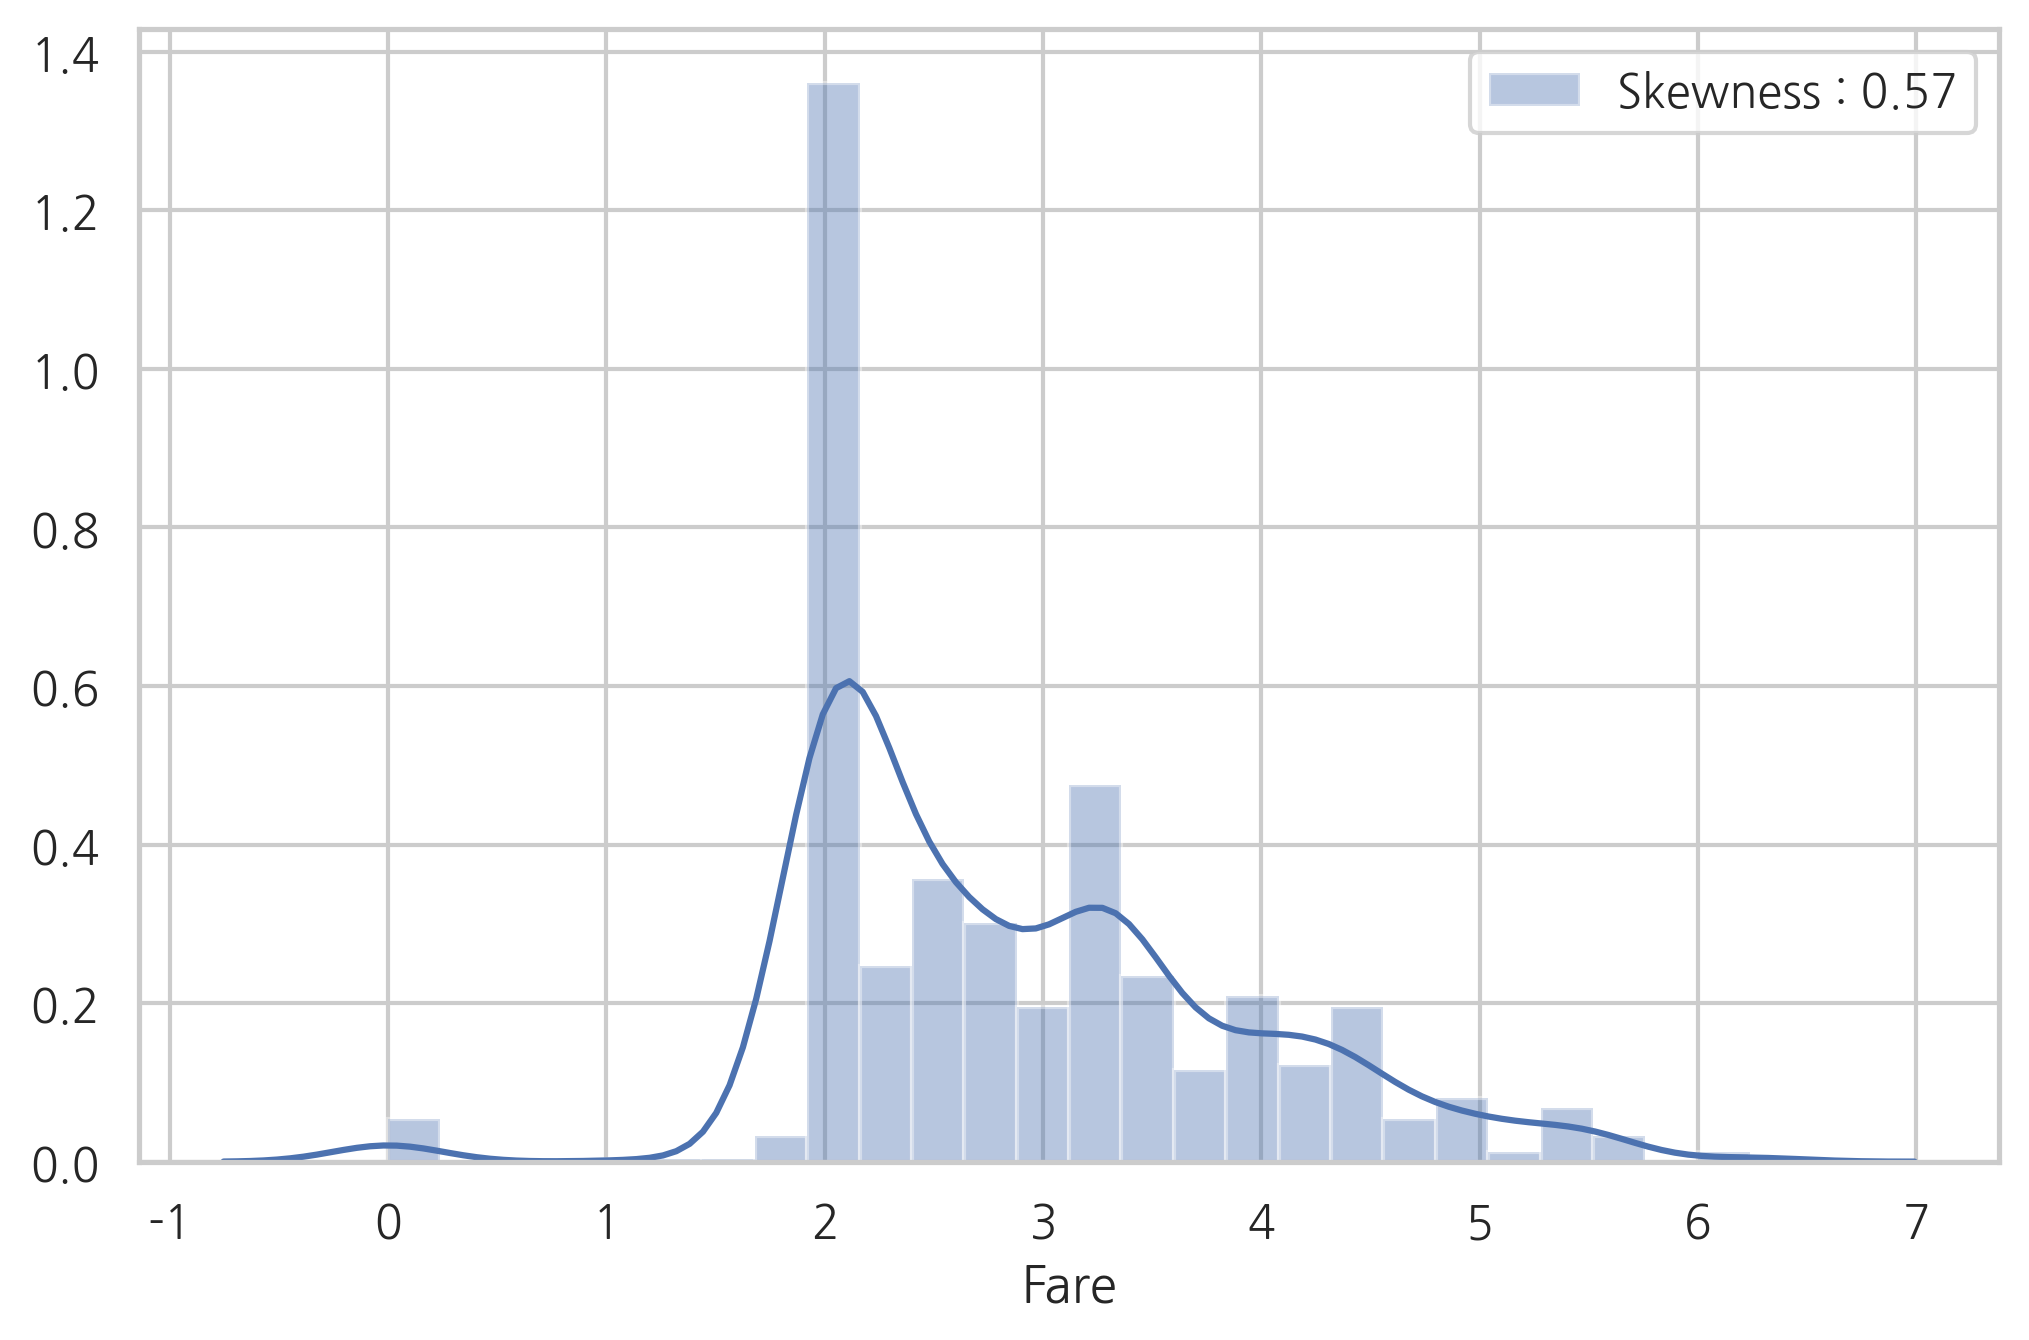

In [22]:
g = sns.distplot(dataset["Fare"], color="b", 
                 label="Skewness : %.2f" % (dataset["Fare"].skew()))
g = g.legend(loc="best")

log 함수로 변환 후, 왜도가 굉장히 줄어든 모습

### 3.2 Categorical values
#### Sex

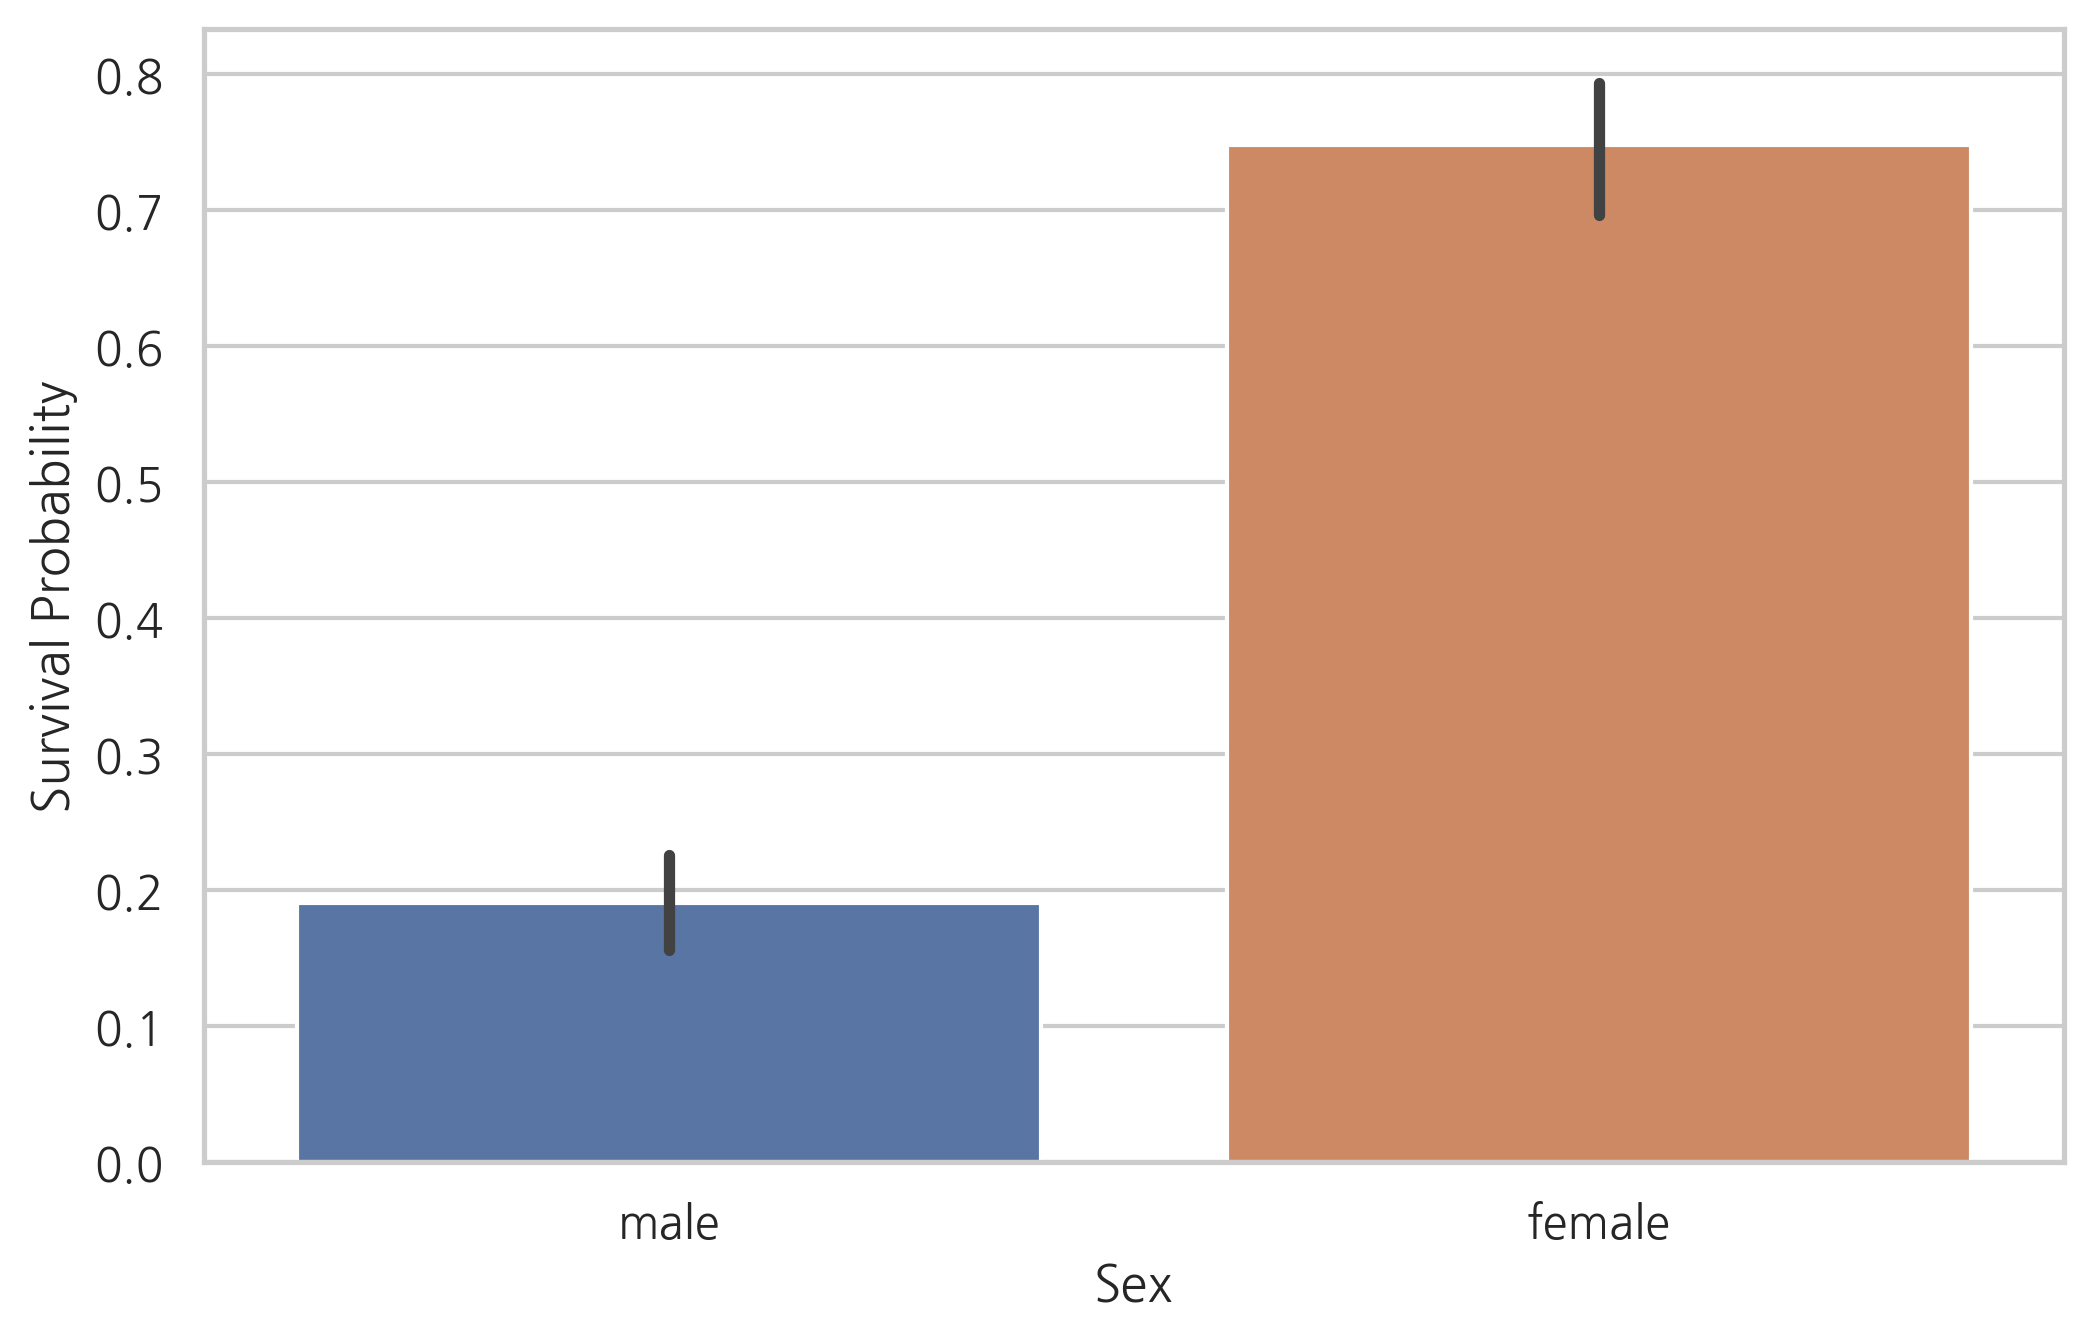

In [23]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [24]:
train[["Sex", "Survived"]].groupby("Sex").mean()

Survived
Sex             
female  0.747573
male    0.190559

명백히 여성보다 남성의 생존 가능성이 낮다.

따라서, 성별은 생존자 예측에 중요한 역할을 맡을 것으로 보인다.

#### Pclass

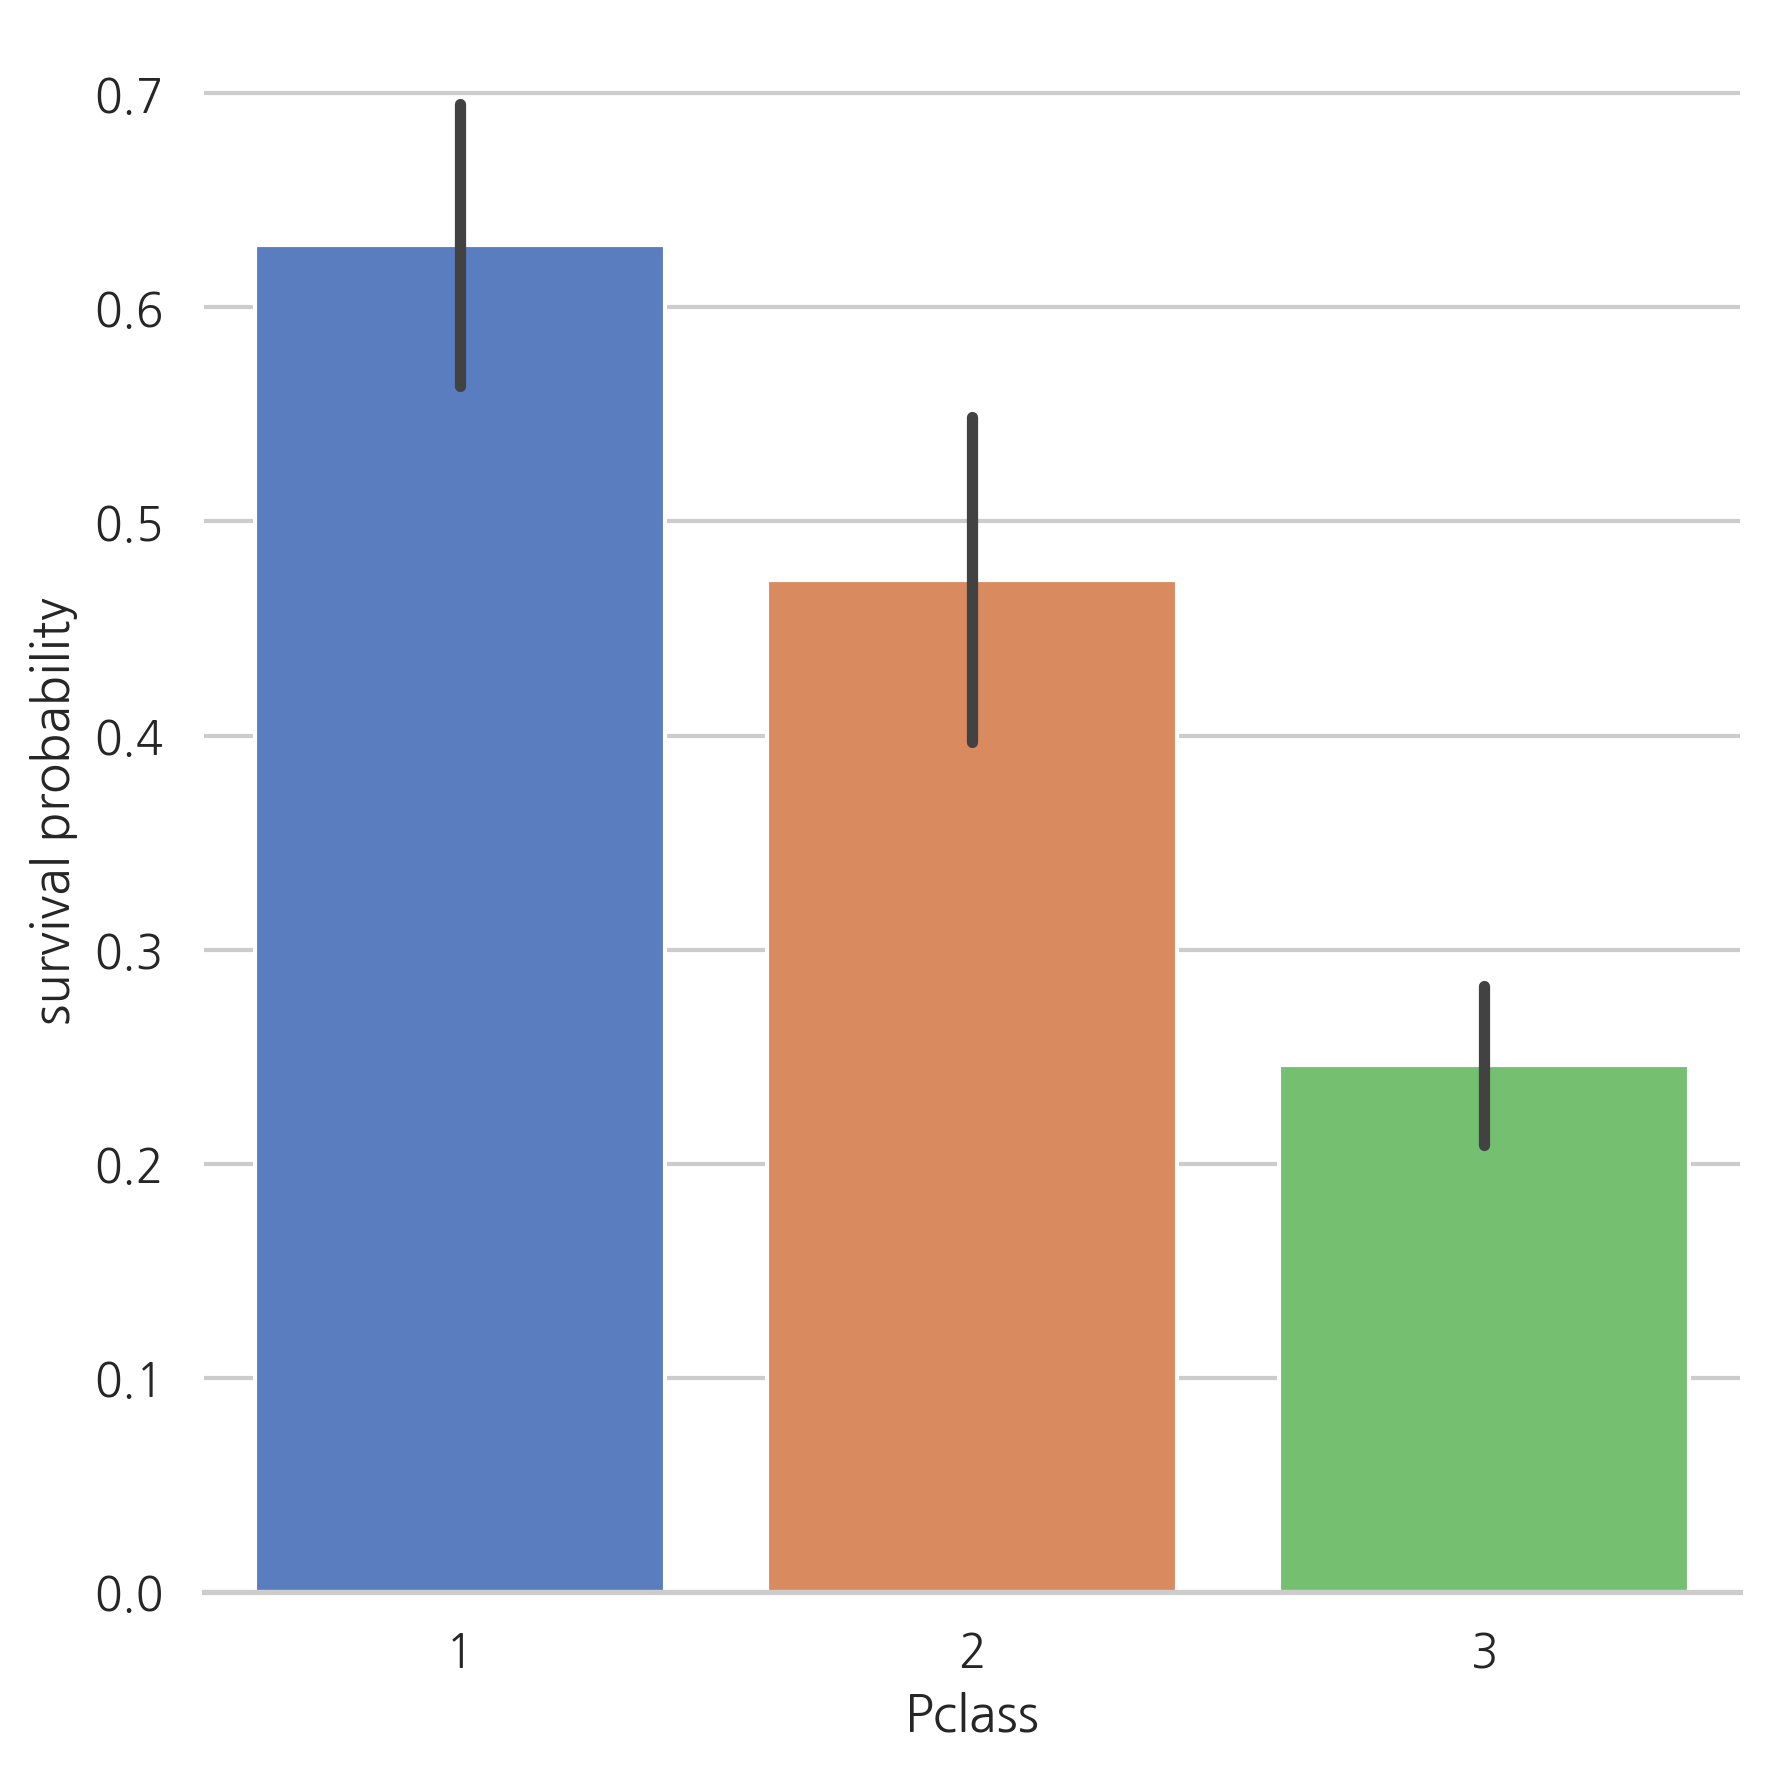

In [25]:
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6,
                   palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

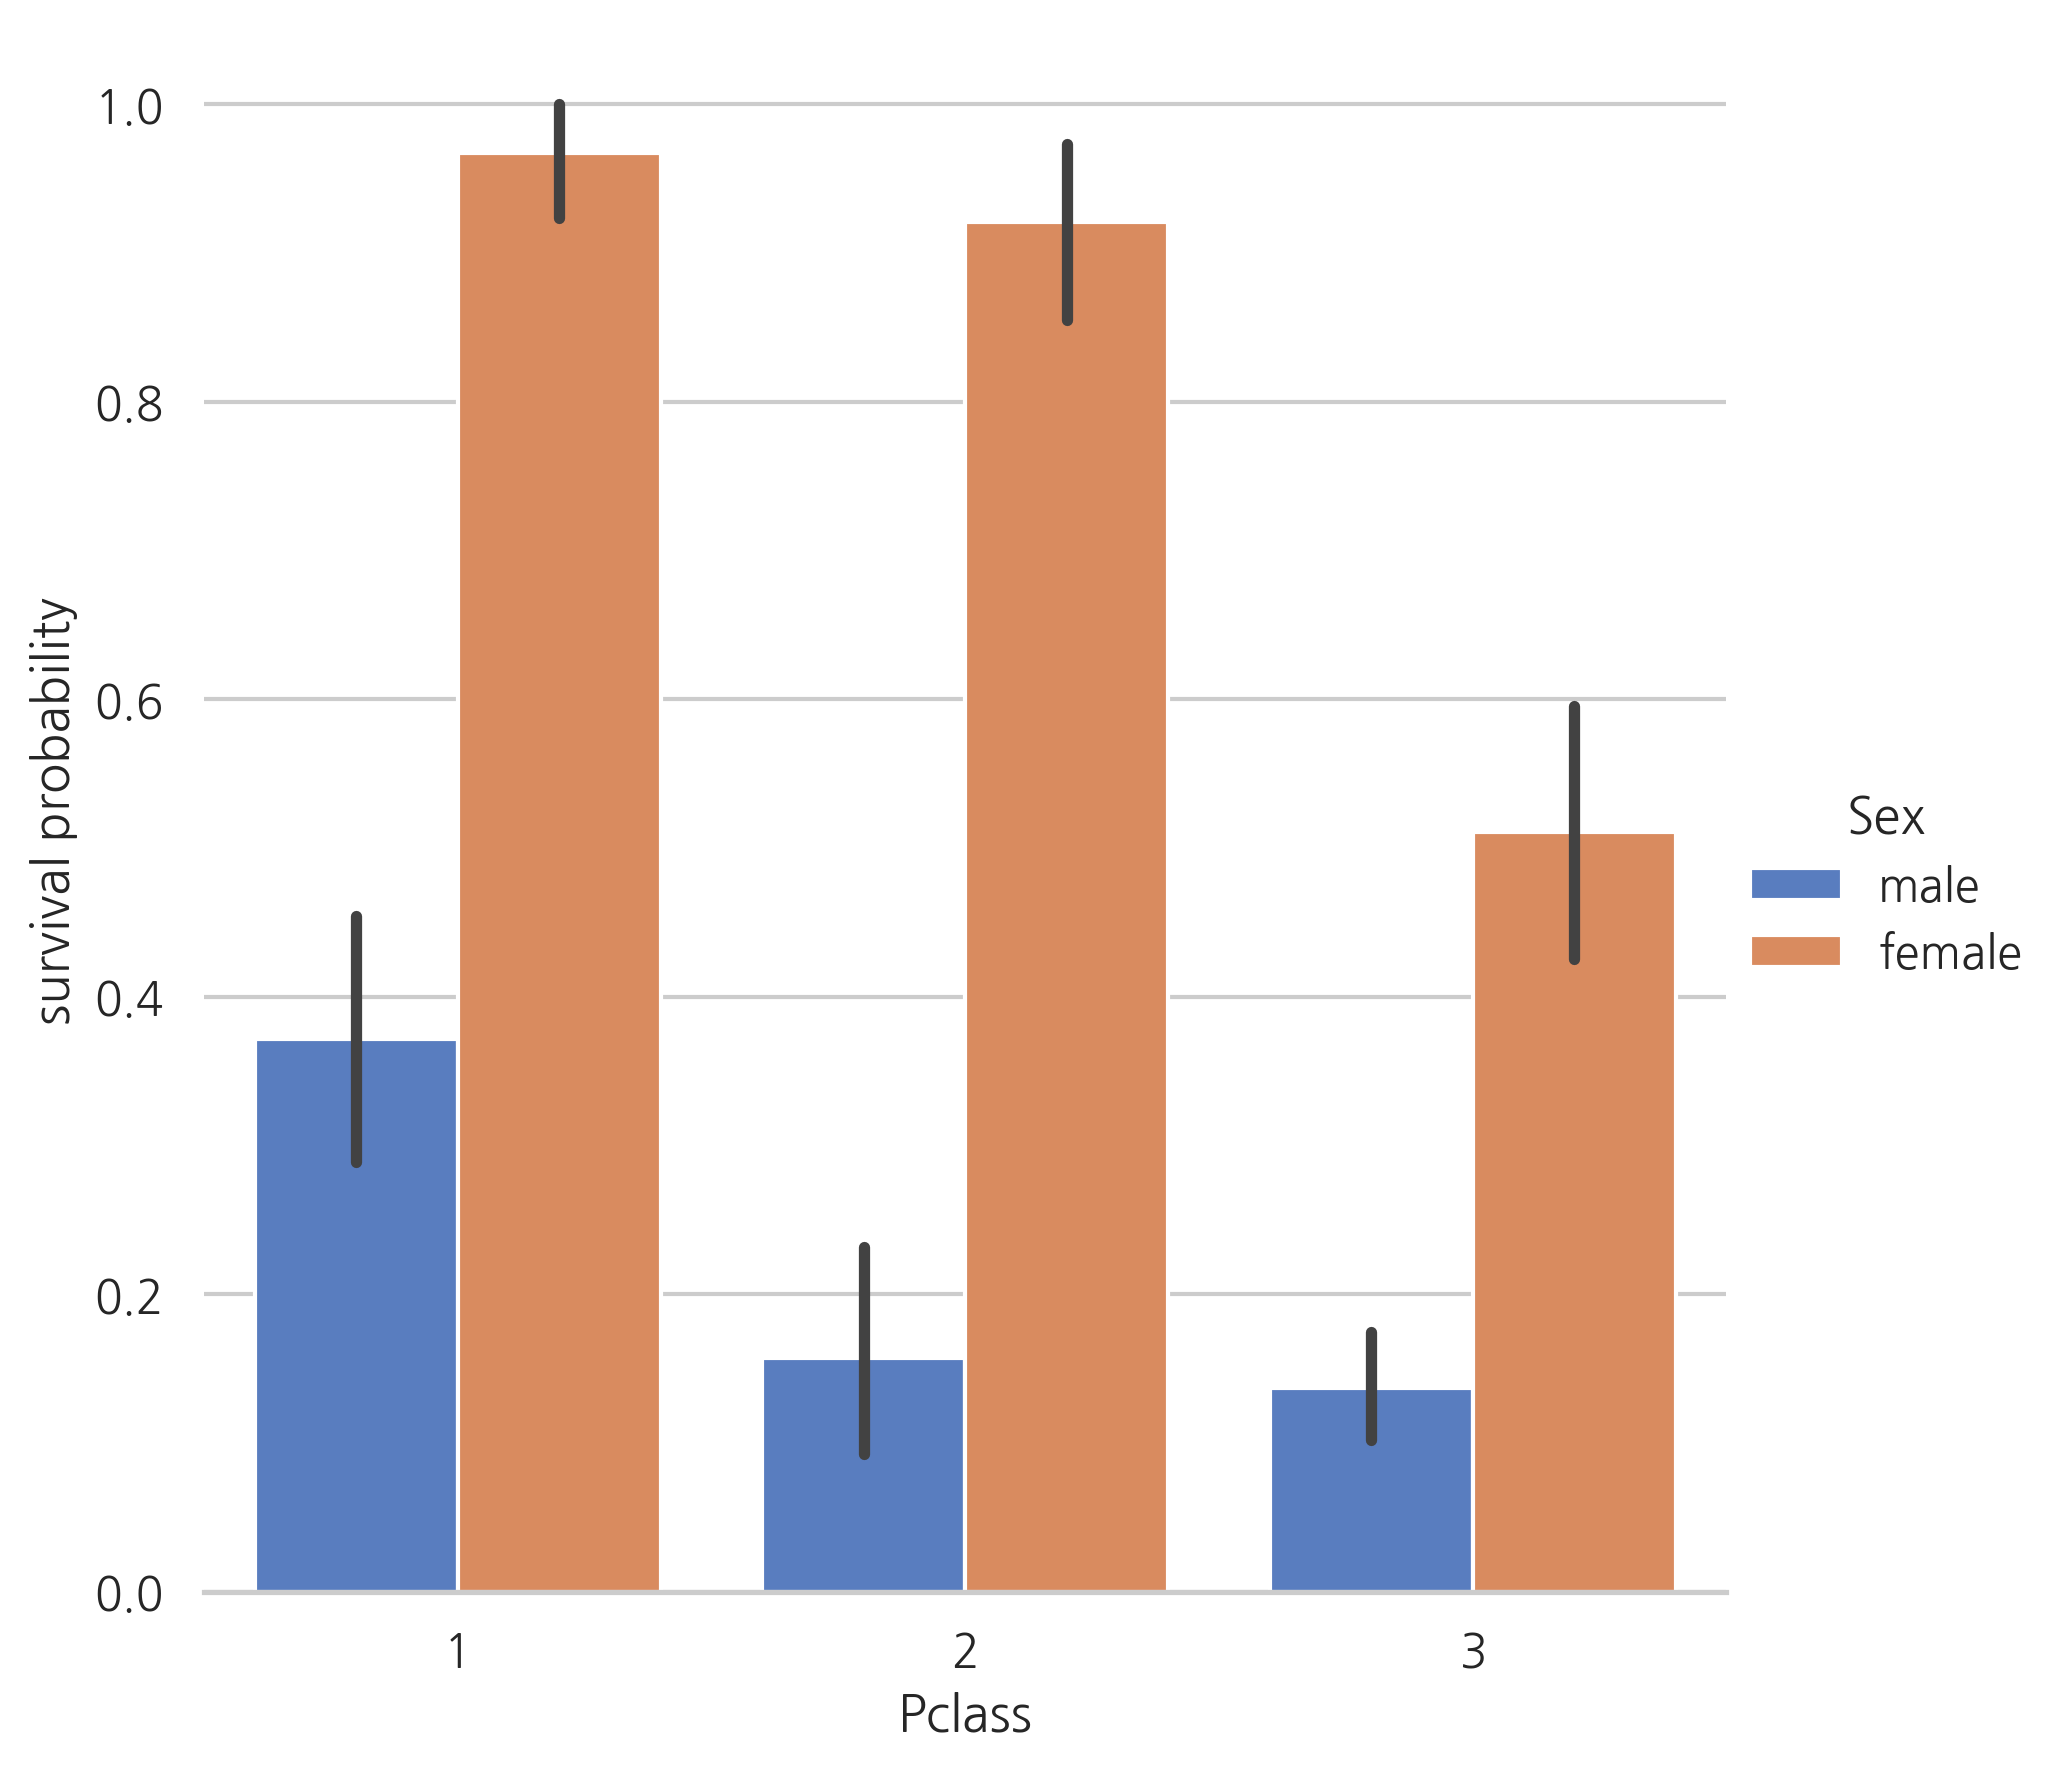

In [26]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

1등석 탑승객들은 다른 탑승석의 승객들보다 생존 가능성이 높다.

#### Embarked

In [27]:
dataset["Embarked"].isnull().sum()

2

In [28]:
# S 값의 빈도수가 가장 높기 때문에 결측치에 S 값을 채운다.
dataset["Embarked"] = dataset["Embarked"].fillna("S")

결측치가 2개에 불과하기 때문에 가장 빈도수가 높은 값을 결측치에 채워 넣는다. (S)

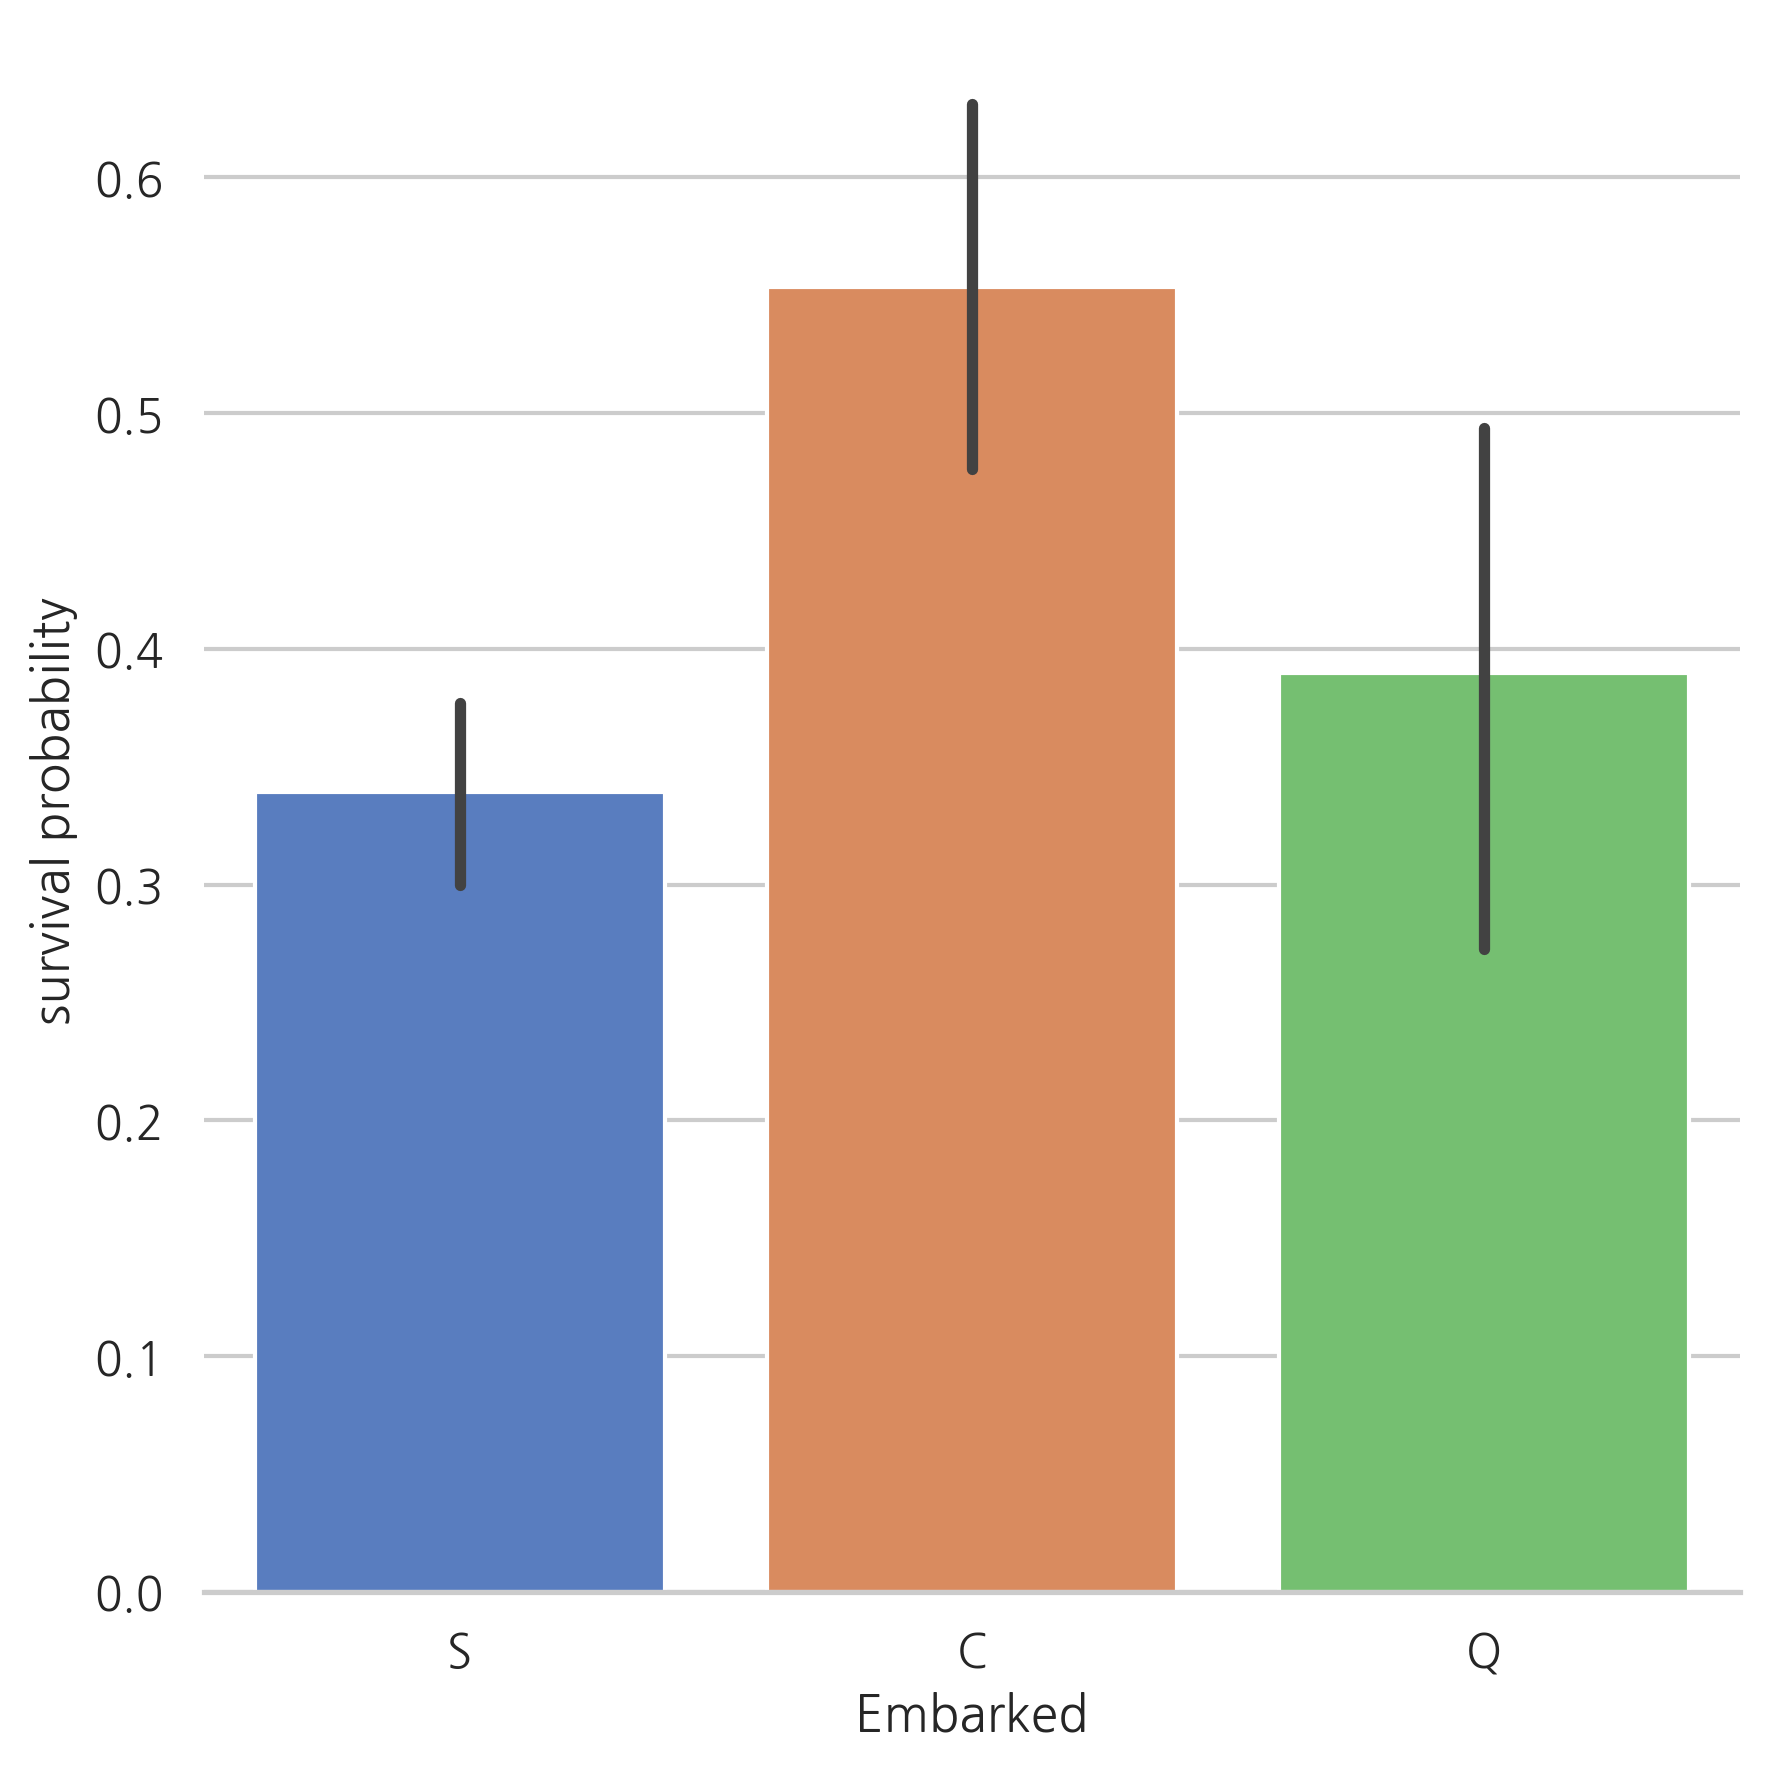

In [29]:
g = sns.factorplot(x="Embarked", y="Survived", data=train, size=6,
                   kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Cherbourg (C)에서 탑승한 승객의 생존 가능성이 더 높아 보인다.

1등석의 탑승객은 Queenstown (Q)나 Southampton (S)보다 Cherbourg (C)에서 탑승한 비율이 높을 것으로 예상된다.

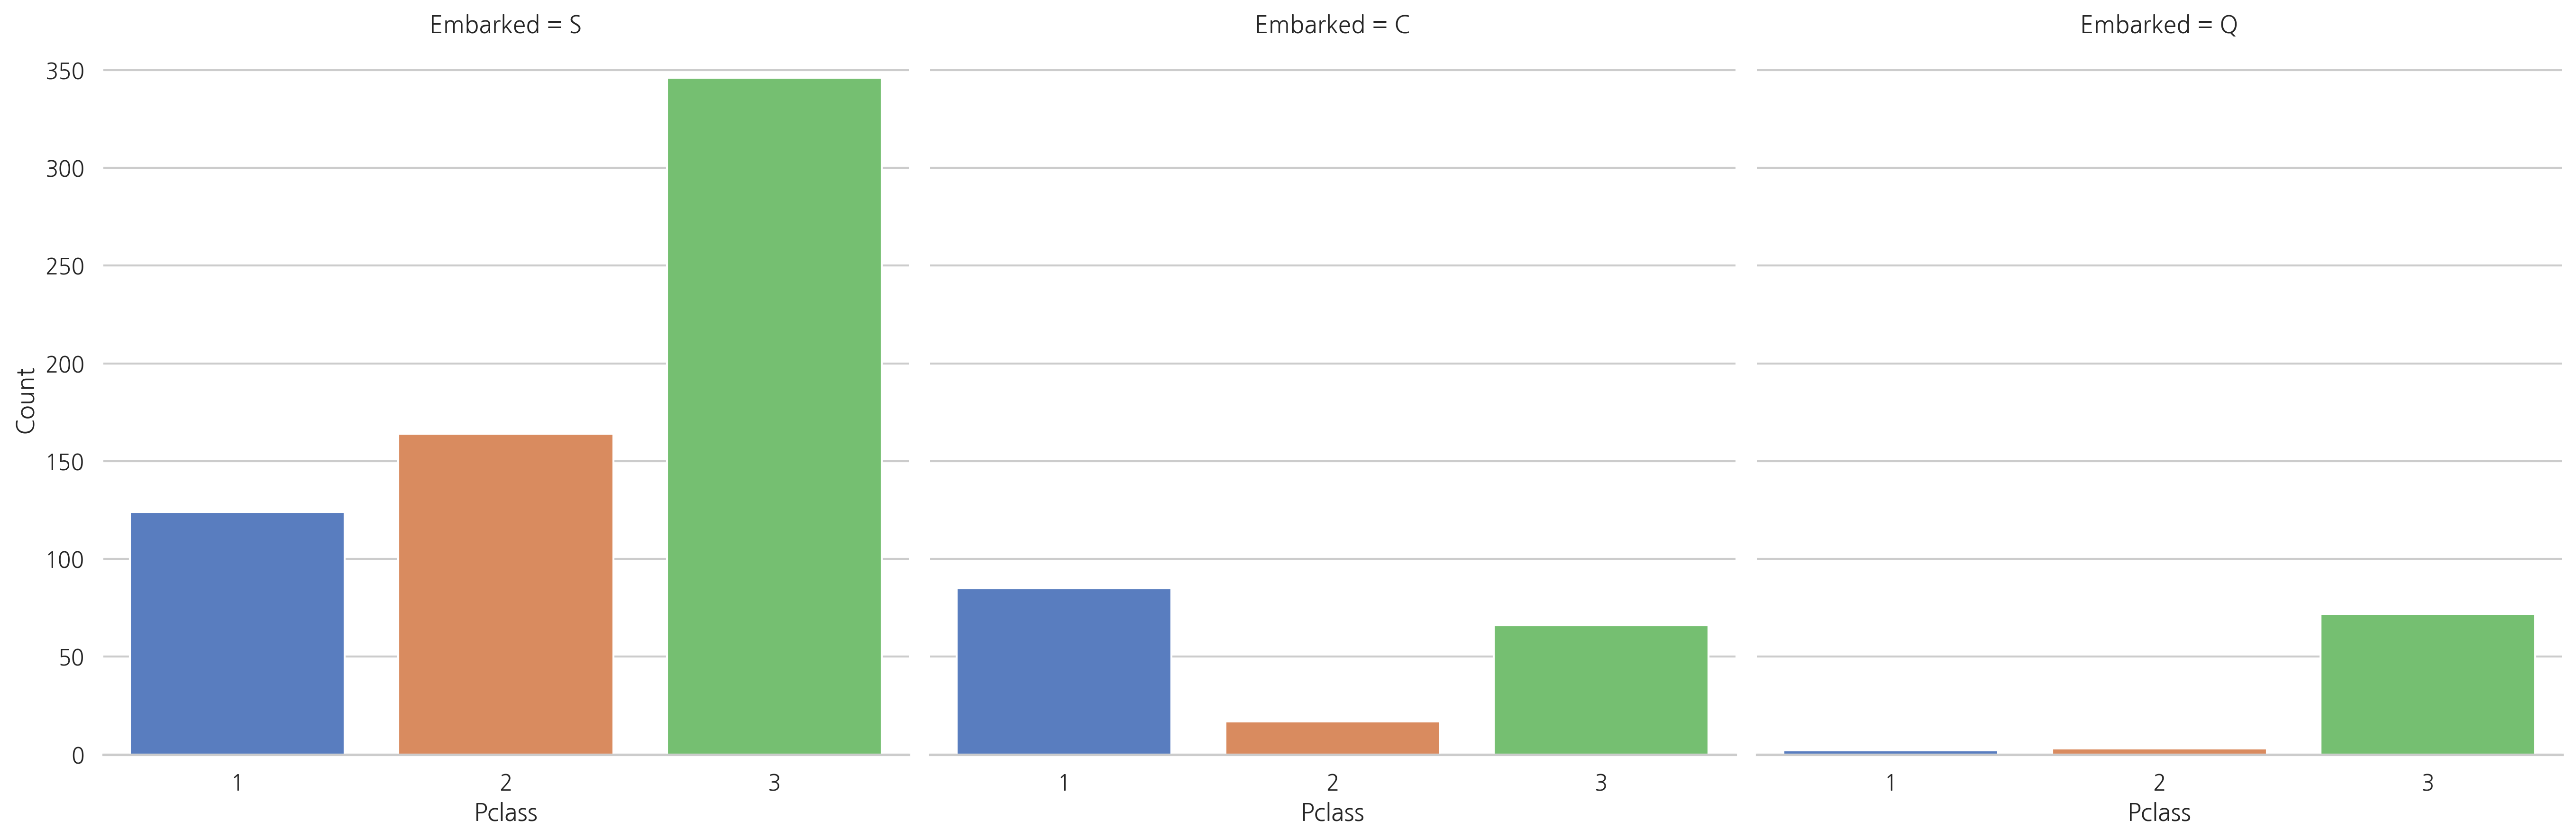

In [30]:
g = sns.factorplot("Pclass", col="Embarked", data=train, size=6, kind="count",
                   palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

3등석은 Southampton (S)나 Queenstown (Q)에서 탑승한 승객의 수가 가장 높다. 반면에 Cherbourg (C)에서 탑승한 탑승객은 생존률이 가장 높은 1등석 승객의 수가 가장 높다.

------

## 4. Filling missing Values
### 4.1 Age

전체 데이터 세트에서 Age 칼럼의 결측치는 256개.

생존가능성이 더 높은 하위집단(예를 들어, children)이 있기 때문에 age 칼럼을 유지한채 결측치를 다른 값으로 바꿔준다.

위의 문제를 다루기 위해 Age 칼럼과 상관관계가 높은 칼럼들을 살펴본다.

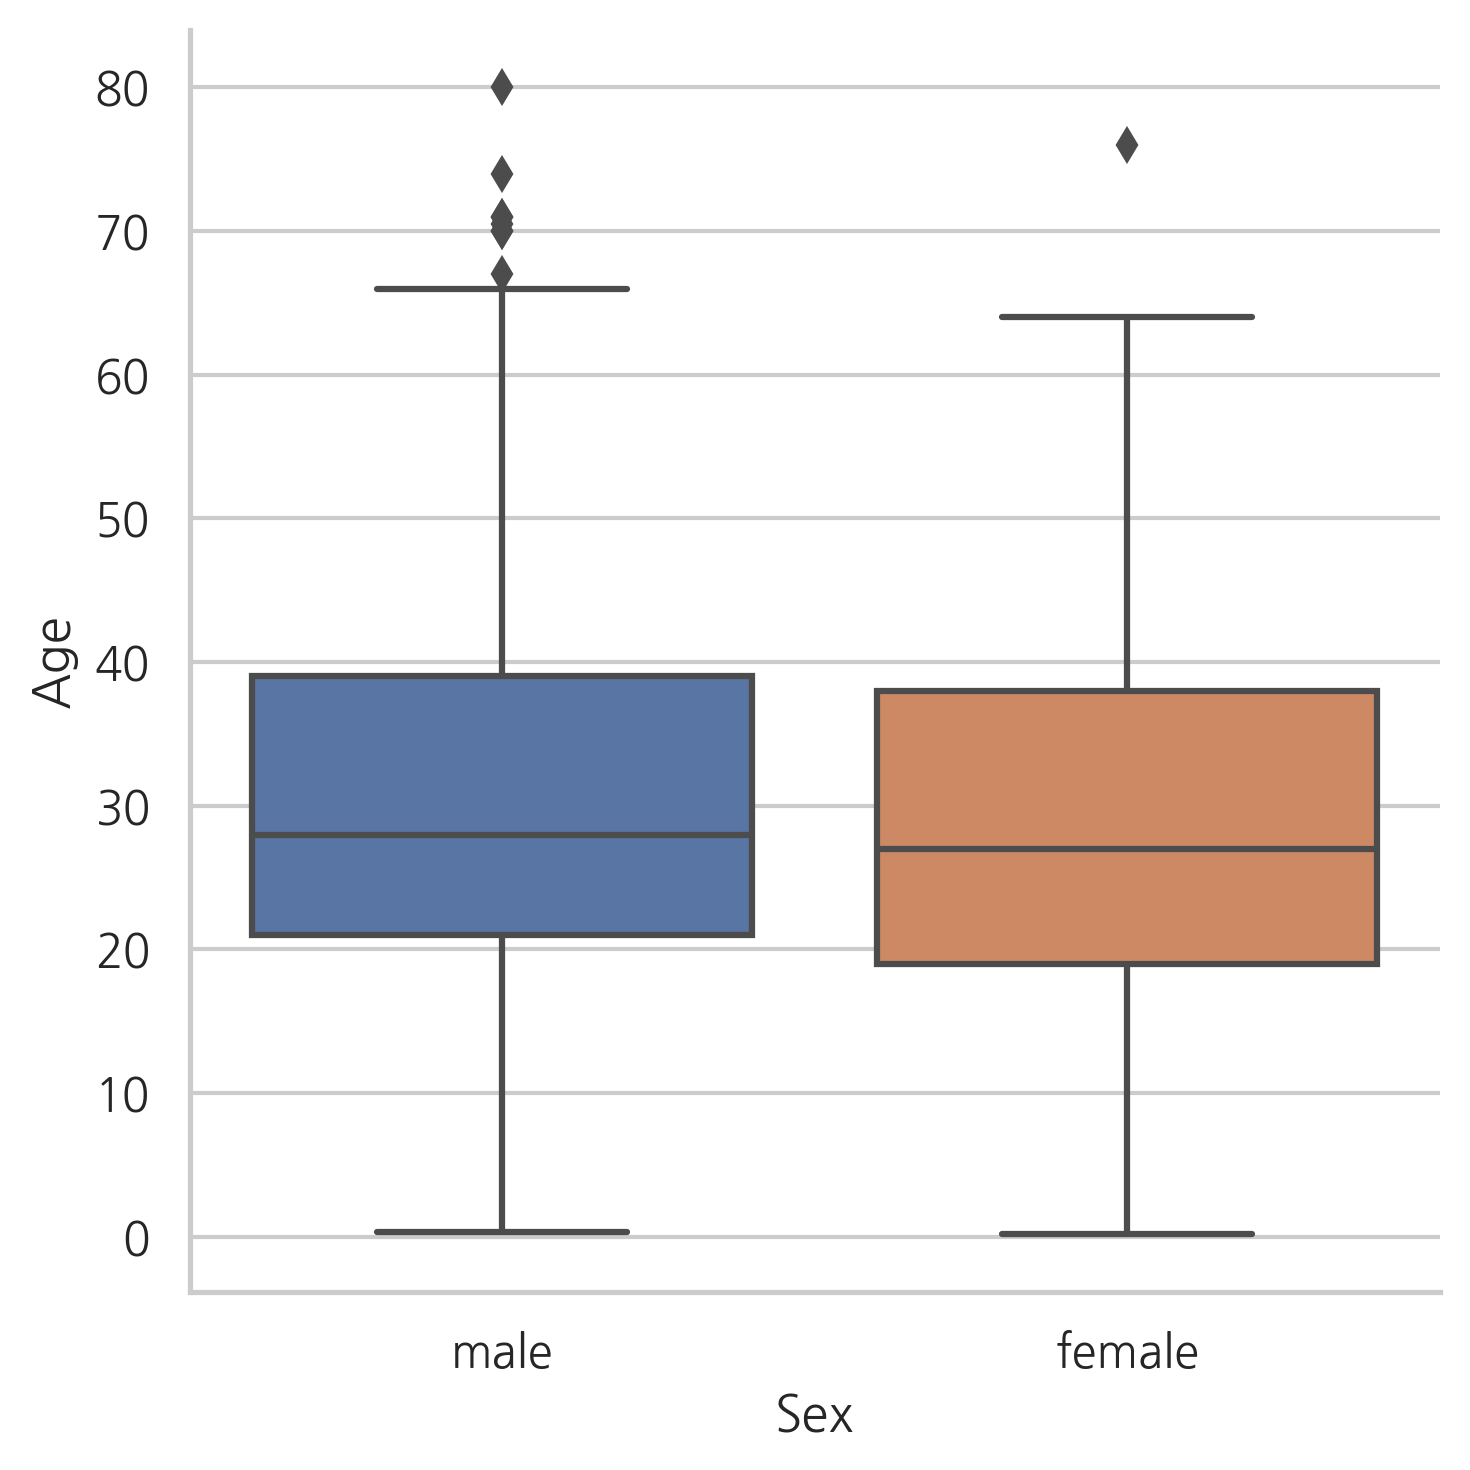

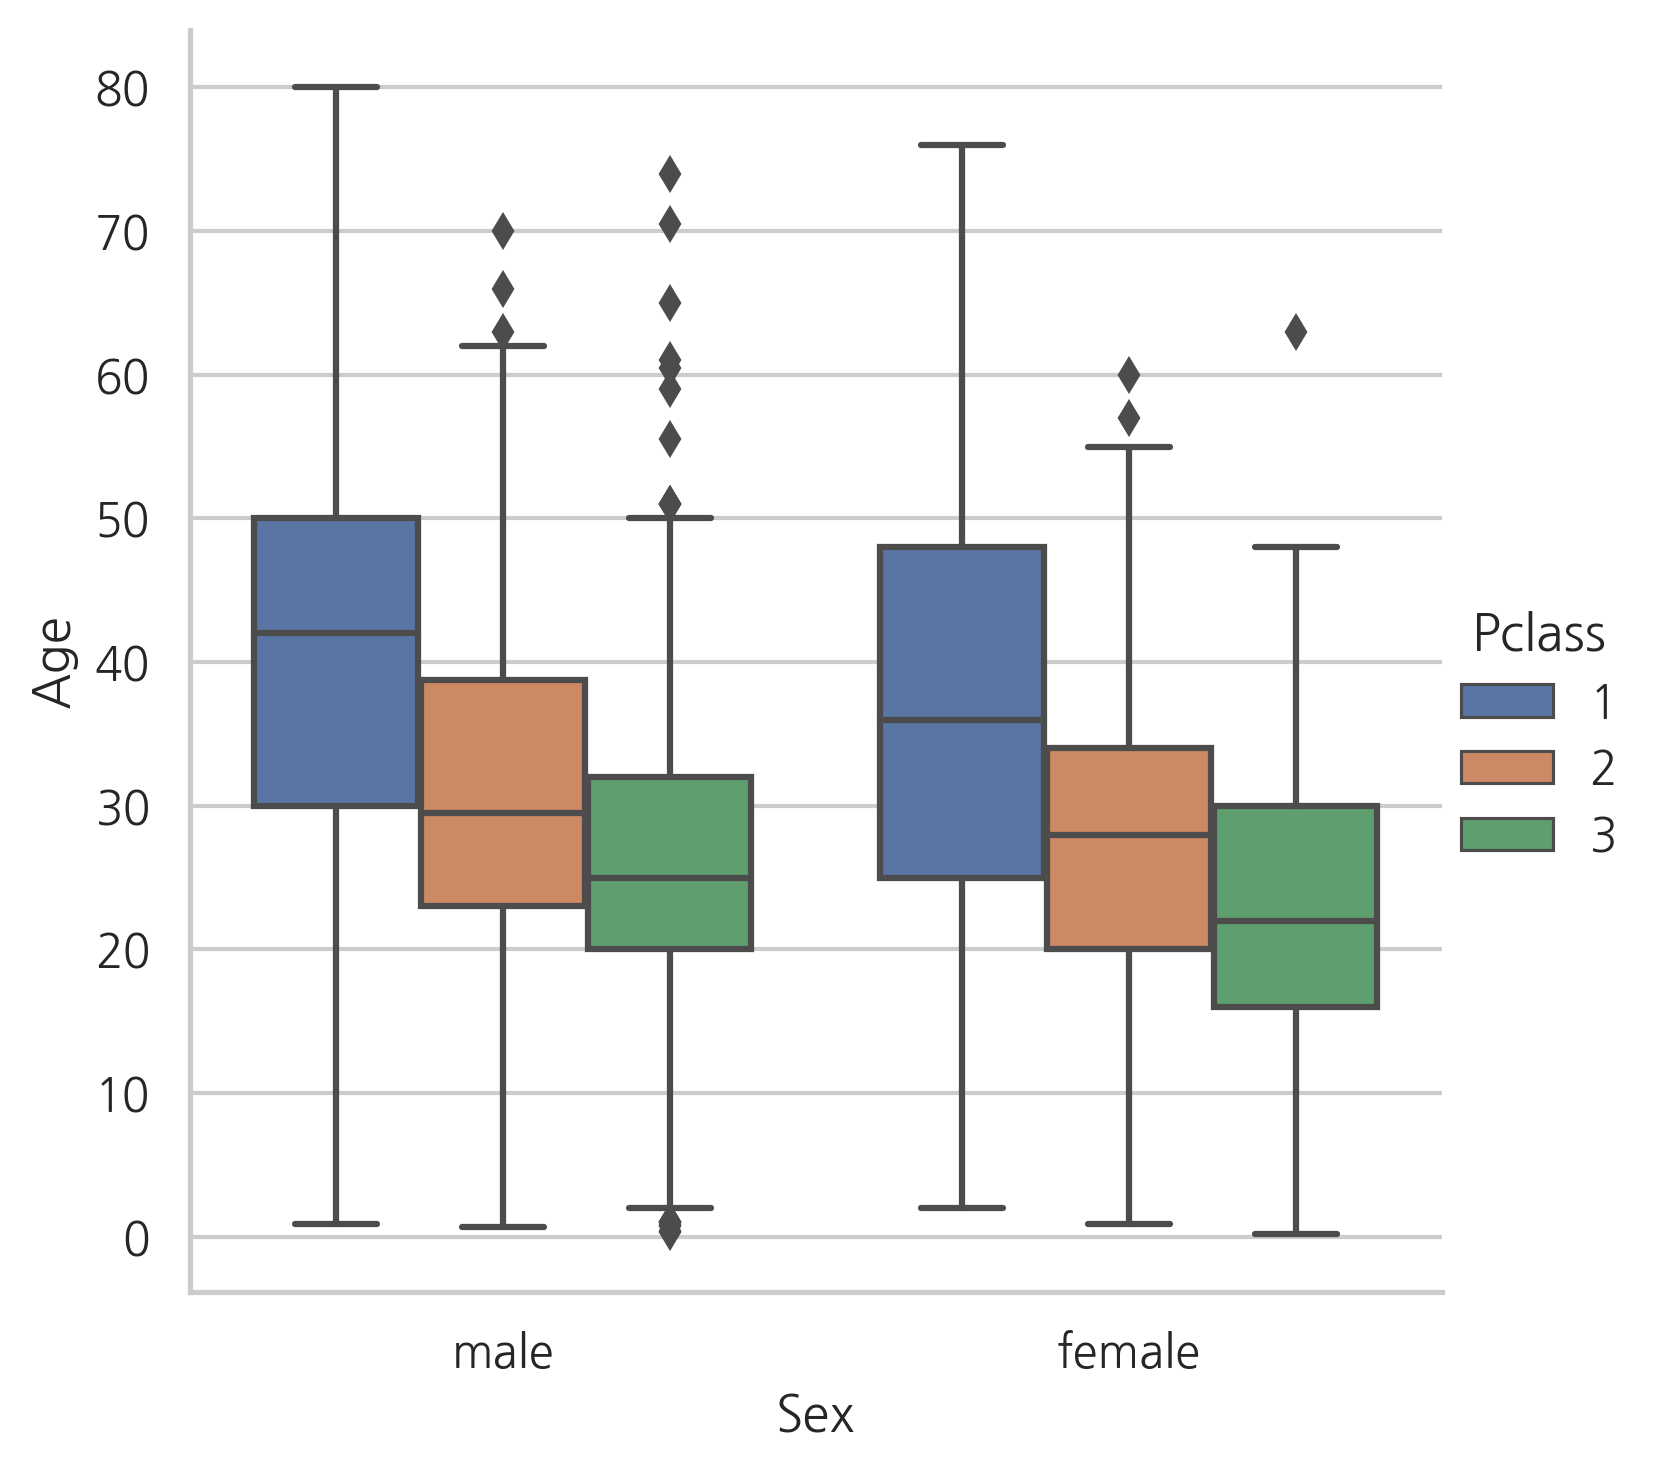

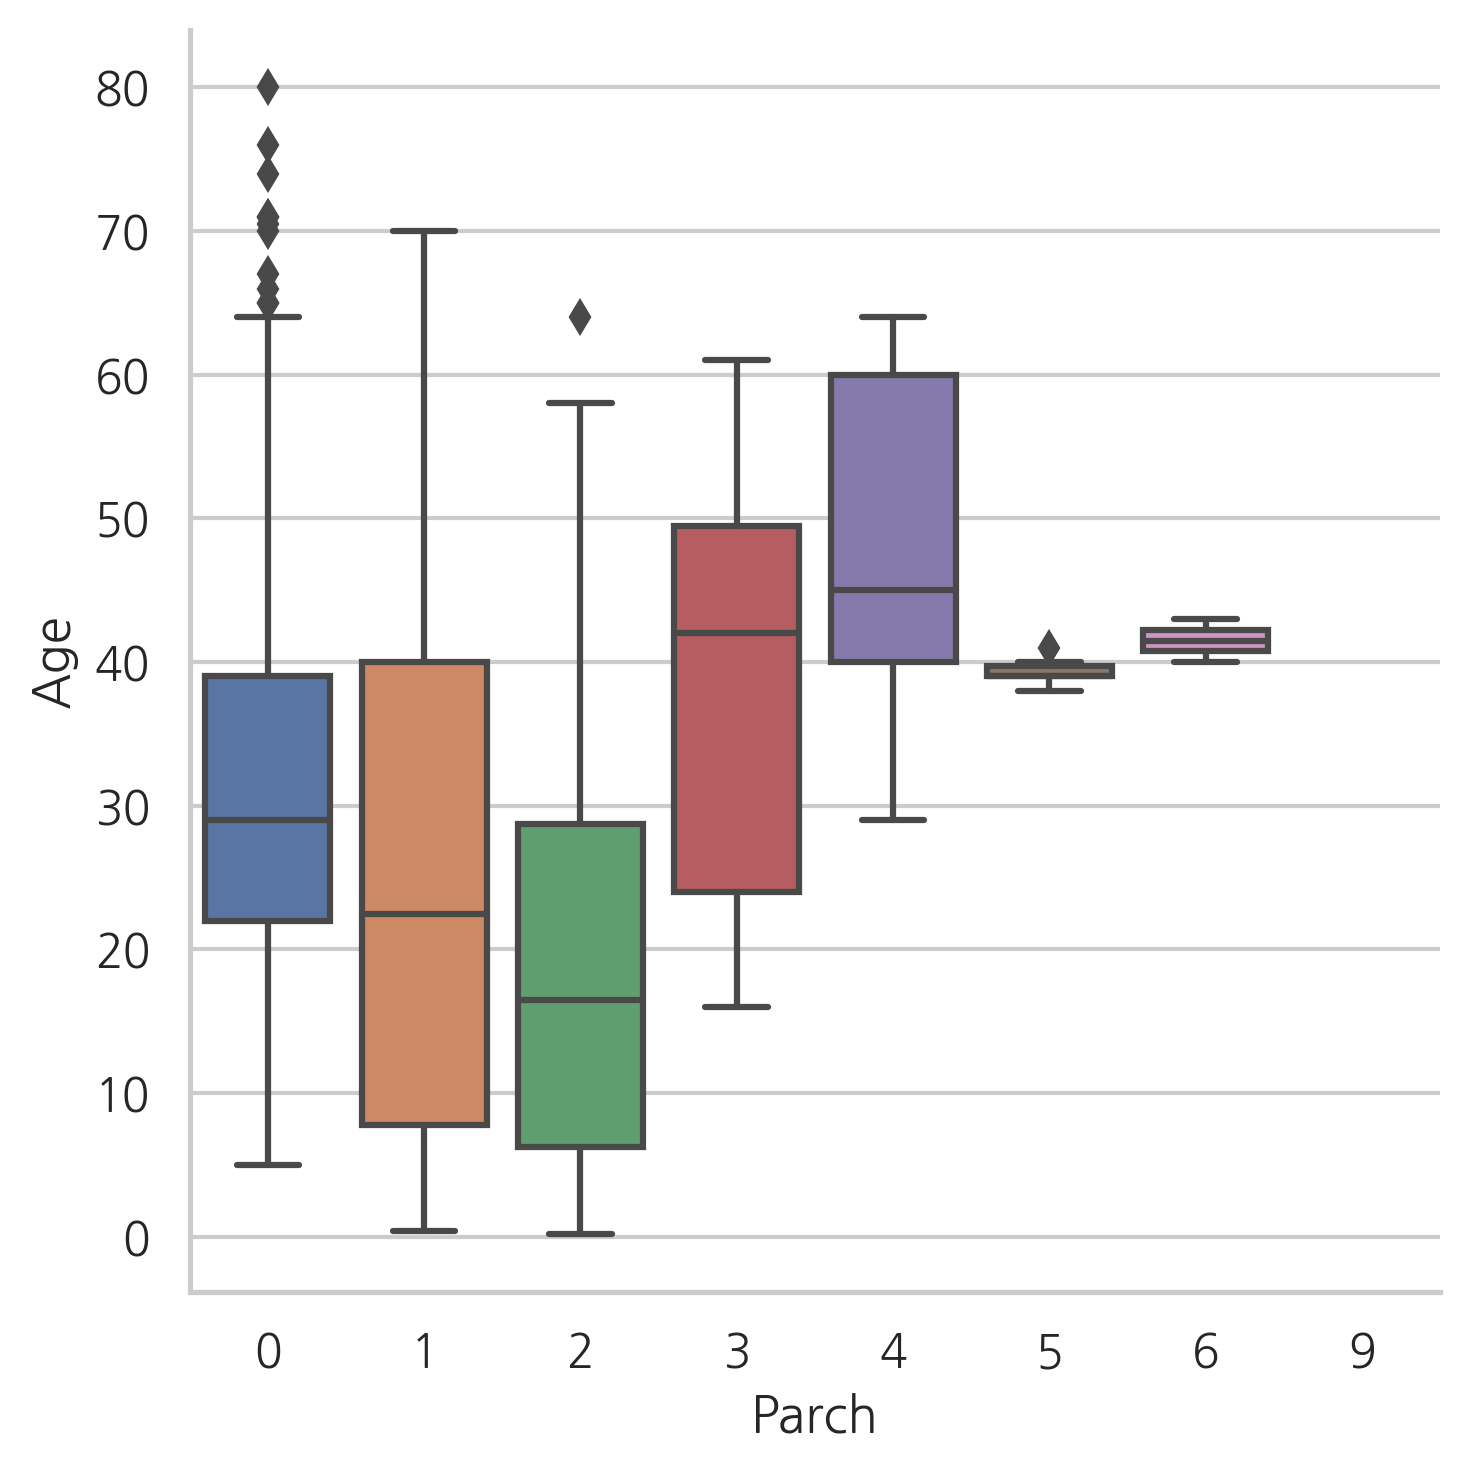

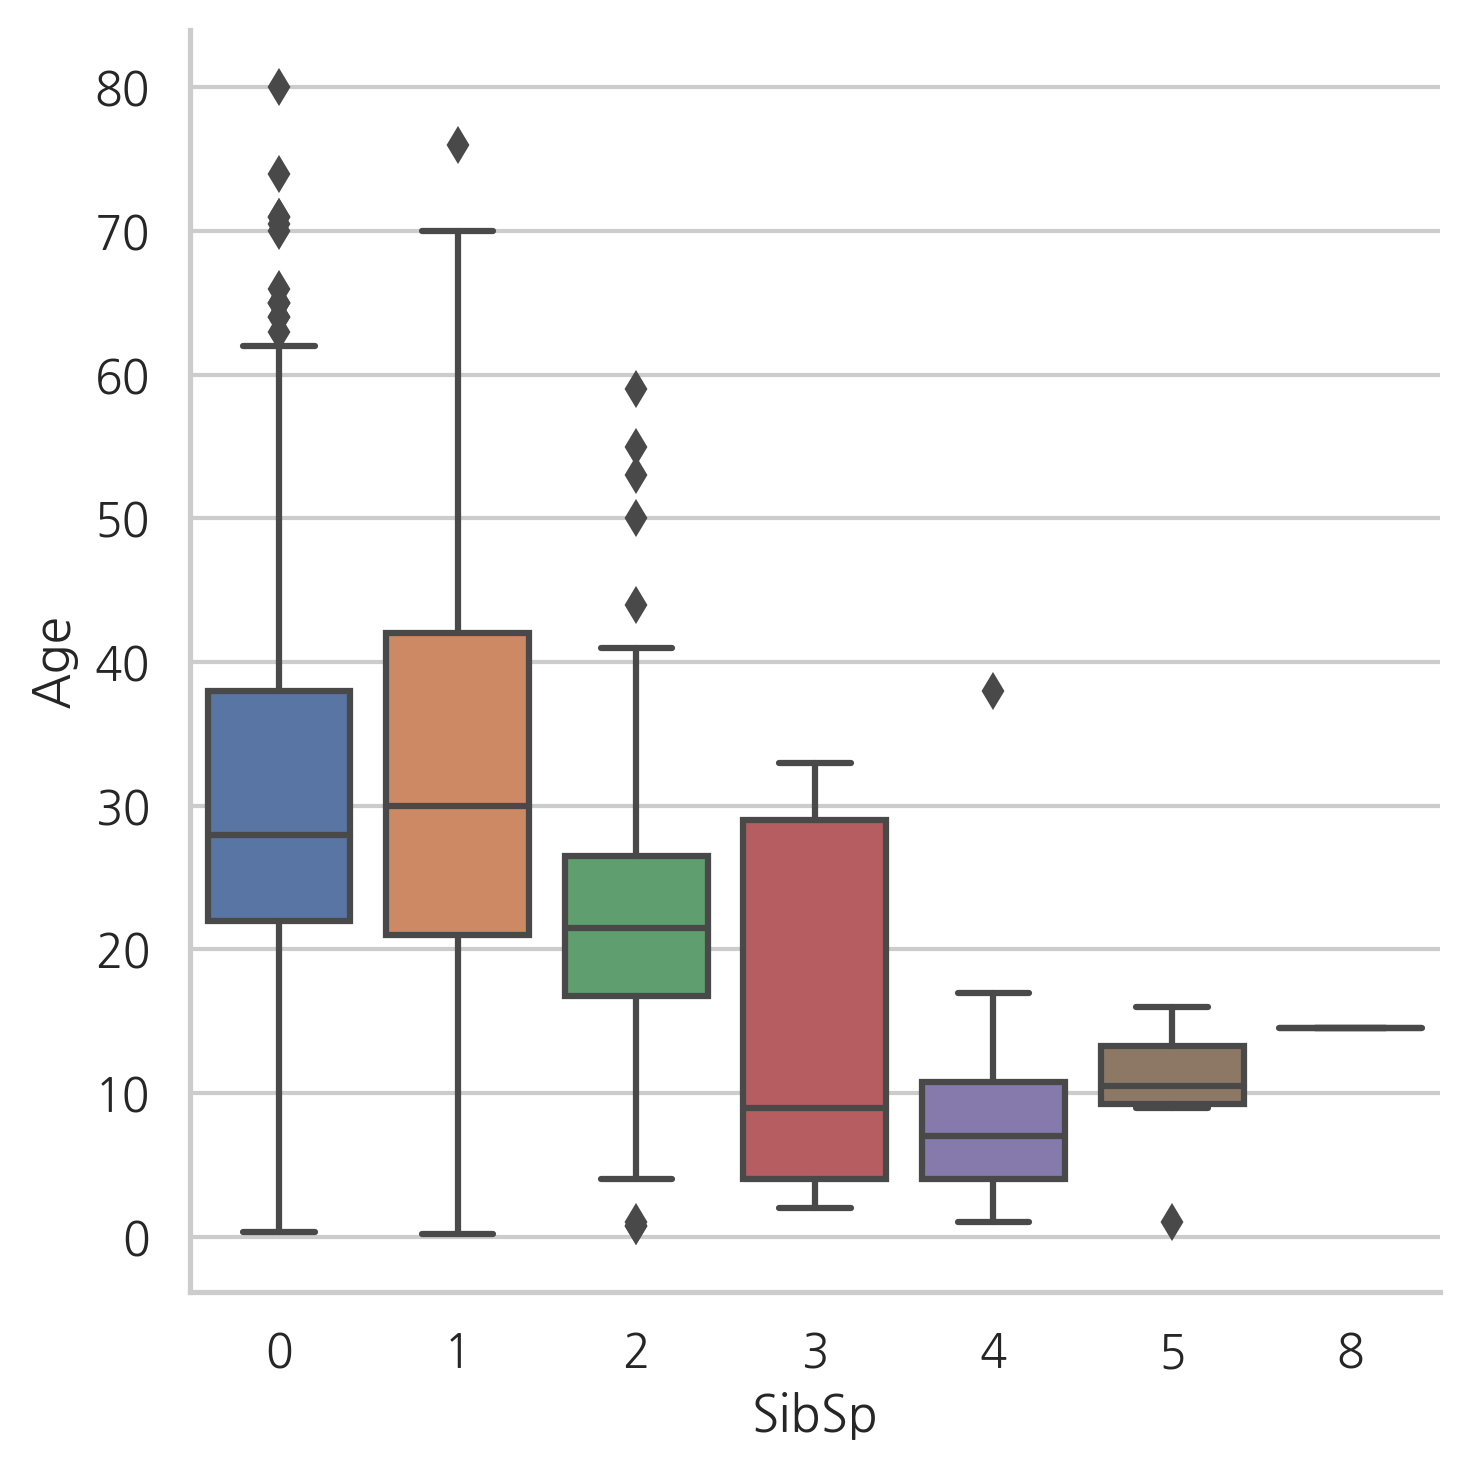

In [31]:
g = sns.factorplot(y="Age", x="Sex", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Parch", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="SibSp", data=dataset, kind="box")

Age의 분포는 남성과 여성의 분포와 비슷해 보인다. 따라서, 성별은 Age를 예측하는데 있어서 유익하지 않다.

1등석 승객은 2등석 승객보다, 2등석 승객은 3등석 승객보다 나이대가 높다.

Parch의 수가 많을수록 나이가 더 많고, SibSp의 수가 많을수록 승객의 나이가 어리다.

In [32]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

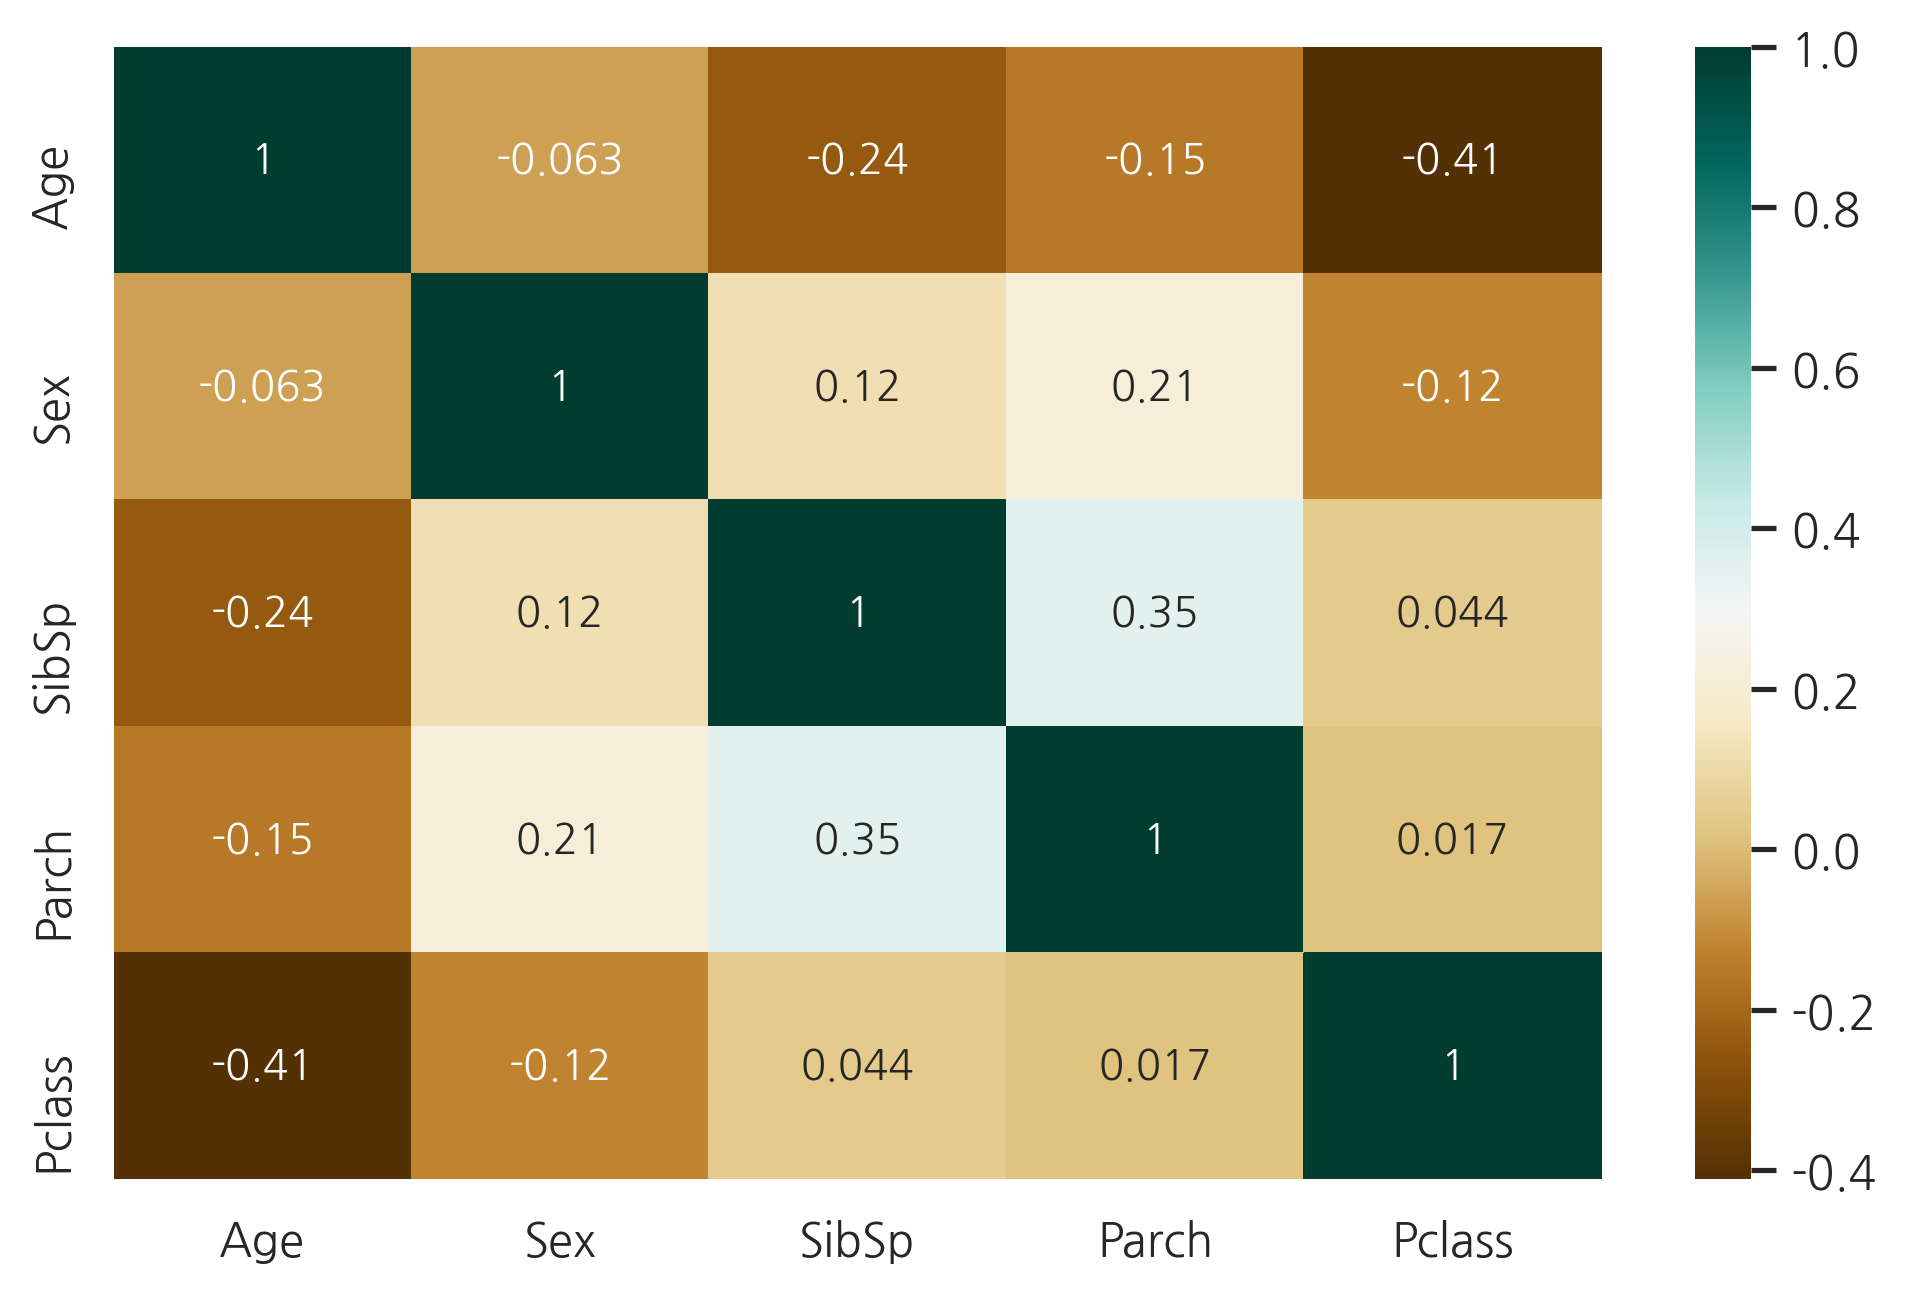

In [33]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),
                cmap="BrBG", annot=True)

Age는 Sex와 상관관계가 거의 없다. 하지만, Pclass, Parch, SibSp와 음의 상관관계를 가진다.

위의 3번째 그래프에선 Parch의 수가 증가함에 따라 Age도 증가하는 것처럼 보인다. 하지만, 전체적인 상관관계는 음의 상관관계를 가진다.

그래서, 결측치를 다른값으로 바꾸기 위하여 SibSP, Parch, Pclass를 사용한다. 이 세가지 칼럼과 비슷한 행들의 Age의 중간값을 사용한다.

In [34]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"]) &
                              (dataset["Parch"] == dataset.iloc[i]["Parch"]) &
                              (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
    
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med

In [35]:
dataset["Age"].isnull().sum()

0

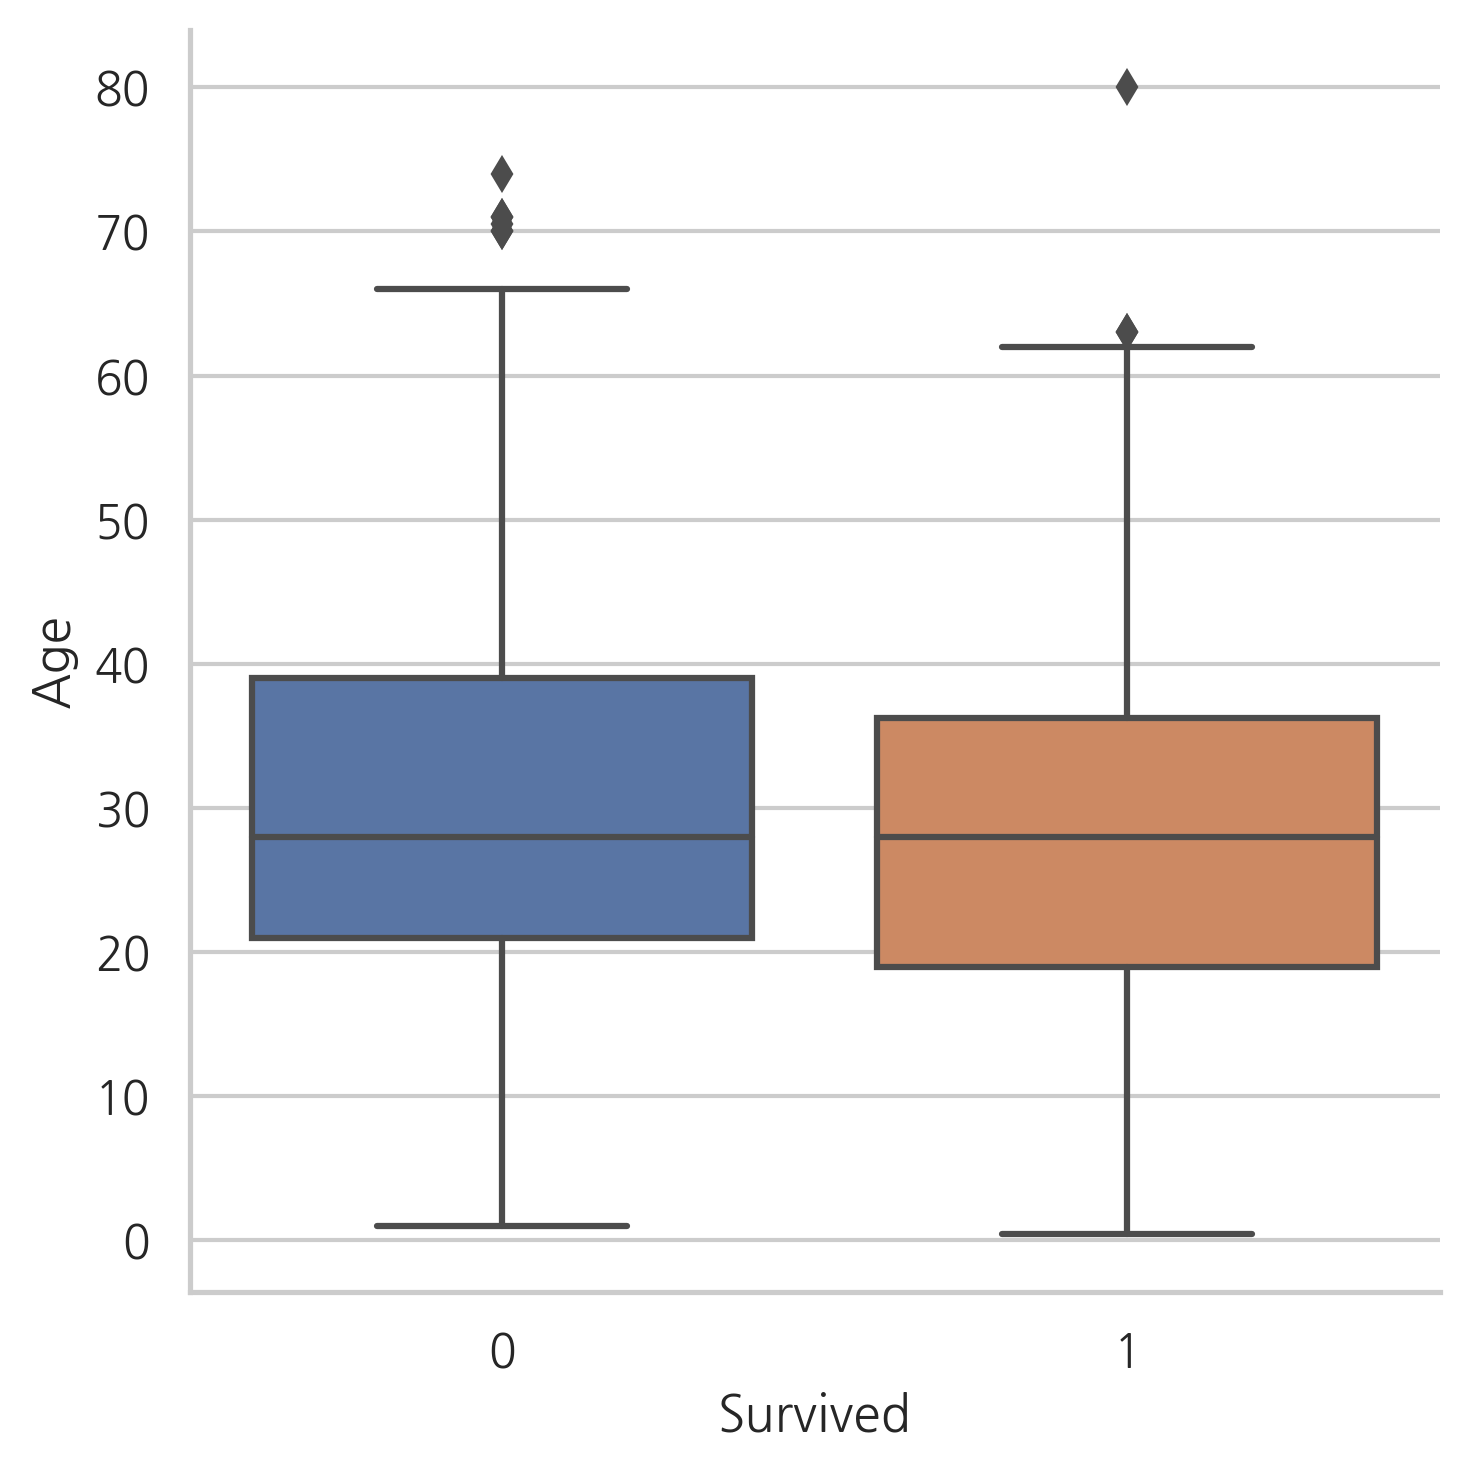

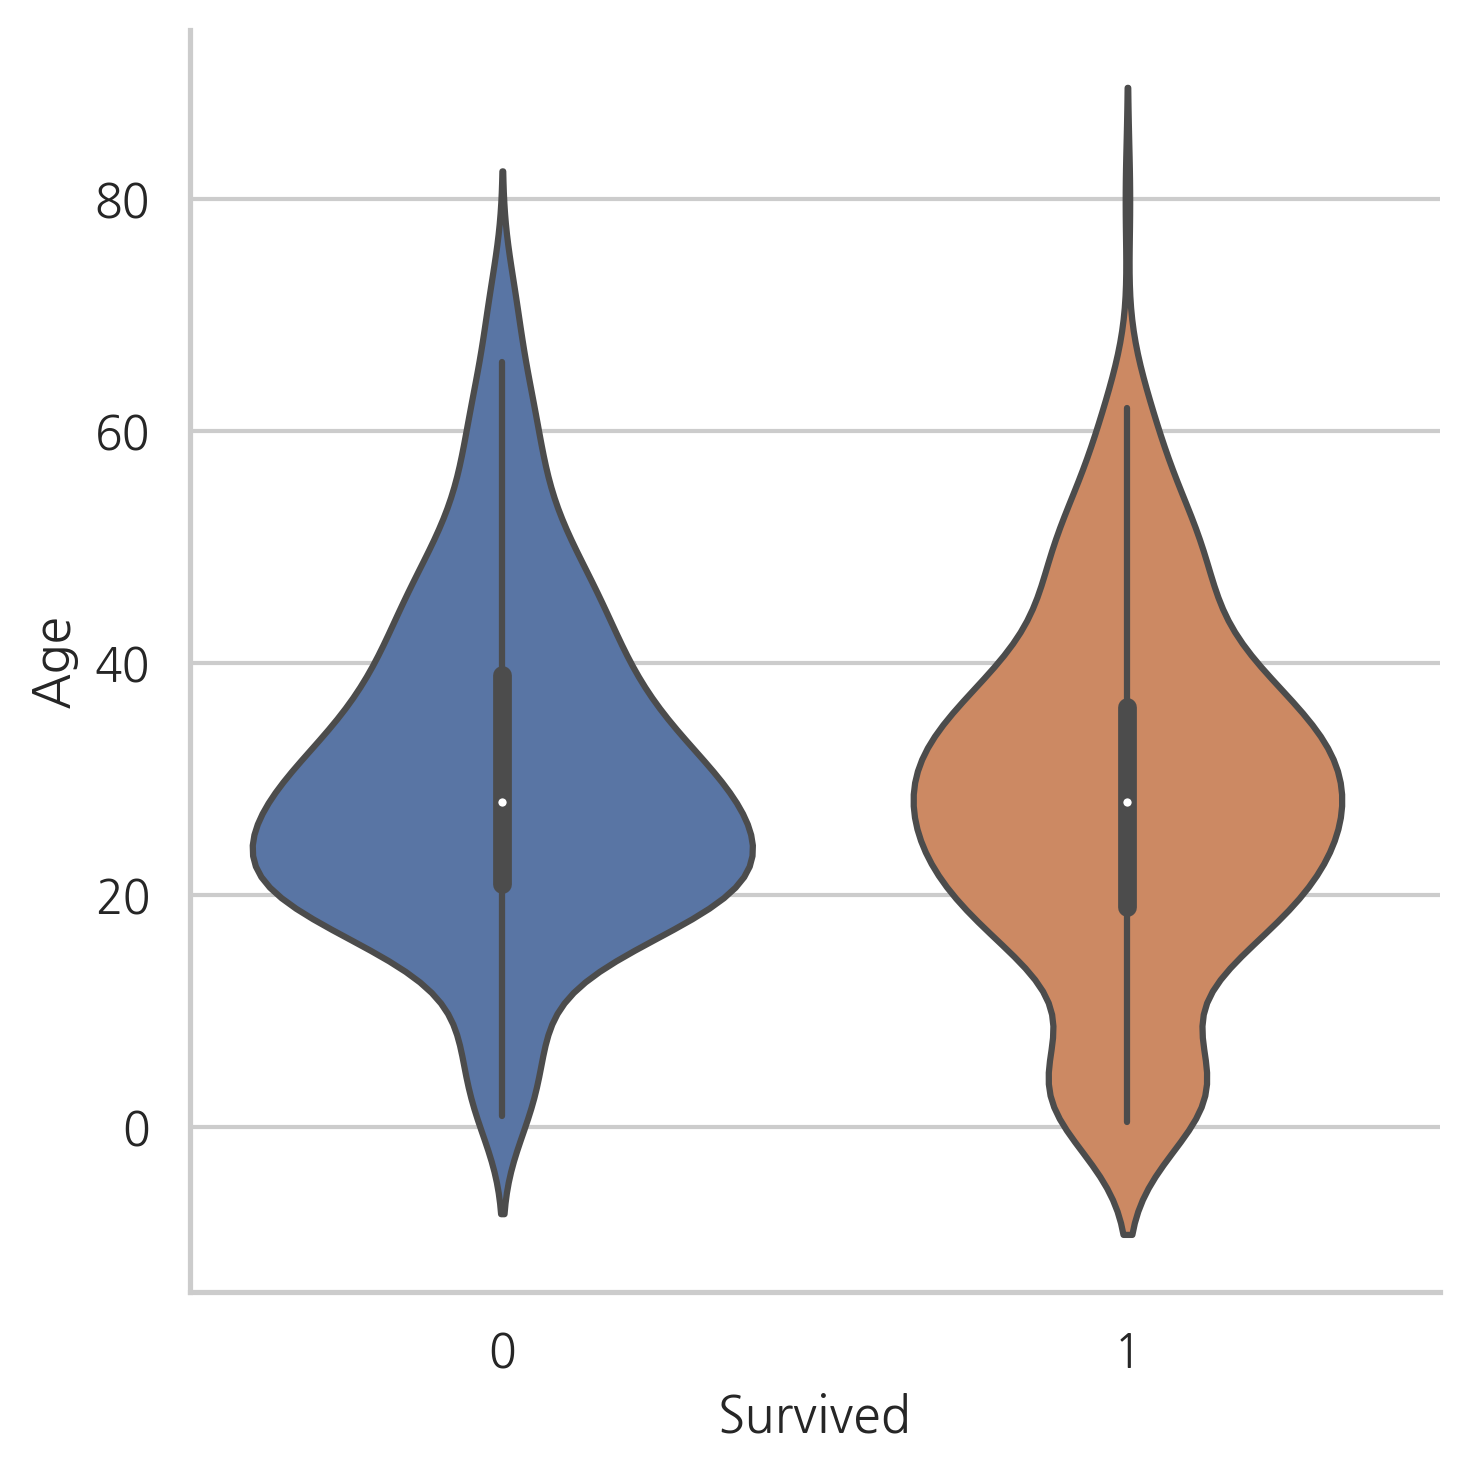

In [36]:
g = sns.factorplot(x="Survived", y="Age", data=train, kind="box")
g = sns.factorplot(x="Survived", y="Age", data=train, kind="violin")

생존자와 사망자의 Age 중간값은 차이가 없다.

하지만, 바이올린 플롯에서는 나이가 아주 어린 승객이 높은 생존률을 가진다는 것을 눈치챌 수 있다.

-------------
## 5. Feature engineering
### 5.1 Name/Title

In [37]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name feature는 탑승객의 호칭에 대한 정보를 담고 있다.

몇몇 탑승객의 호칭은 탈출 시에 더 선호되었을 것이다.

In [38]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

['Capt' 'Col' 'Don' 'Dona' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Master' 'Miss'
 'Mlle' 'Mme' 'Mr' 'Mrs' 'Ms' 'Rev' 'Sir' 'the Countess']


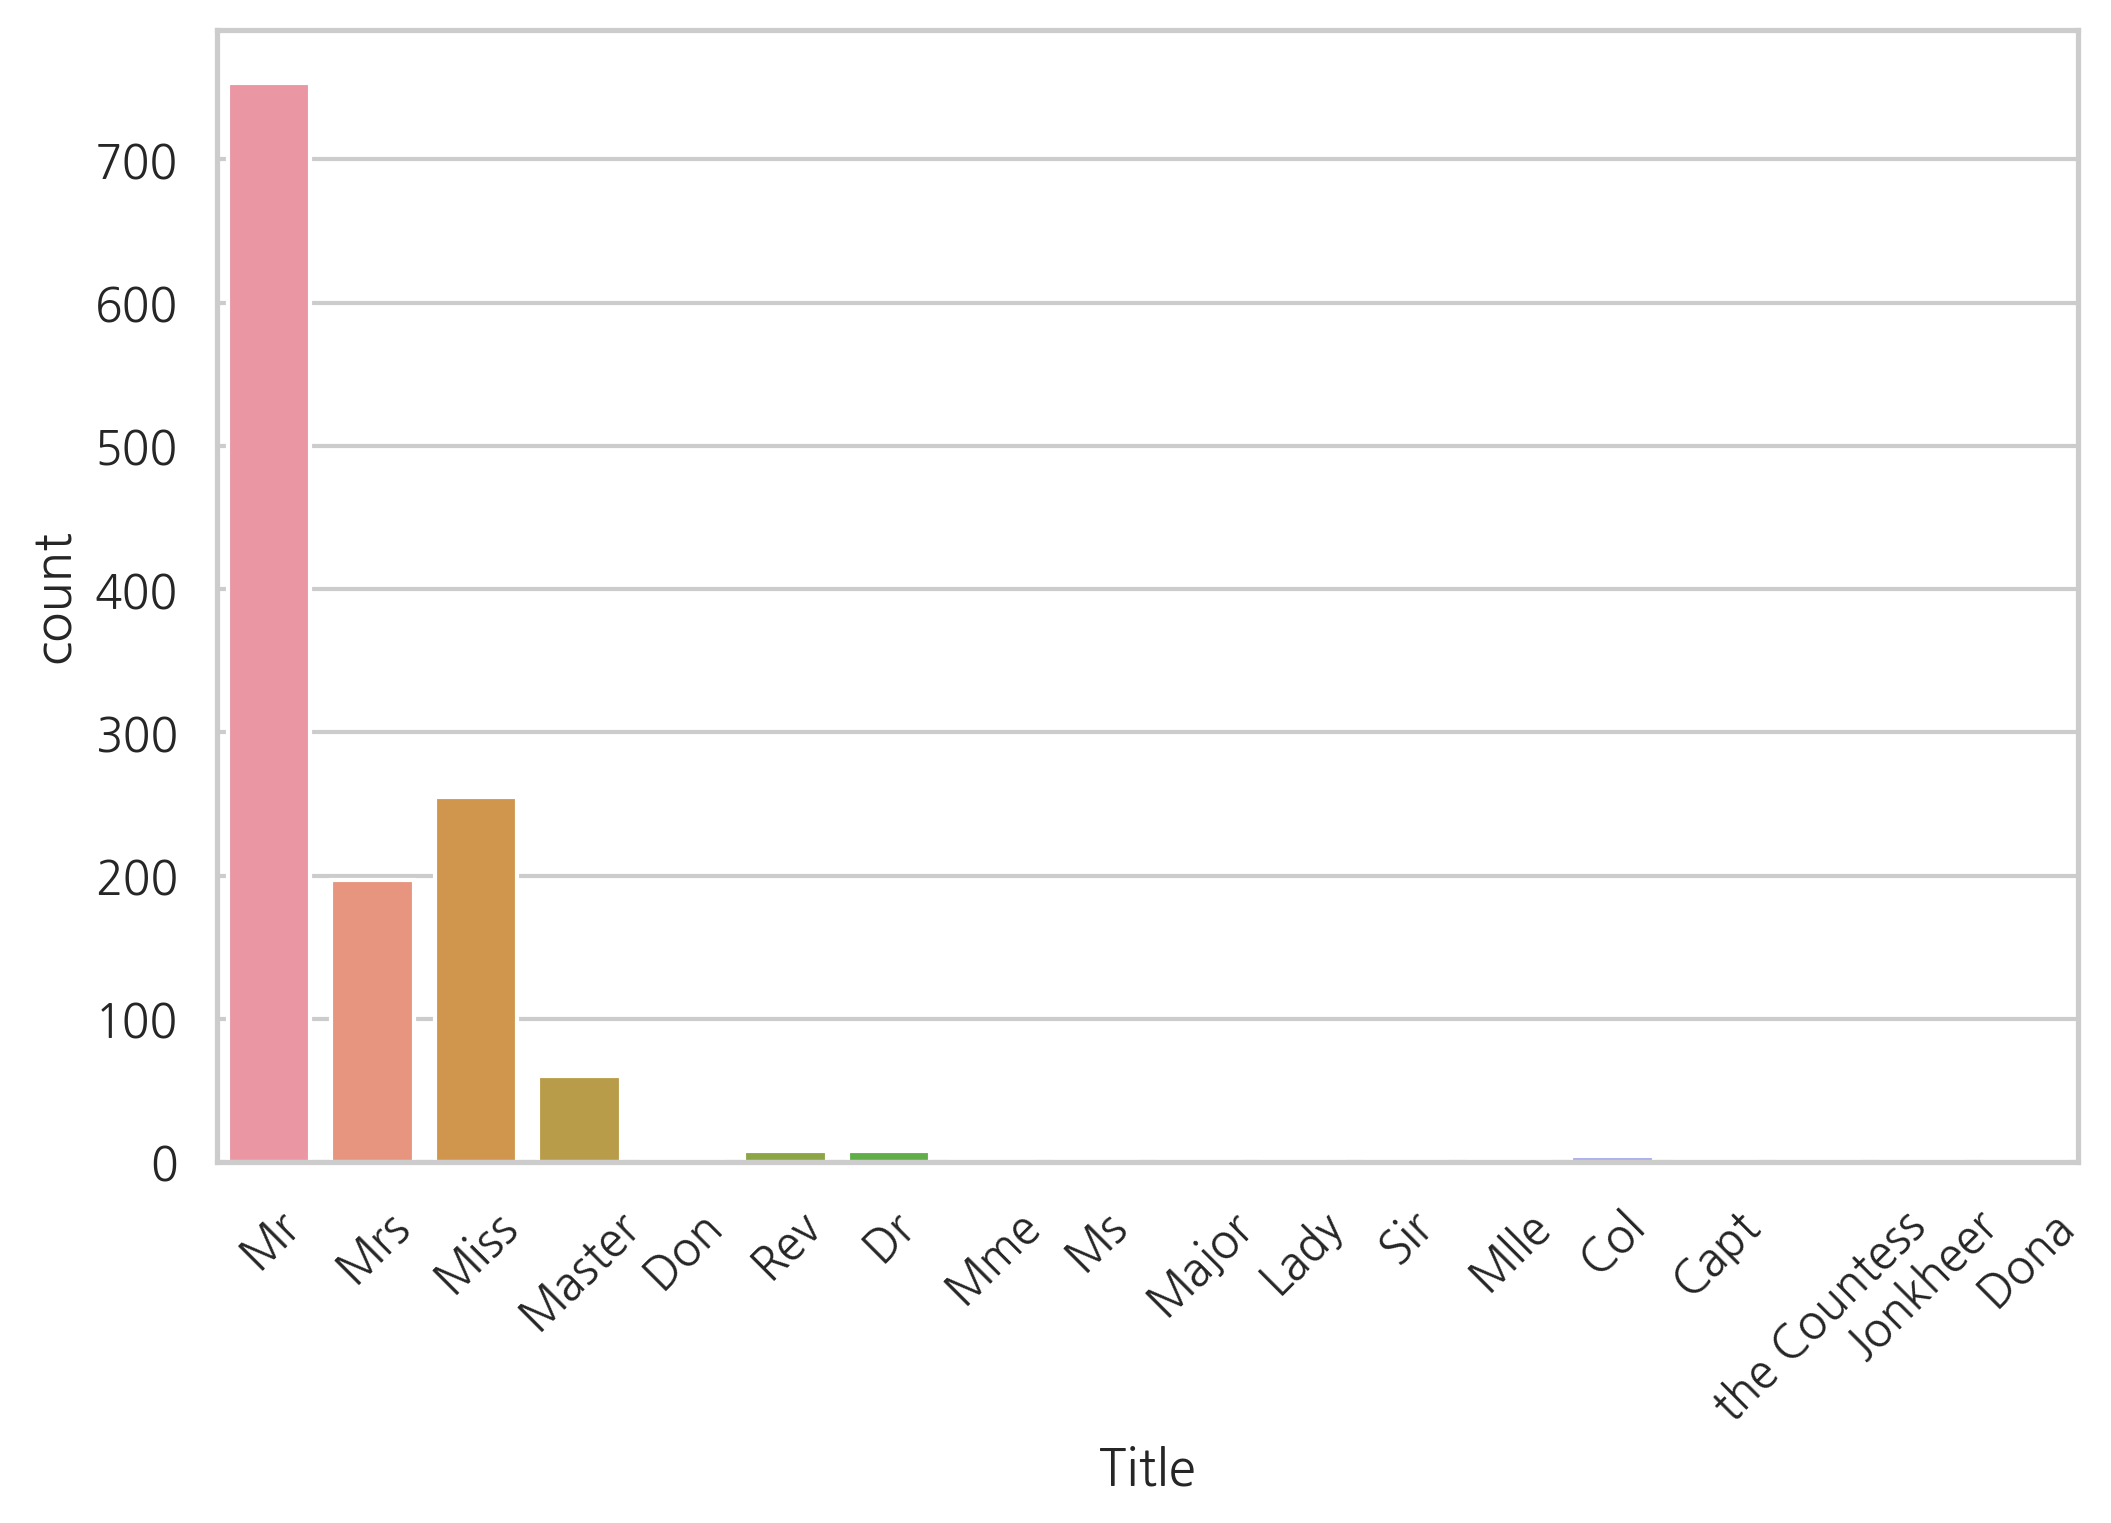

In [39]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)
print(np.unique(dataset["Title"]))

데이터 세트에는 17개의 호칭이 있다. 대부분의 경우 빈도수가 매우 드물고, 4개의 카테고리 정도로 그룹화할 수 있다.

In [40]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 
                                             'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1,
                                         "Mlle": 1, "Mrs":1, "Mr": 2, "Rare": 3})
dataset["Title"] = dataset["Title"].astype(int)

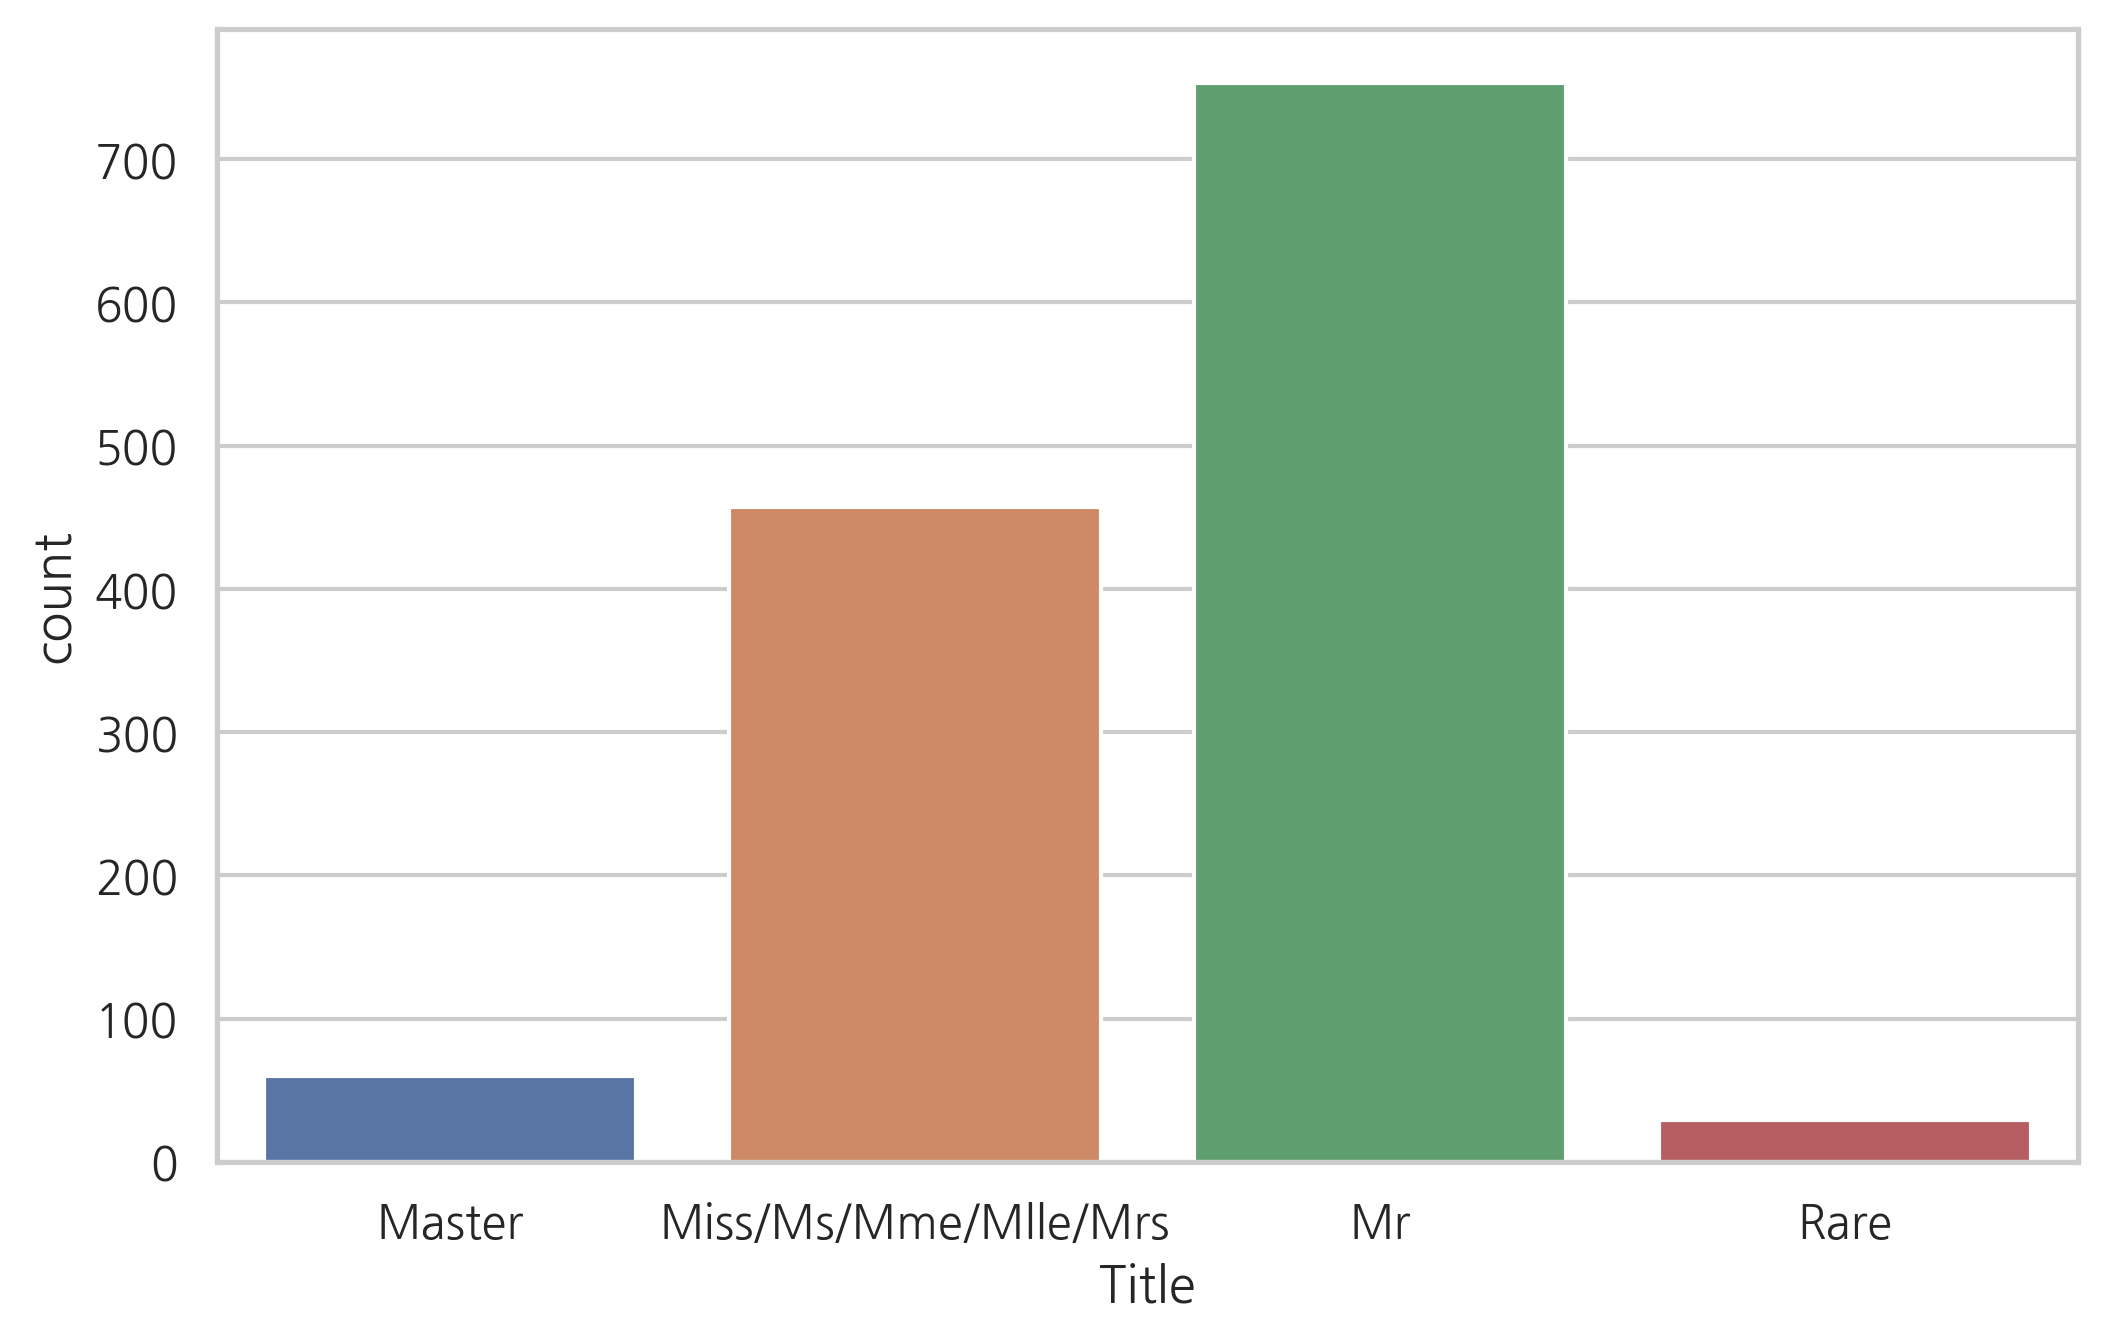

In [41]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

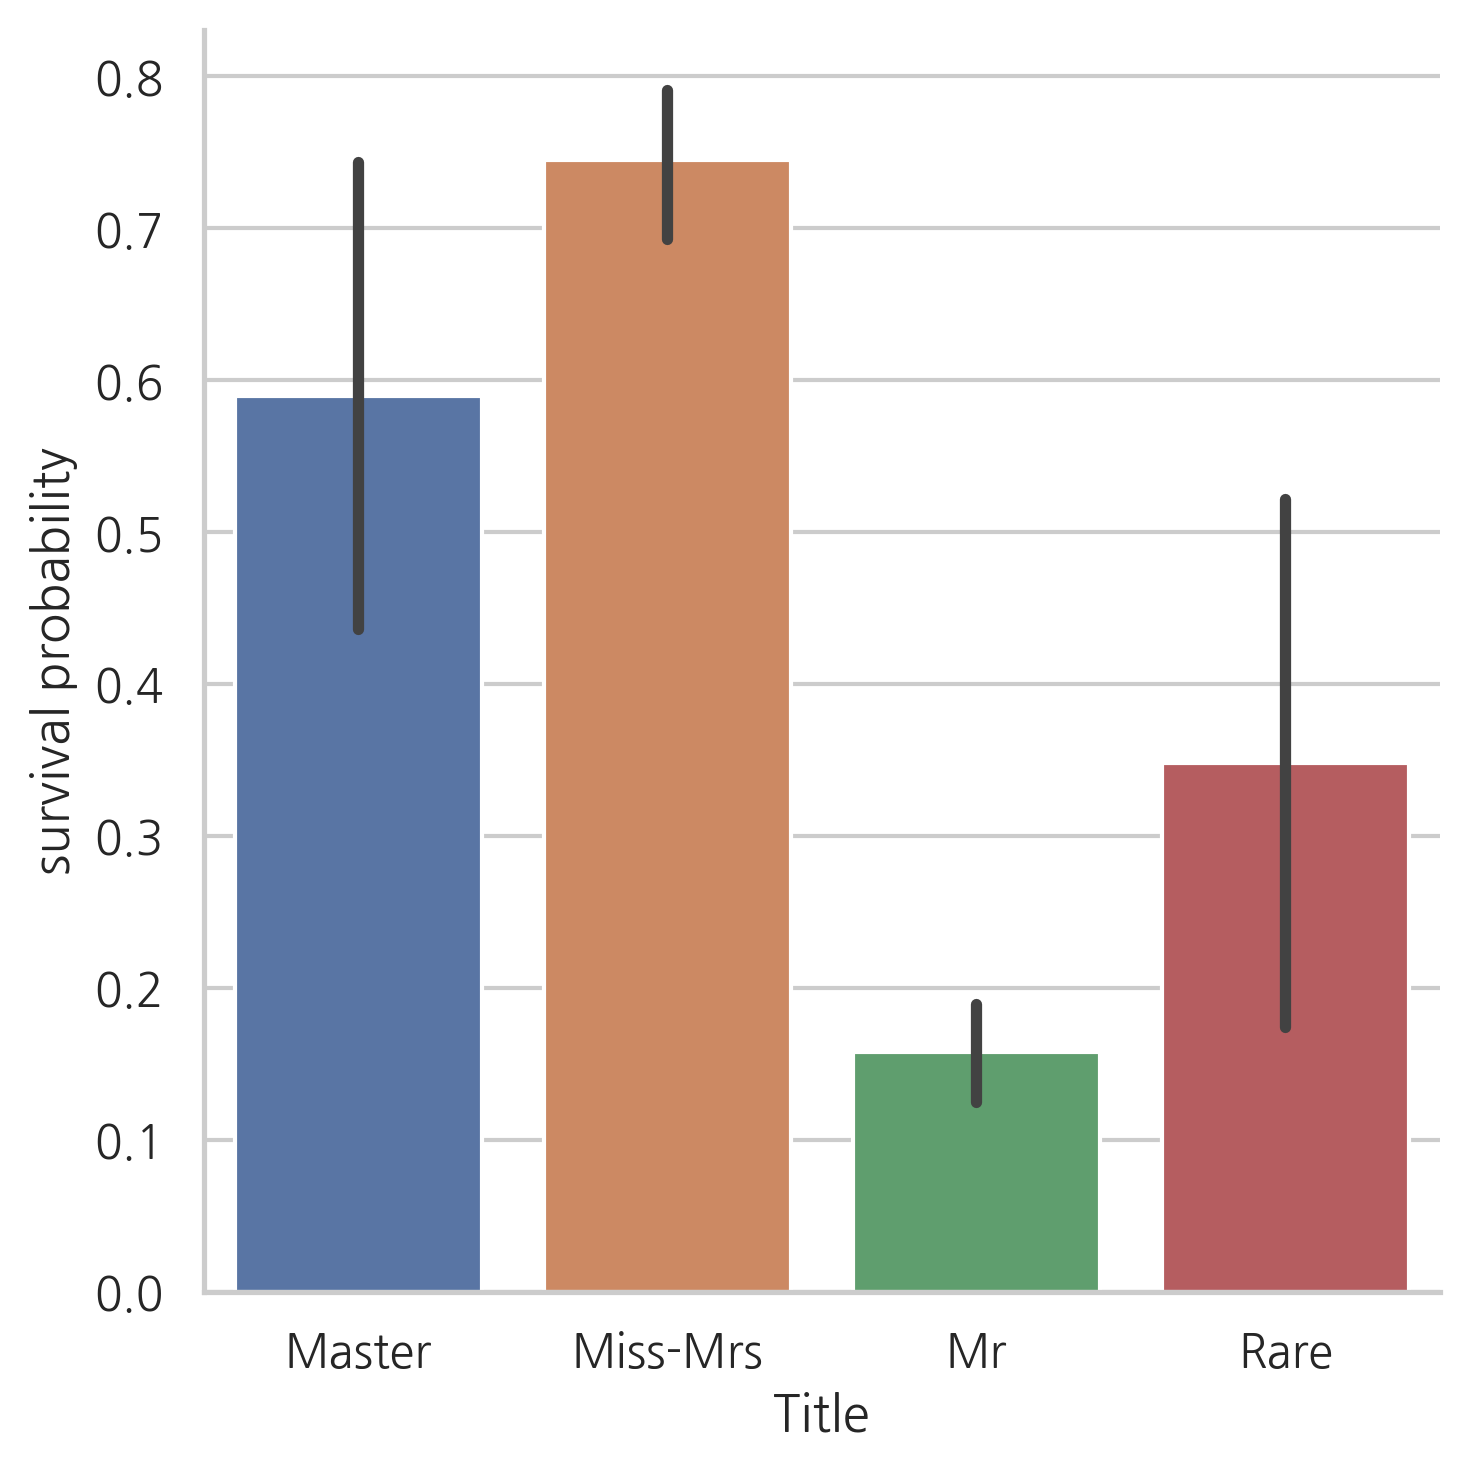

In [42]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

여성과 아이들의 생존률이 높으며, Rare로 분류된 탑승객의 생존 가능성이 높은 것이 눈에 띕니다.

In [43]:
# Name feature은 제거
dataset.drop(labels=["Name"], axis=1, inplace=True)

### 5.2 Family size

함께 탑승한 가족의 수에 따라서 탈출하는 어려움이 달랐을 것입니다. 따라서, SibSp와 Parch 그리고 +1(본인 포함)을 해줘 Fize(family size) feature을 생성해줍니다.

In [44]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

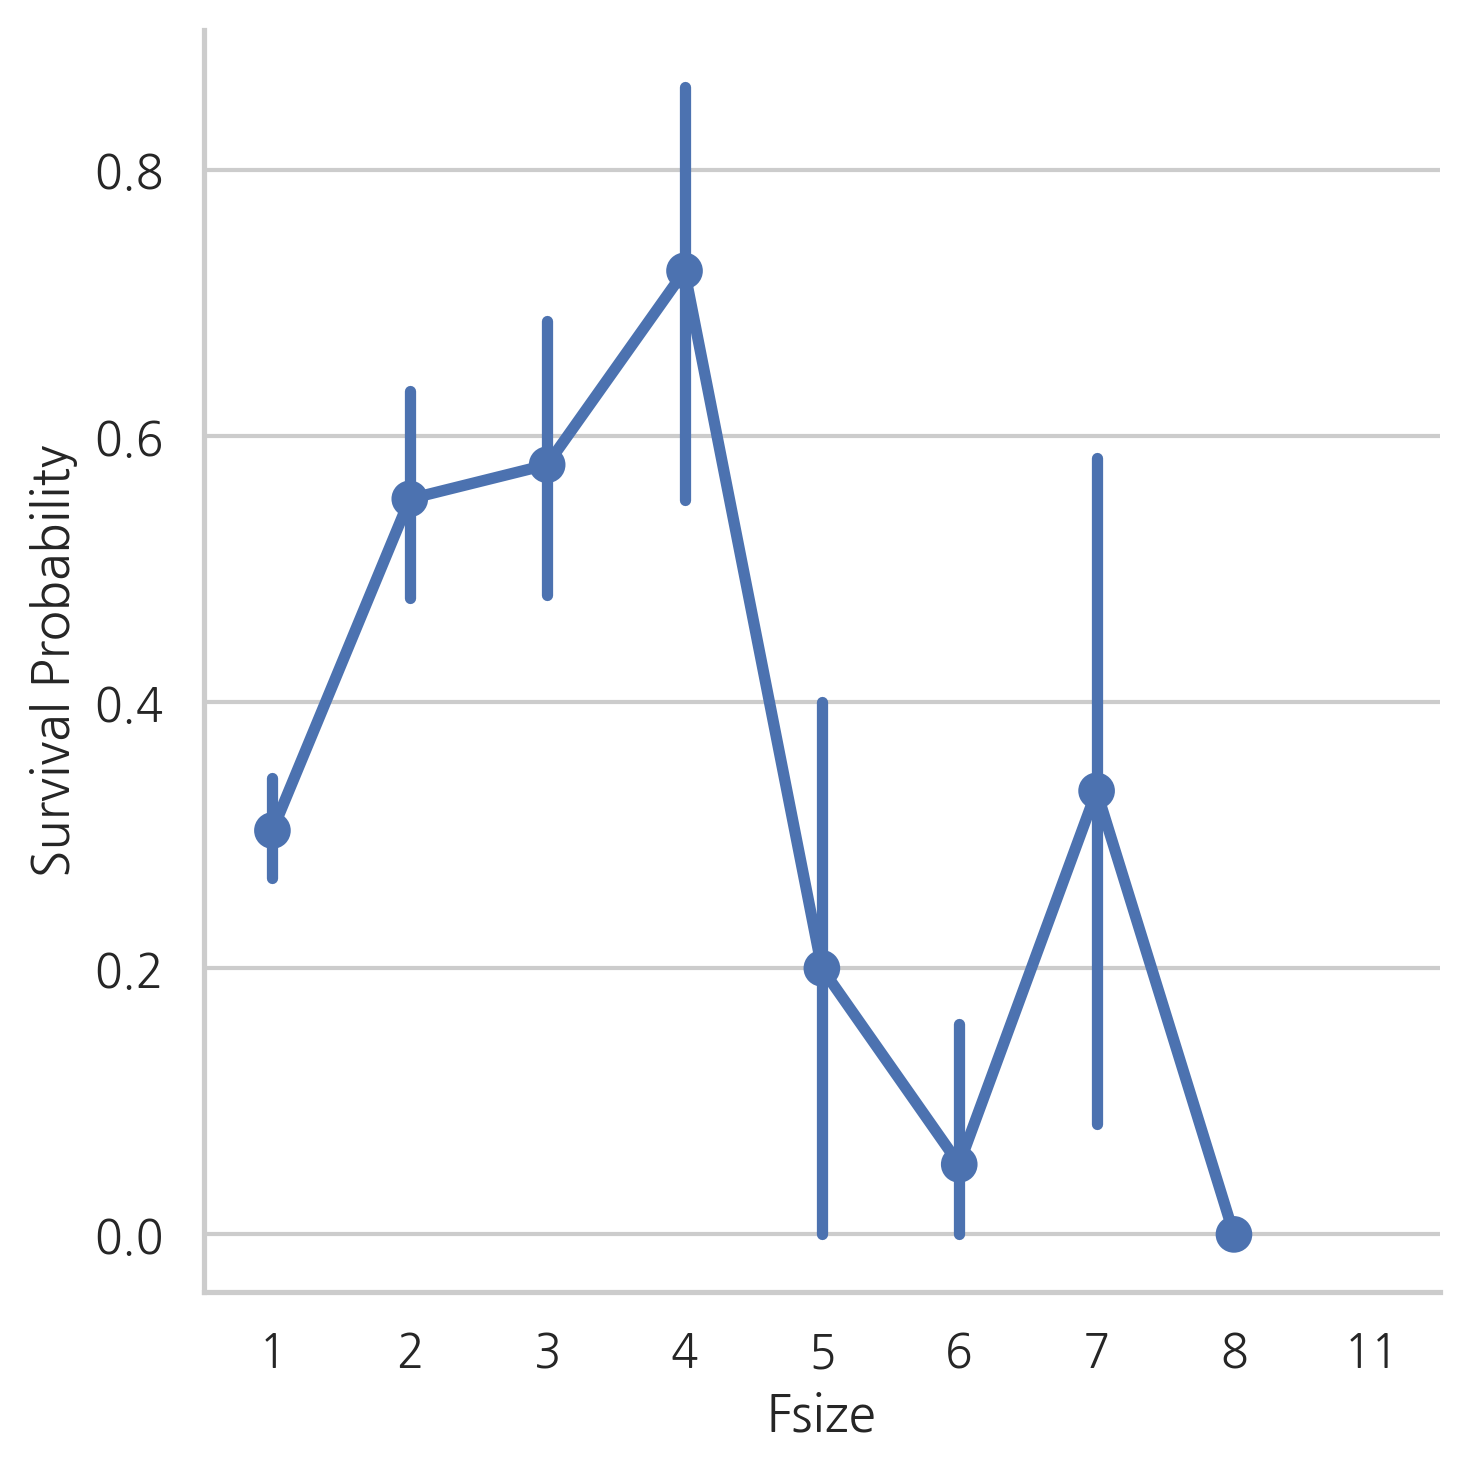

In [45]:
g = sns.factorplot(x="Fsize", y="Survived", data=dataset)
g = g.set_ylabels("Survival Probability")

Fsize는 모델을 예측하는데 중요한 역할을 할 것 같아 보입니다. 대가족인 경우, 생존률이 낮습니다. 가족의 수에 따라 4개의 그룹을 만들겠습니다.

In [46]:
dataset["Single"] = dataset["Fsize"].map(lambda s: 1 if s == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s >= 5 else 0)

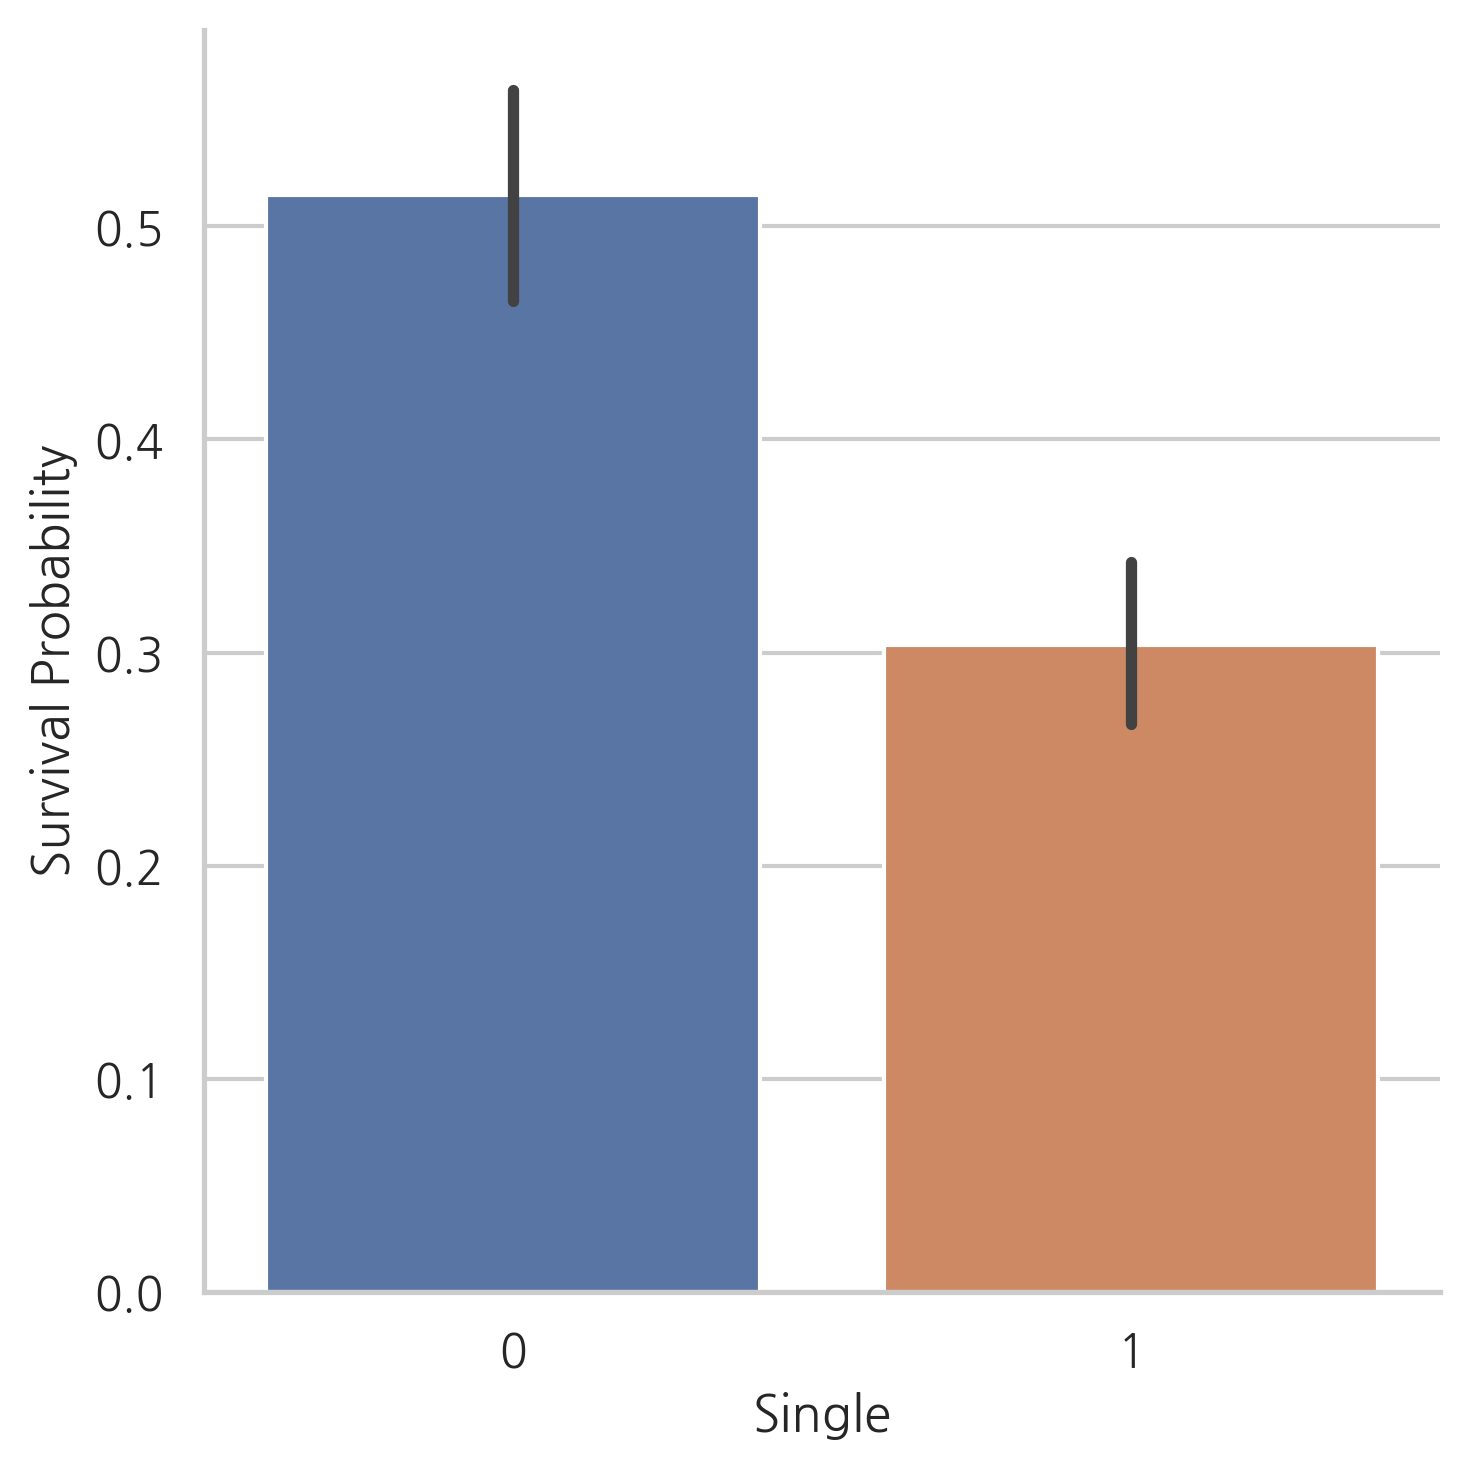

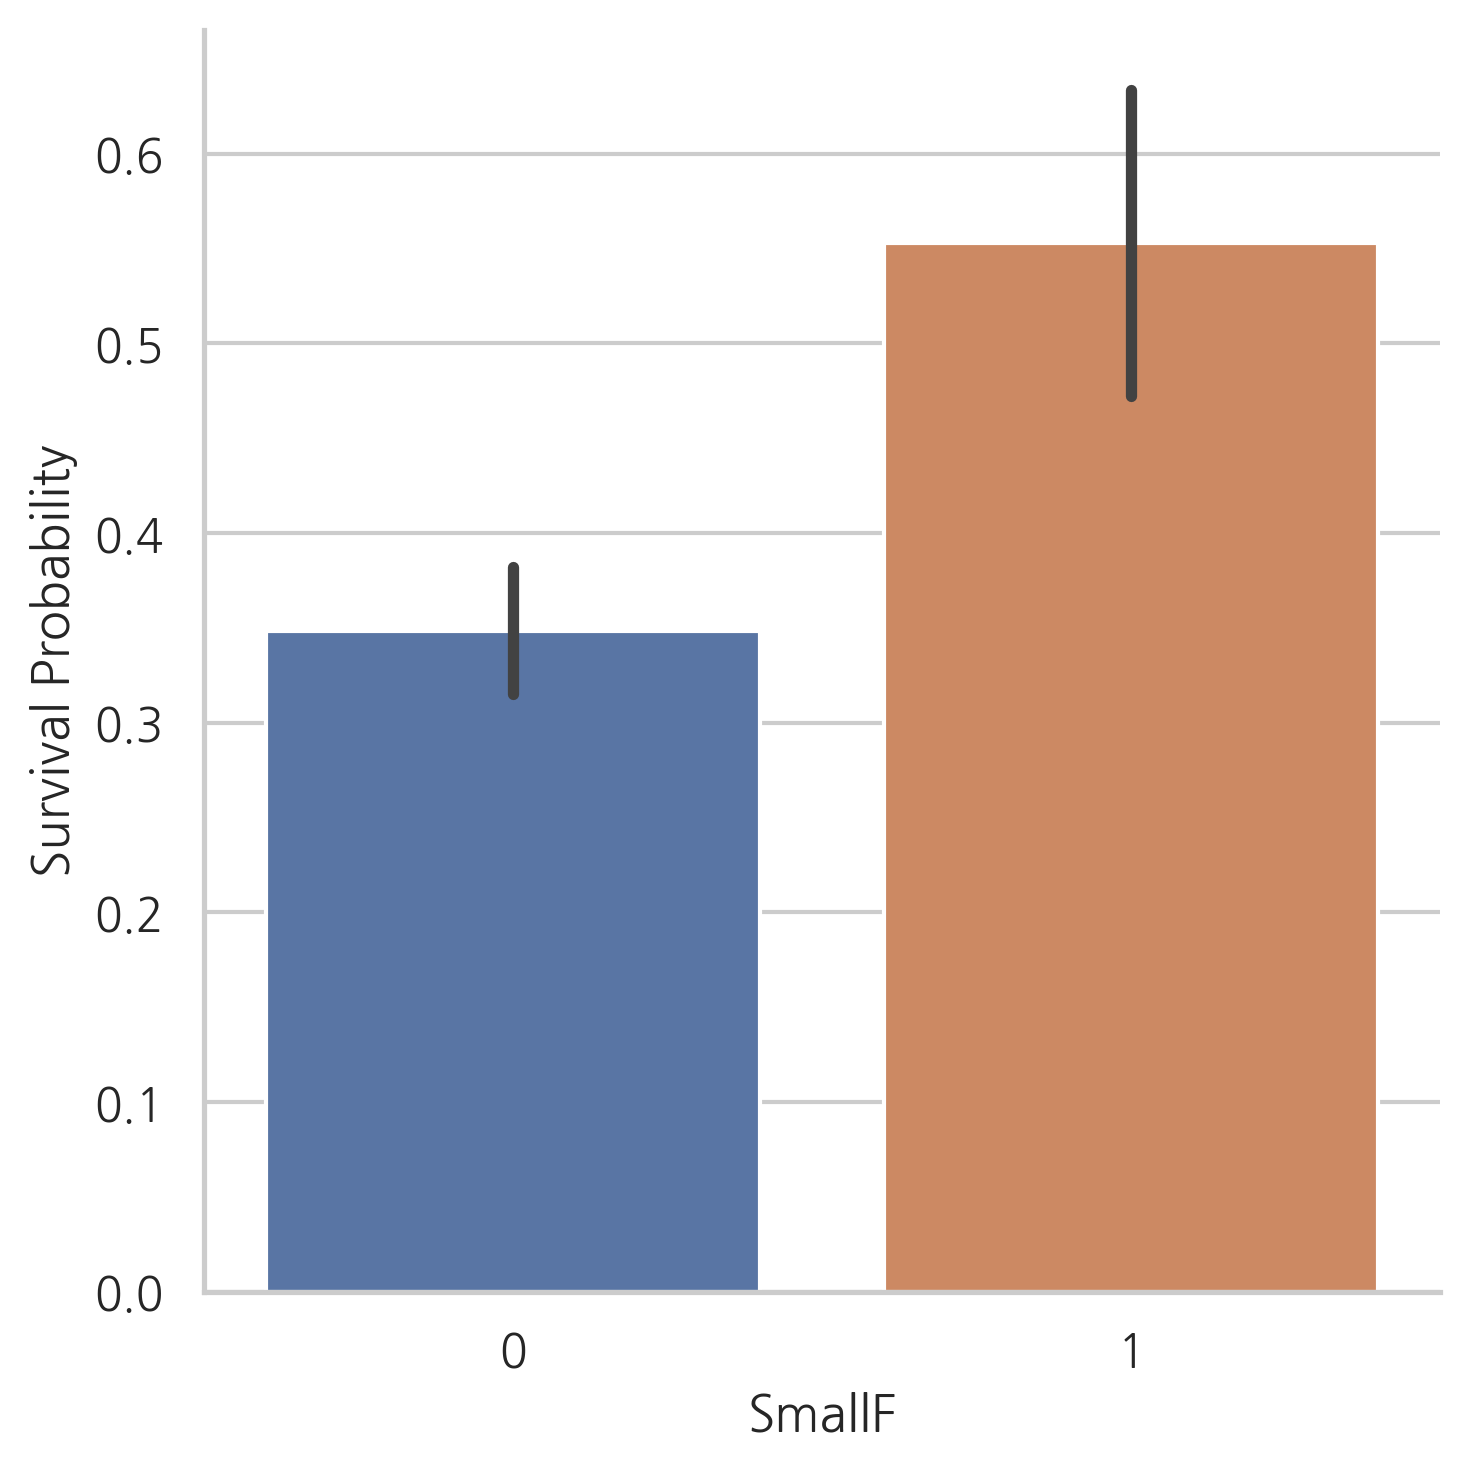

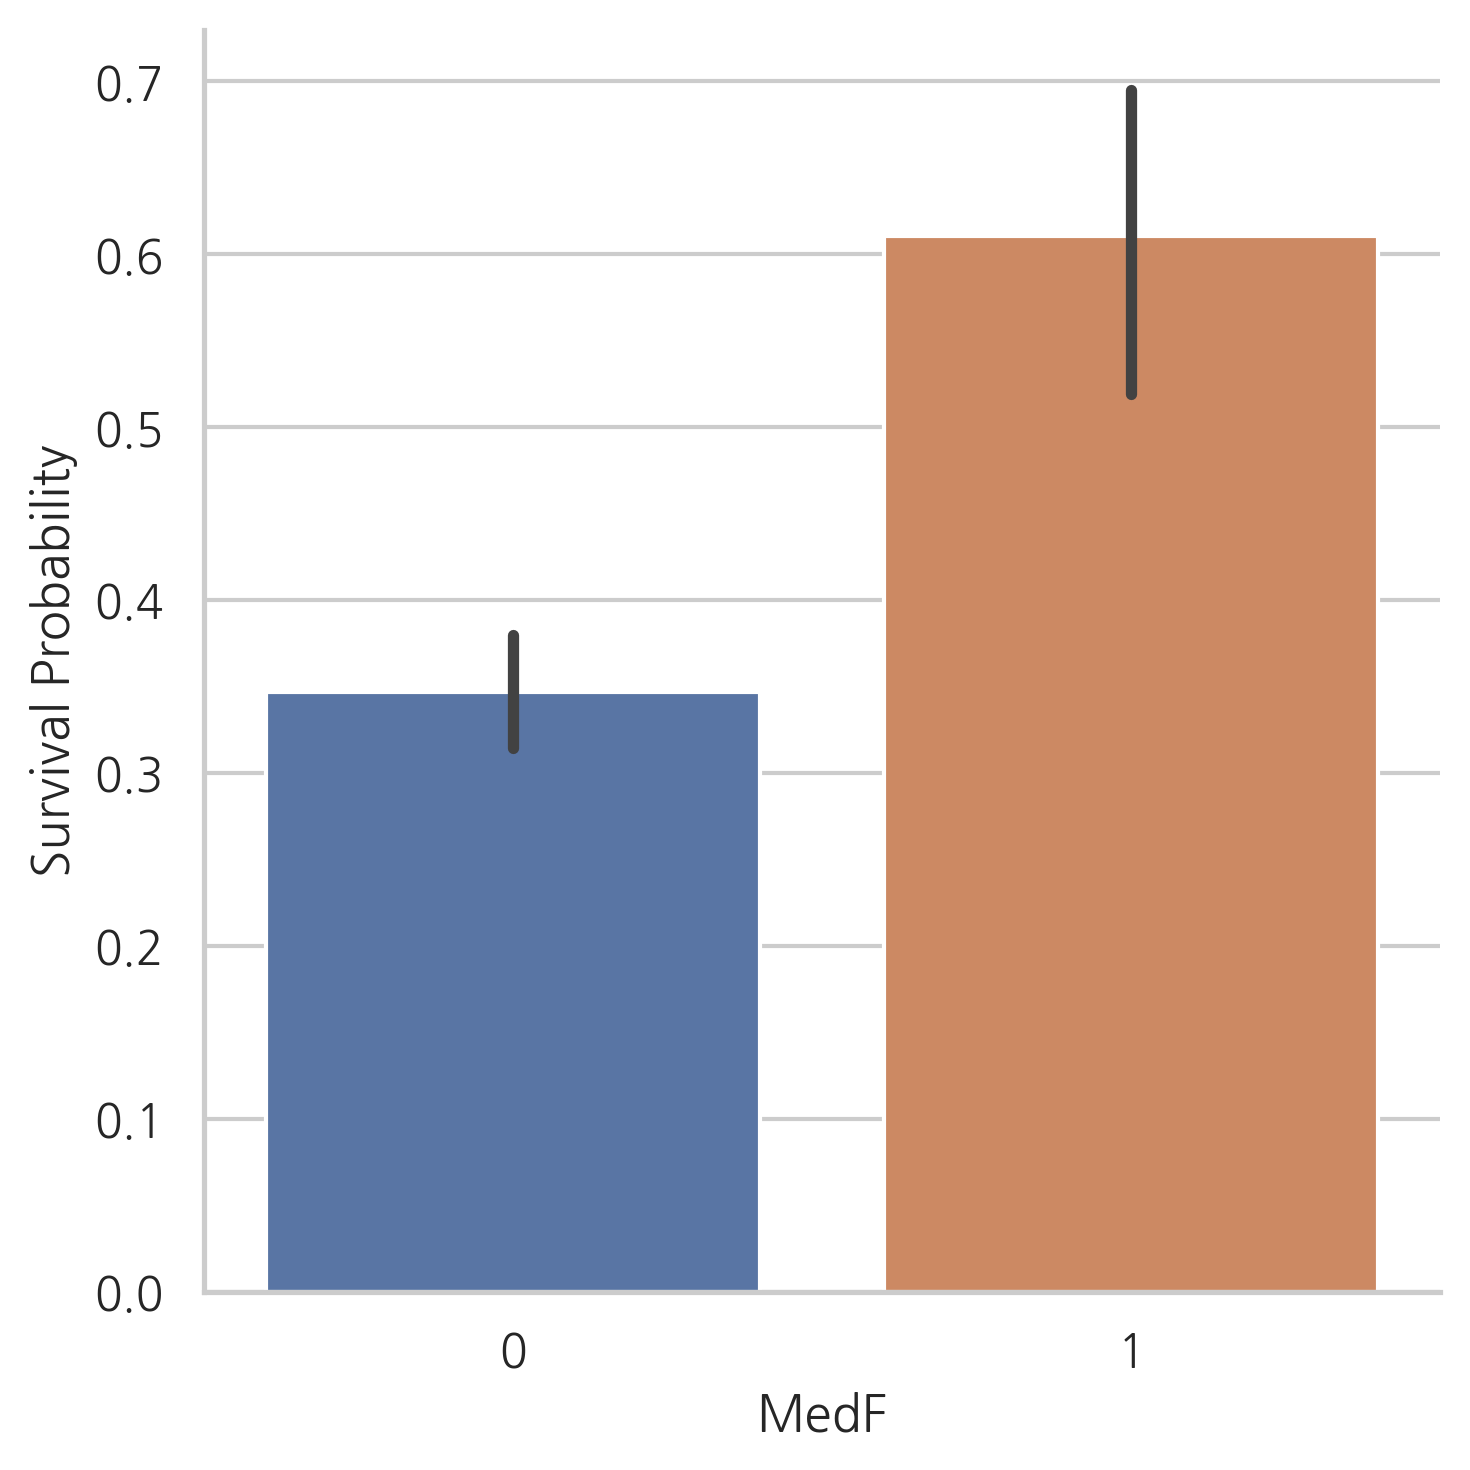

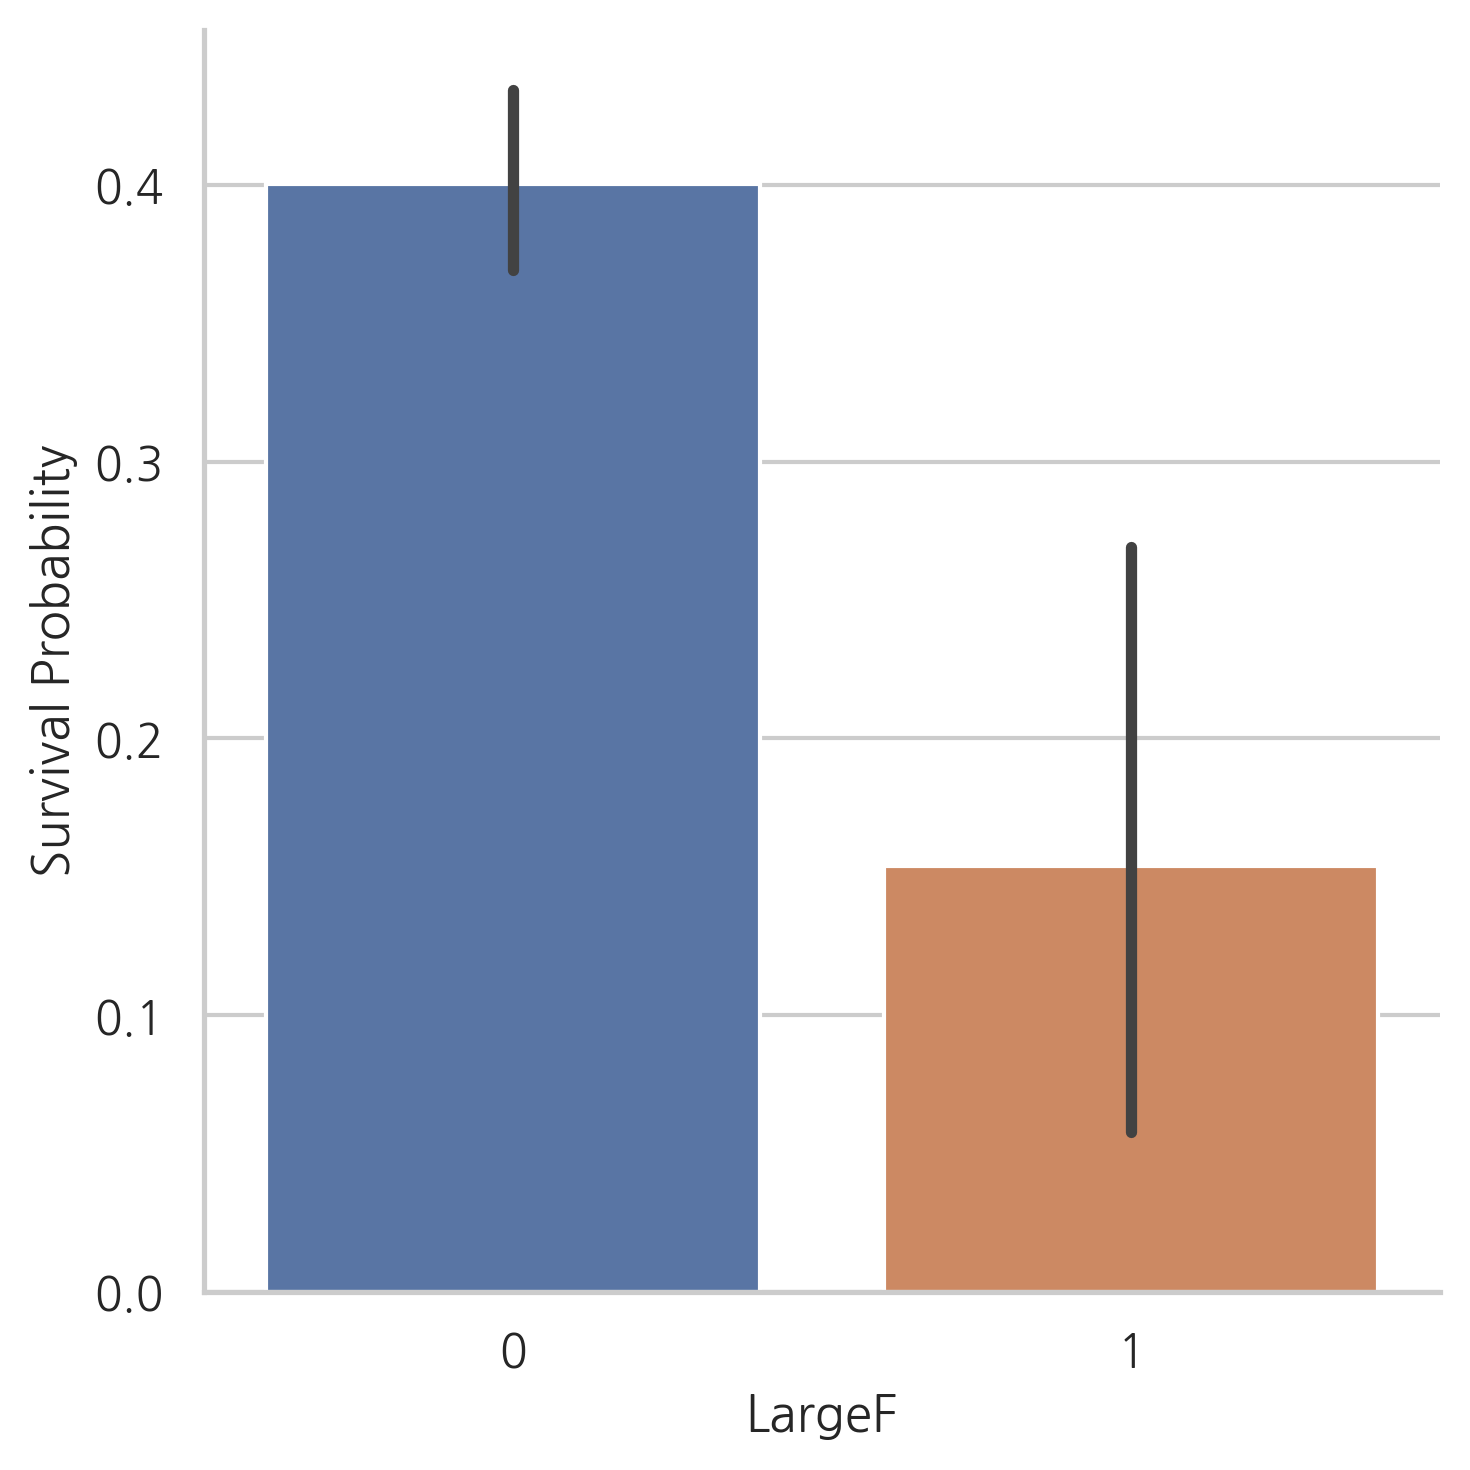

In [47]:
g = sns.factorplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

위의 그래프에서는 혼자 탑승한 승객이나 대가족의 경우보다 적거나 중간 규모의 가족의 생존 가능성이 더 크다는 것을 보여줍니다.

In [48]:
#  Title과 Embarked 칼럼을 one-hot encoding
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [49]:
dataset.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch            Ticket  \
0            1       0.0       3    0  22.0      1      0         A/5 21171   
1            2       1.0       1    1  38.0      1      0          PC 17599   
2            3       1.0       3    1  26.0      0      0  STON/O2. 3101282   
3            4       1.0       1    1  35.0      1      0            113803   
4            5       0.0       3    0  35.0      0      0            373450   

       Fare Cabin  ...  SmallF  MedF  LargeF  Title_0  Title_1  Title_2  \
0  1.981001   NaN  ...       1     0       0        0        0        1   
1  4.266662   C85  ...       1     0       0        0        1        0   
2  2.070022   NaN  ...       0     0       0        0        1        0   
3  3.972177  C123  ...       1     0       0        0        1        0   
4  2.085672   NaN  ...       0     0       0        0        0        1   

   Title_3  Em_C  Em_Q  Em_S  
0        0     0     0     1  
1        0     1     0     0  
2        0     0     0     1  
3        0     0     0     1  
4        0     0     0     1  

[5 rows x 22 columns]

### 5.3 Cabin

In [50]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [51]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [52]:
dataset["Cabin"].isnull().sum()

1007

Cabin 칼럼은 1007개의 결측치가 있습니다. (결측치가 아닌 개수는 292개)

Cabin이 결측치인 경우, 객실이 없는 탑승객이라고 가정합니다.

In [53]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [54]:
# 객실 번호가 없으면 X로 값을 변경, 있는 경우 맨 앞글자
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else "X" 
                              for i in dataset["Cabin"]])


객실의 첫글자는 데스크를 나타내며, 타이타닉 승객들의 가능한 위치를 나타내기 때문에 앞글자 정보를 유지

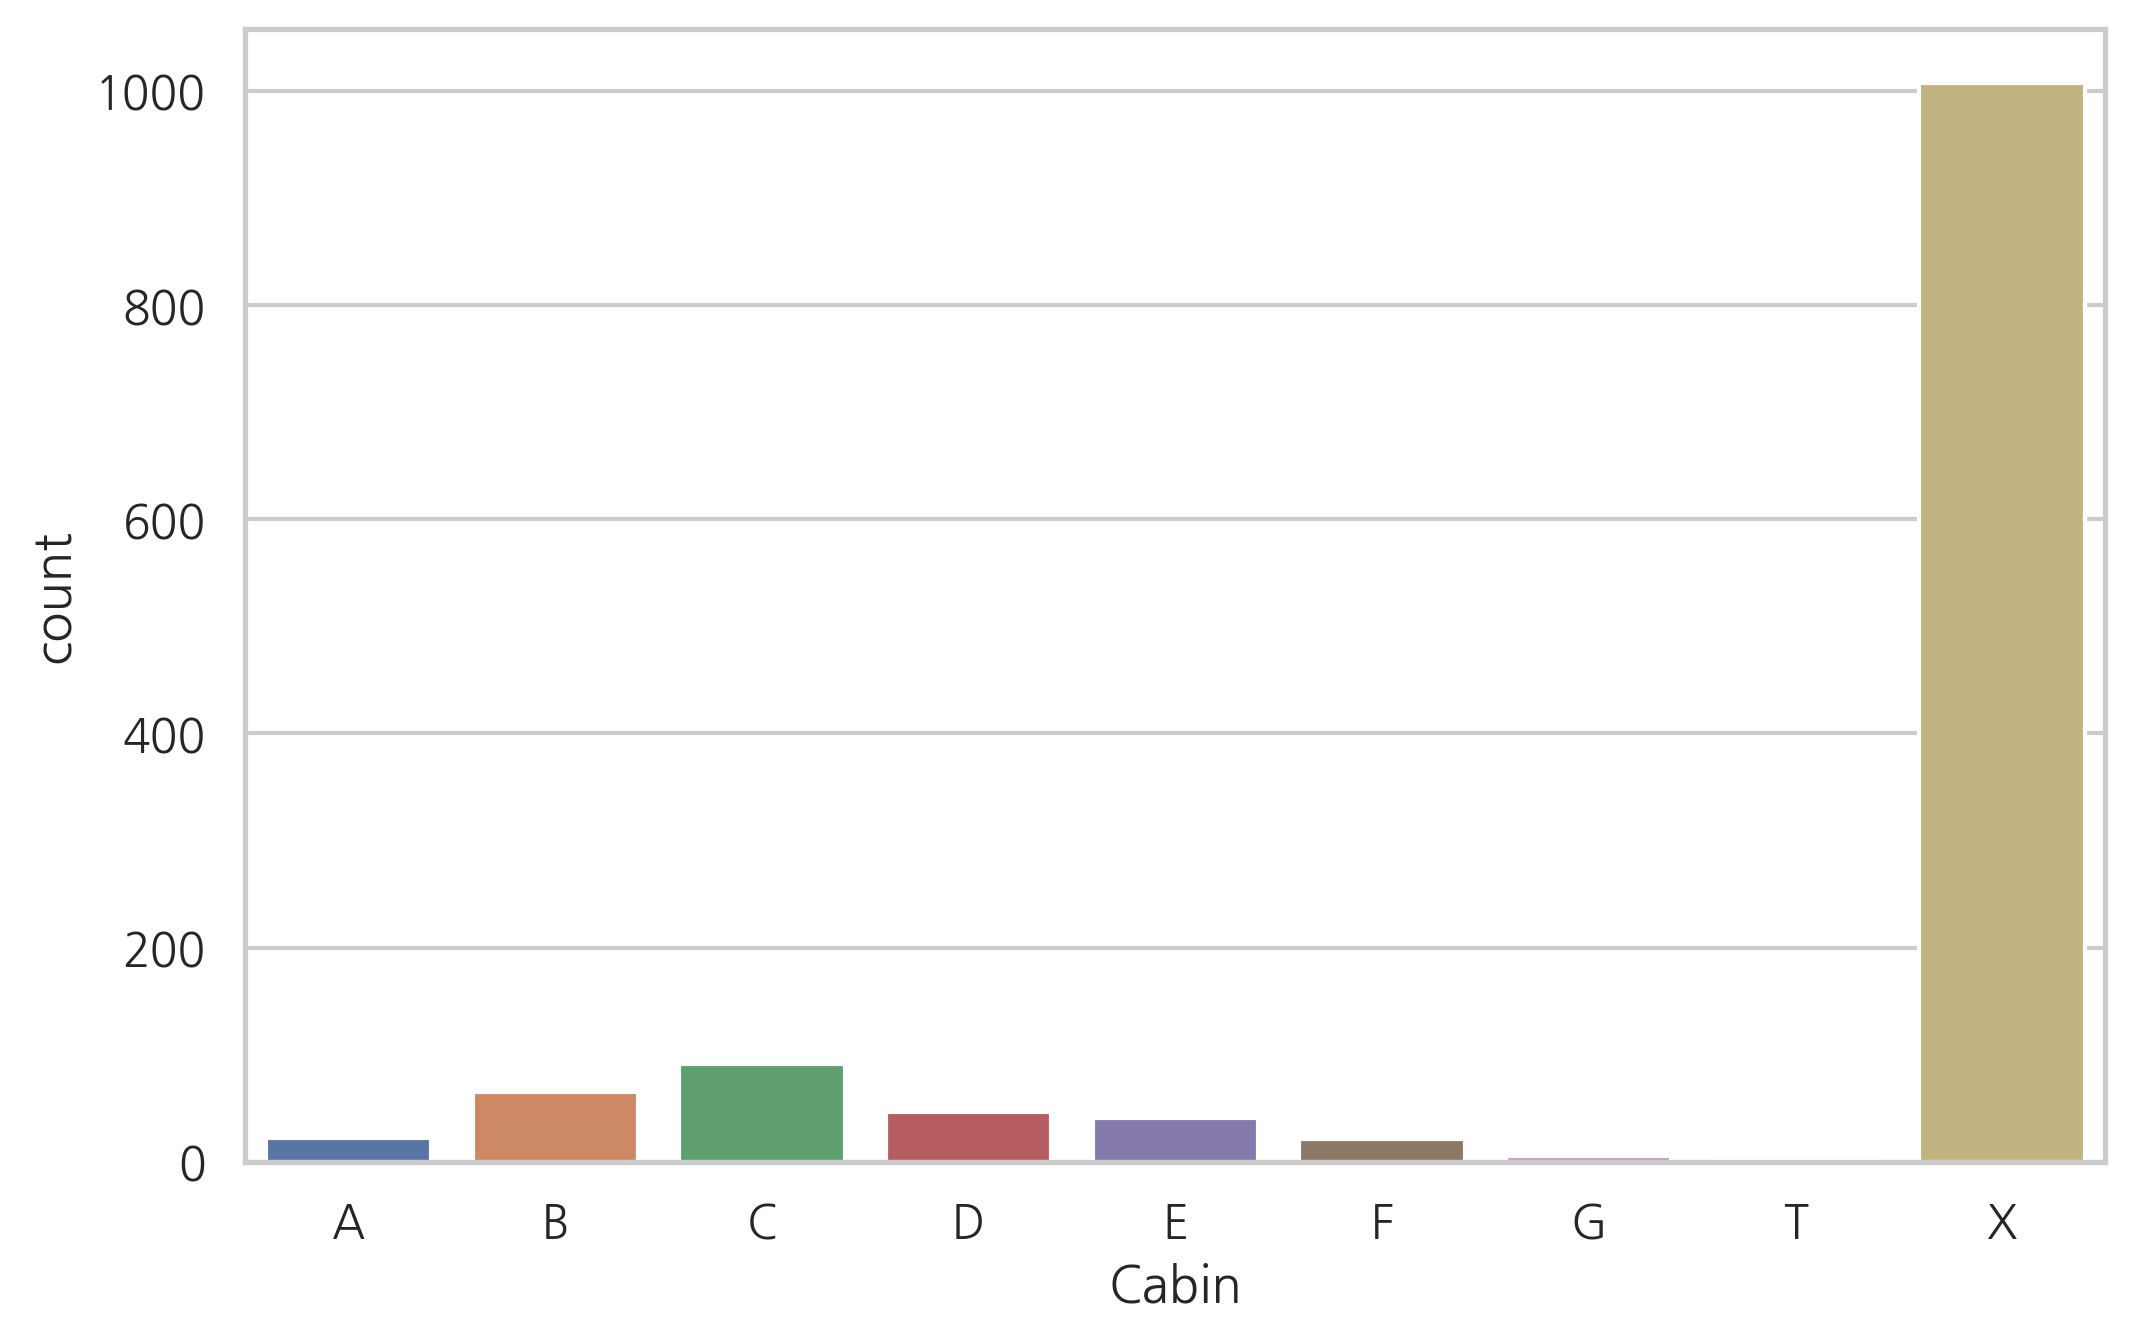

In [55]:
g = sns.countplot(dataset["Cabin"], order=['A','B','C','D','E','F','G','T','X'])

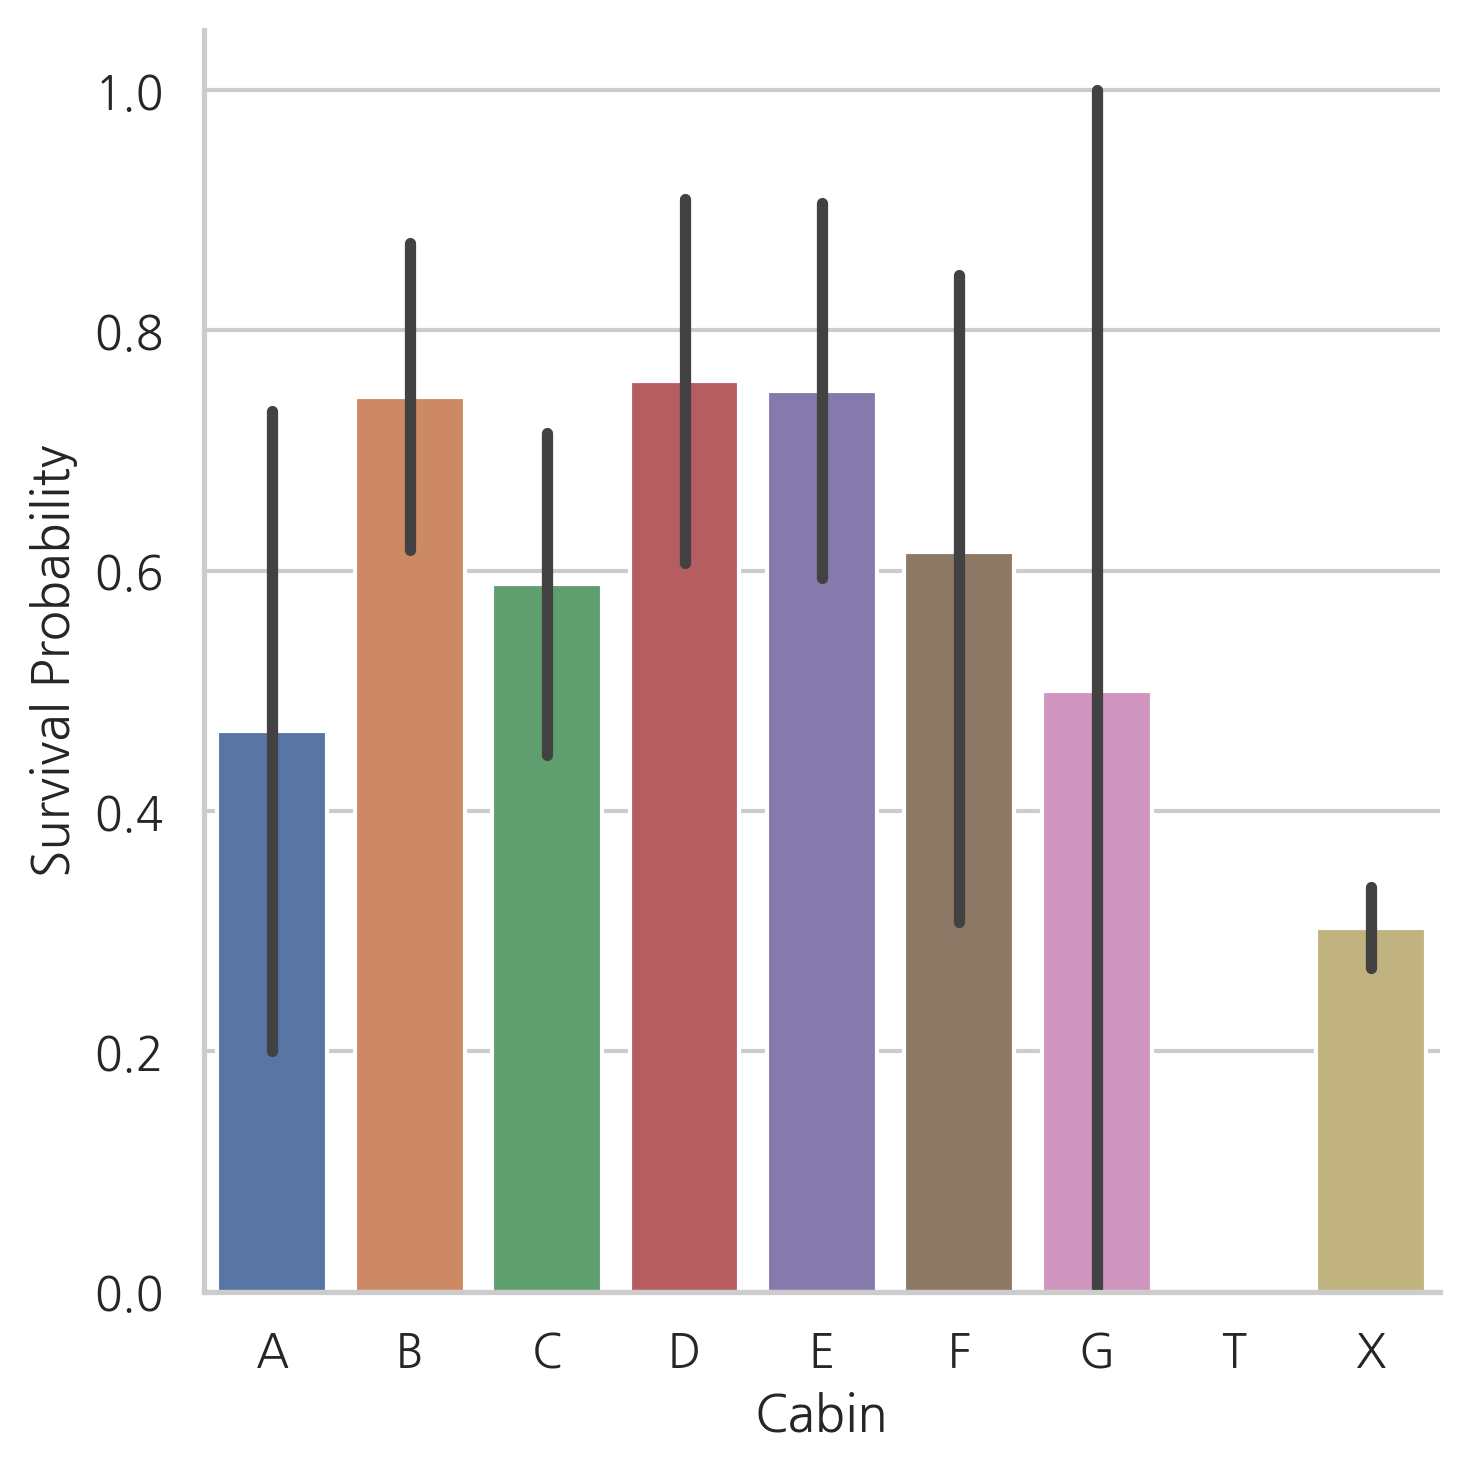

In [56]:
g = sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar",
                   order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

Cabin이 있는 탑승객의 수가 적기 때문에 우리는 다른 테스크에 있는 탑승객의 생존 확률을 알아내기 어렵습니다.

하지만 Cabin이 있는 승객이 없는 승객보다 생존 확률이 높다는 것을 알 수 있습니다.

In [57]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin")
dataset.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch            Ticket  \
0            1       0.0       3    0  22.0      1      0         A/5 21171   
1            2       1.0       1    1  38.0      1      0          PC 17599   
2            3       1.0       3    1  26.0      0      0  STON/O2. 3101282   
3            4       1.0       1    1  35.0      1      0            113803   
4            5       0.0       3    0  35.0      0      0            373450   

       Fare  Fsize  ...  Em_S  Cabin_A  Cabin_B  Cabin_C  Cabin_D  Cabin_E  \
0  1.981001      2  ...     1        0        0        0        0        0   
1  4.266662      2  ...     0        0        0        1        0        0   
2  2.070022      1  ...     1        0        0        0        0        0   
3  3.972177      2  ...     1        0        0        1        0        0   
4  2.085672      1  ...     1        0        0        0        0        0   

   Cabin_F  Cabin_G  Cabin_T  Cabin_X  
0        0        0        0        1  
1        0        0        0        0  
2        0        0        0        1  
3        0        0        0        0  
4        0        0        0        1  

[5 rows x 30 columns]

### 5.4 Ticket

In [58]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 접두사를 가지는 티켓은 같은 Cabin에 예약되었다는 것을 의미할 수 있습니다.

같은 접두사를 가진 티켓은 아마 비슷한 클래스와 생존 가능성을 가질 것입니다.

따라서, Ticket 칼럼의 값을 접두사로 바꾸어 줍니다.

In [59]:
# 접두어 추출, 없다면 X

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split()[0])
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [60]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [61]:
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc")

In [62]:
# 불필요한 칼럼 제거
dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [63]:
dataset.head()

Survived  Sex   Age  SibSp  Parch      Fare  Fsize  Single  SmallF  MedF  \
0       0.0    0  22.0      1      0  1.981001      2       0       1     0   
1       1.0    1  38.0      1      0  4.266662      2       0       1     0   
2       1.0    1  26.0      0      0  2.070022      1       1       0     0   
3       1.0    1  35.0      1      0  3.972177      2       0       1     0   
4       0.0    0  35.0      0      0  2.085672      1       1       0     0   

   ...  T_STONO  T_STONO2  T_STONOQ  T_SWPP  T_WC  T_WEP  T_X  Pc_1  Pc_2  \
0  ...        0         0         0       0     0      0    0     0     0   
1  ...        0         0         0       0     0      0    0     1     0   
2  ...        0         1         0       0     0      0    0     0     0   
3  ...        0         0         0       0     0      0    1     1     0   
4  ...        0         0         0       0     0      0    1     0     0   

   Pc_3  
0     1  
1     0  
2     1  
3     0  
4     1  

[5 rows x 67 columns]

---------
## 6. MODELING

In [64]:
# train, test 데이터 세트 분리
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

In [65]:
# train features와 label 분리
Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"], axis=1)

### 6.1 Simple modeling
#### 6.1.1 Cross validate models

**stratified kfold cross validation**을 통해 평균 정확도를 평가하고 10개의 유명한 분류기를 비교해볼 것입니다.

stratified kfold cross validation:
    - K fold는 random으로 데이터 셋을 split 해주는데, 이 때문에 레이블 값의 분포(비율)가 기존 데이터 full 셋에서의 분포(비율)와 크게 달라질 수도 있다. Stratified K-fold 교차 검증 방법은 원본 데이터에서 레이블 분포를 먼저 고려한 뒤, 이 분포와 동일하게 학습 및 검증 데이터 세트를 분배

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [66]:
kfold = StratifiedKFold(n_splits=10)

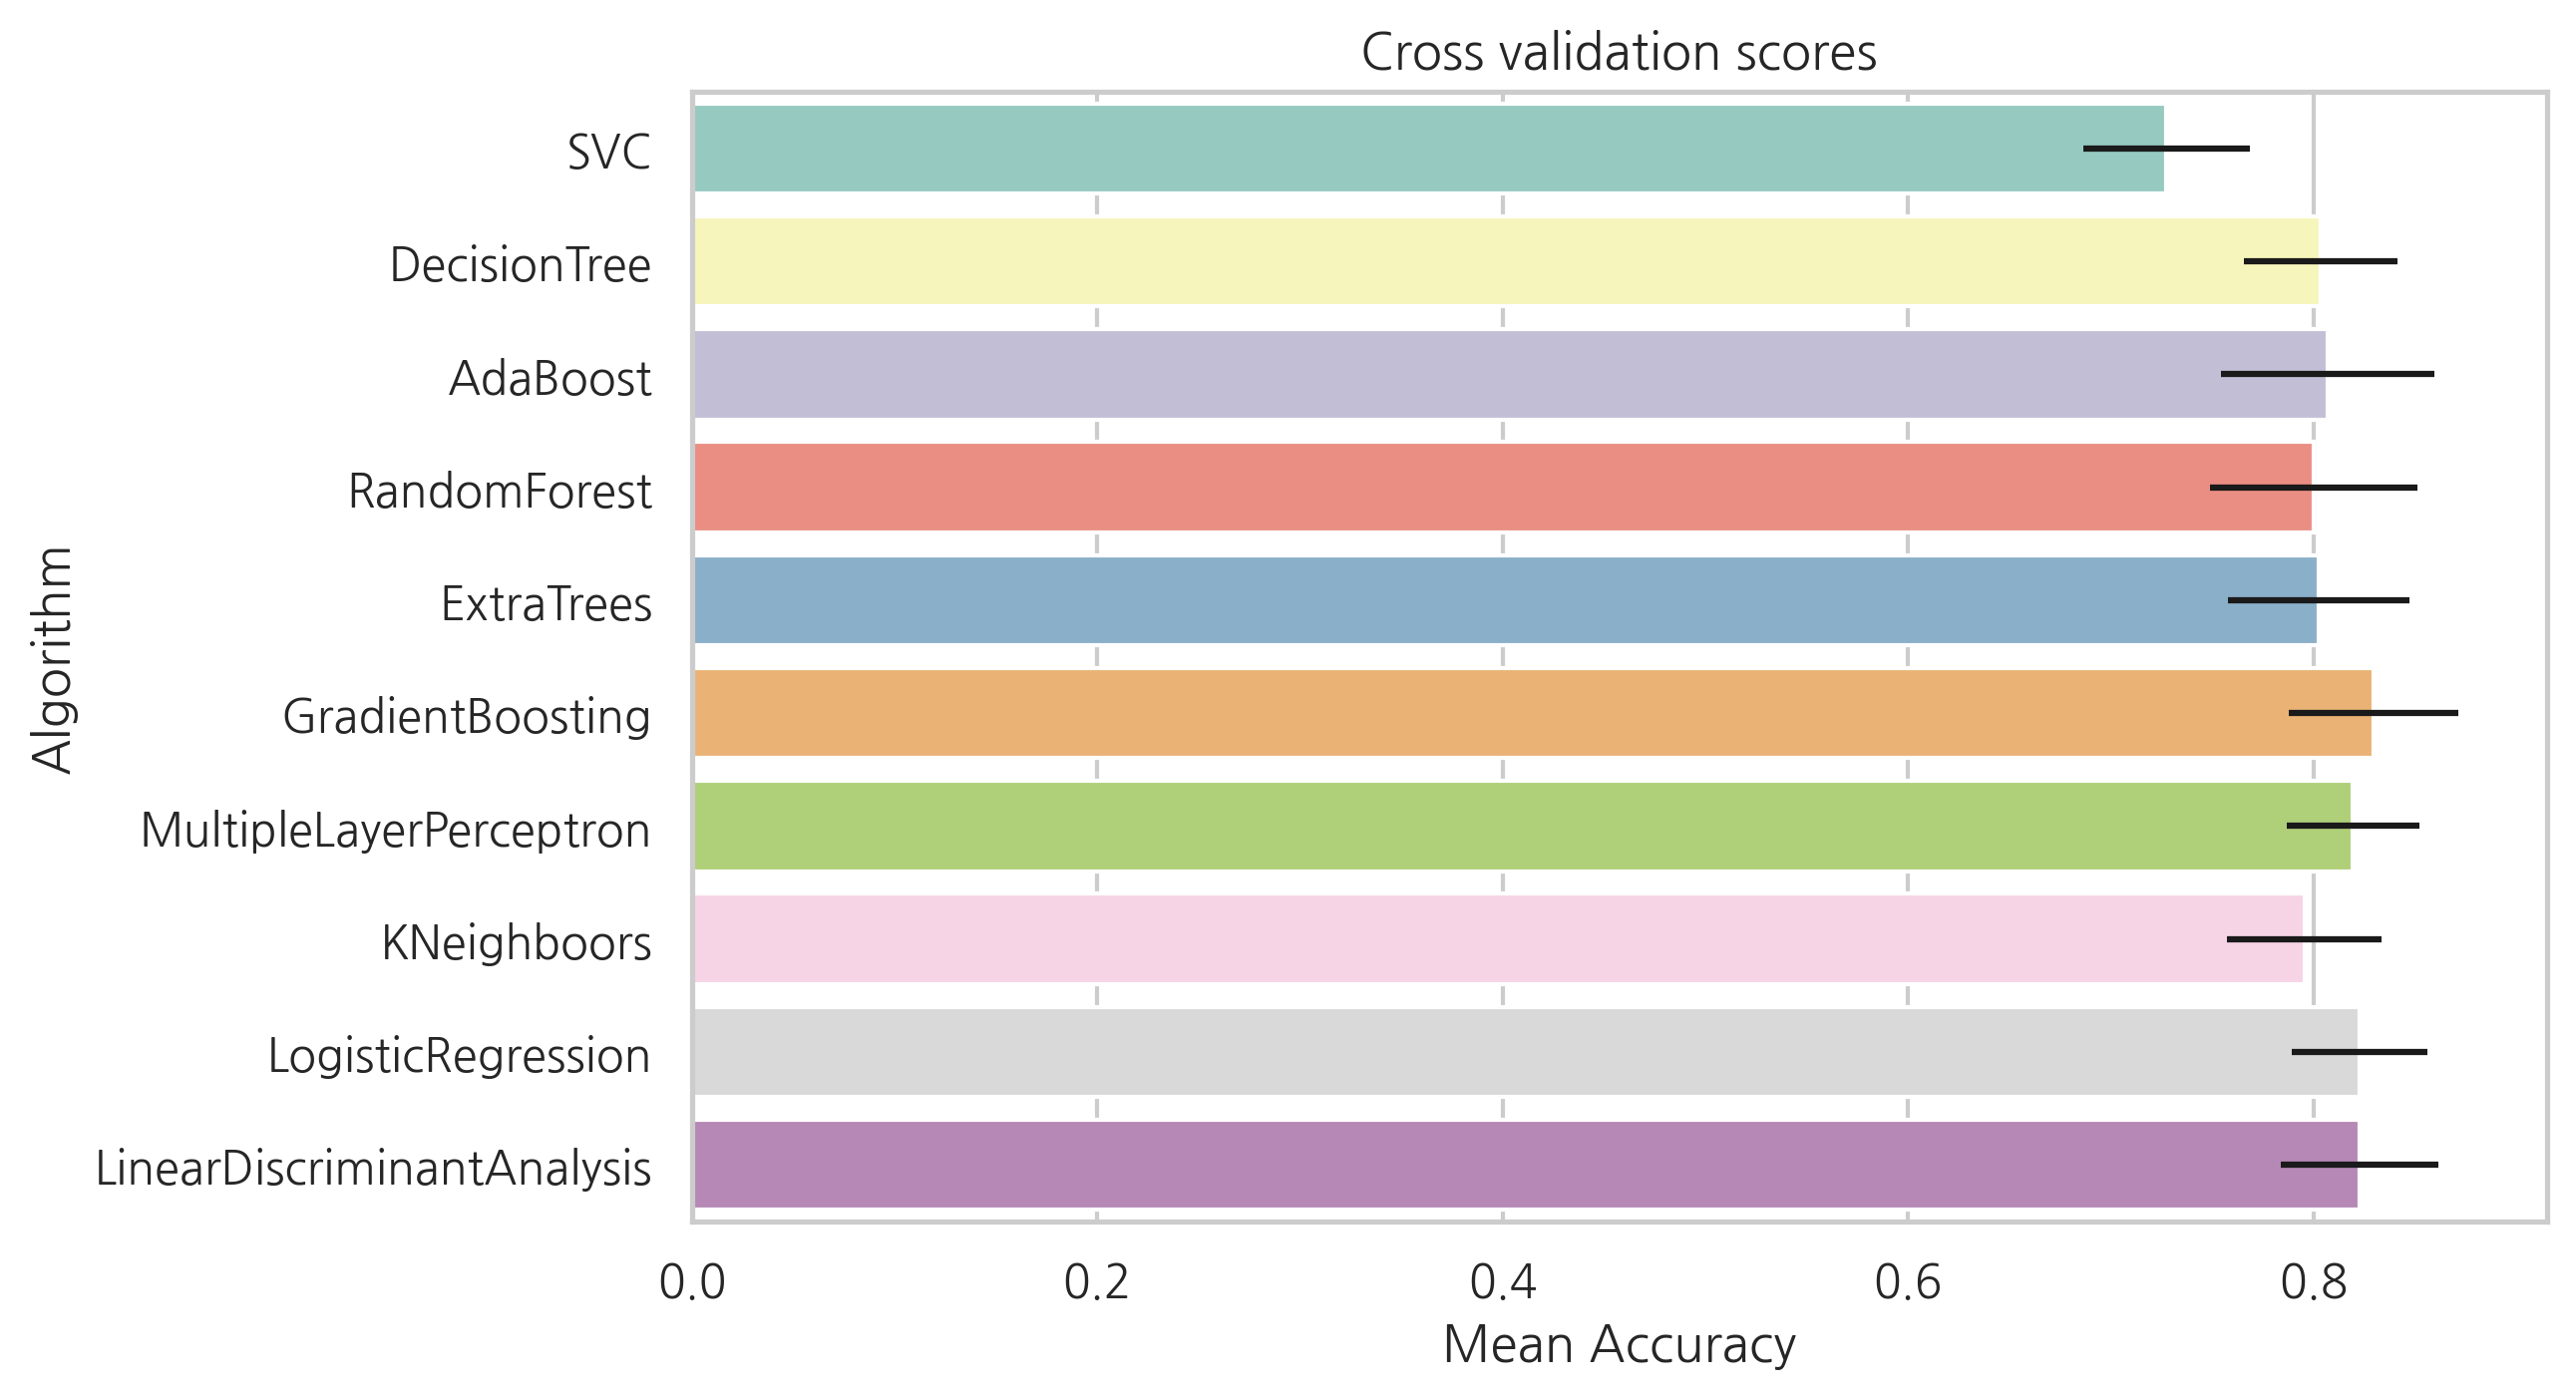

In [67]:
# 모델링 단계, 다양한 알고리즘을 테스트
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, 
                                      scoring="accuracy", cv=kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
                                                                                      "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors",
                                                                                      "LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3",
                orient="h", **{"xerr": cv_std} # 오차막대 추가
                )
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

SVC, AdaBoost, RandomForest , ExtraTrees, GradientBoosting classifier 선택하여 앙상블 모델을 만들어 봅시다.

#### 6.1.2 Hyperparameter tunning for best models

각각의 알고리즘에 대해서 GridSearch를 해봅니다.

병렬 수행을 의미하는 n_jobs는 모든 프로세서를 사용하도록 -1로 설정합니다.

In [70]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {
    "base_estimator__criterion": ["gini", "entropy"],
    "base_estimator__splitter": ["best", "random"],
    "algorithm": ["SAMME", "SAMME.R"],
    "n_estimators": [1, 2],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]
}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring="accuracy",
                        n_jobs=-1, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [71]:
gsadaDTC.best_score_

0.8275536261491316

In [72]:
# ExtraTrees
ExtC = ExtraTreesClassifier()
ex_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [100, 300],
    "criterion": ["gini"]
}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring="accuracy",
                      n_jobs=-1, verbose=1)
gsExtC.fit(X_train, Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320097037793668

In [73]:
# RFC
RFC = RandomForestClassifier()

rf_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [100, 300],
    "criterion":["gini"]
}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring="accuracy",
                     n_jobs=-1, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8343079673135854

In [75]:
# Gradient boosting
GBC = GradientBoostingClassifier()
gb_param_grid = {
    "loss": ["deviance"],
    "n_estimators": [100, 200, 300],
    "learning_rate": [ 0.1, 0.05, 0.01],
    "max_depth": [4, 8],
    "min_samples_leaf": [100, 150],
    "max_features": [0.3, 0.1]
}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy",
                     n_jobs=-1, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8331588355464762

In [79]:
# SVC
SVMC = SVC(probability=True)
svc_param_grid={
    "kernel": ["rbf"],
    "gamma": [0.001, 0.01, 0.1, 1],
    "C": [1, 10, 50, 100, 200, 300, 1000]
}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring="accuracy",
                      n_jobs=-1, verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Plot learning curves

학습 곡선은 training set에 대한 overfitting과 정확도에 대한 데이터 크기의 영향을 알아보는 좋은 방법입니다.

In [88]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0 ,5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

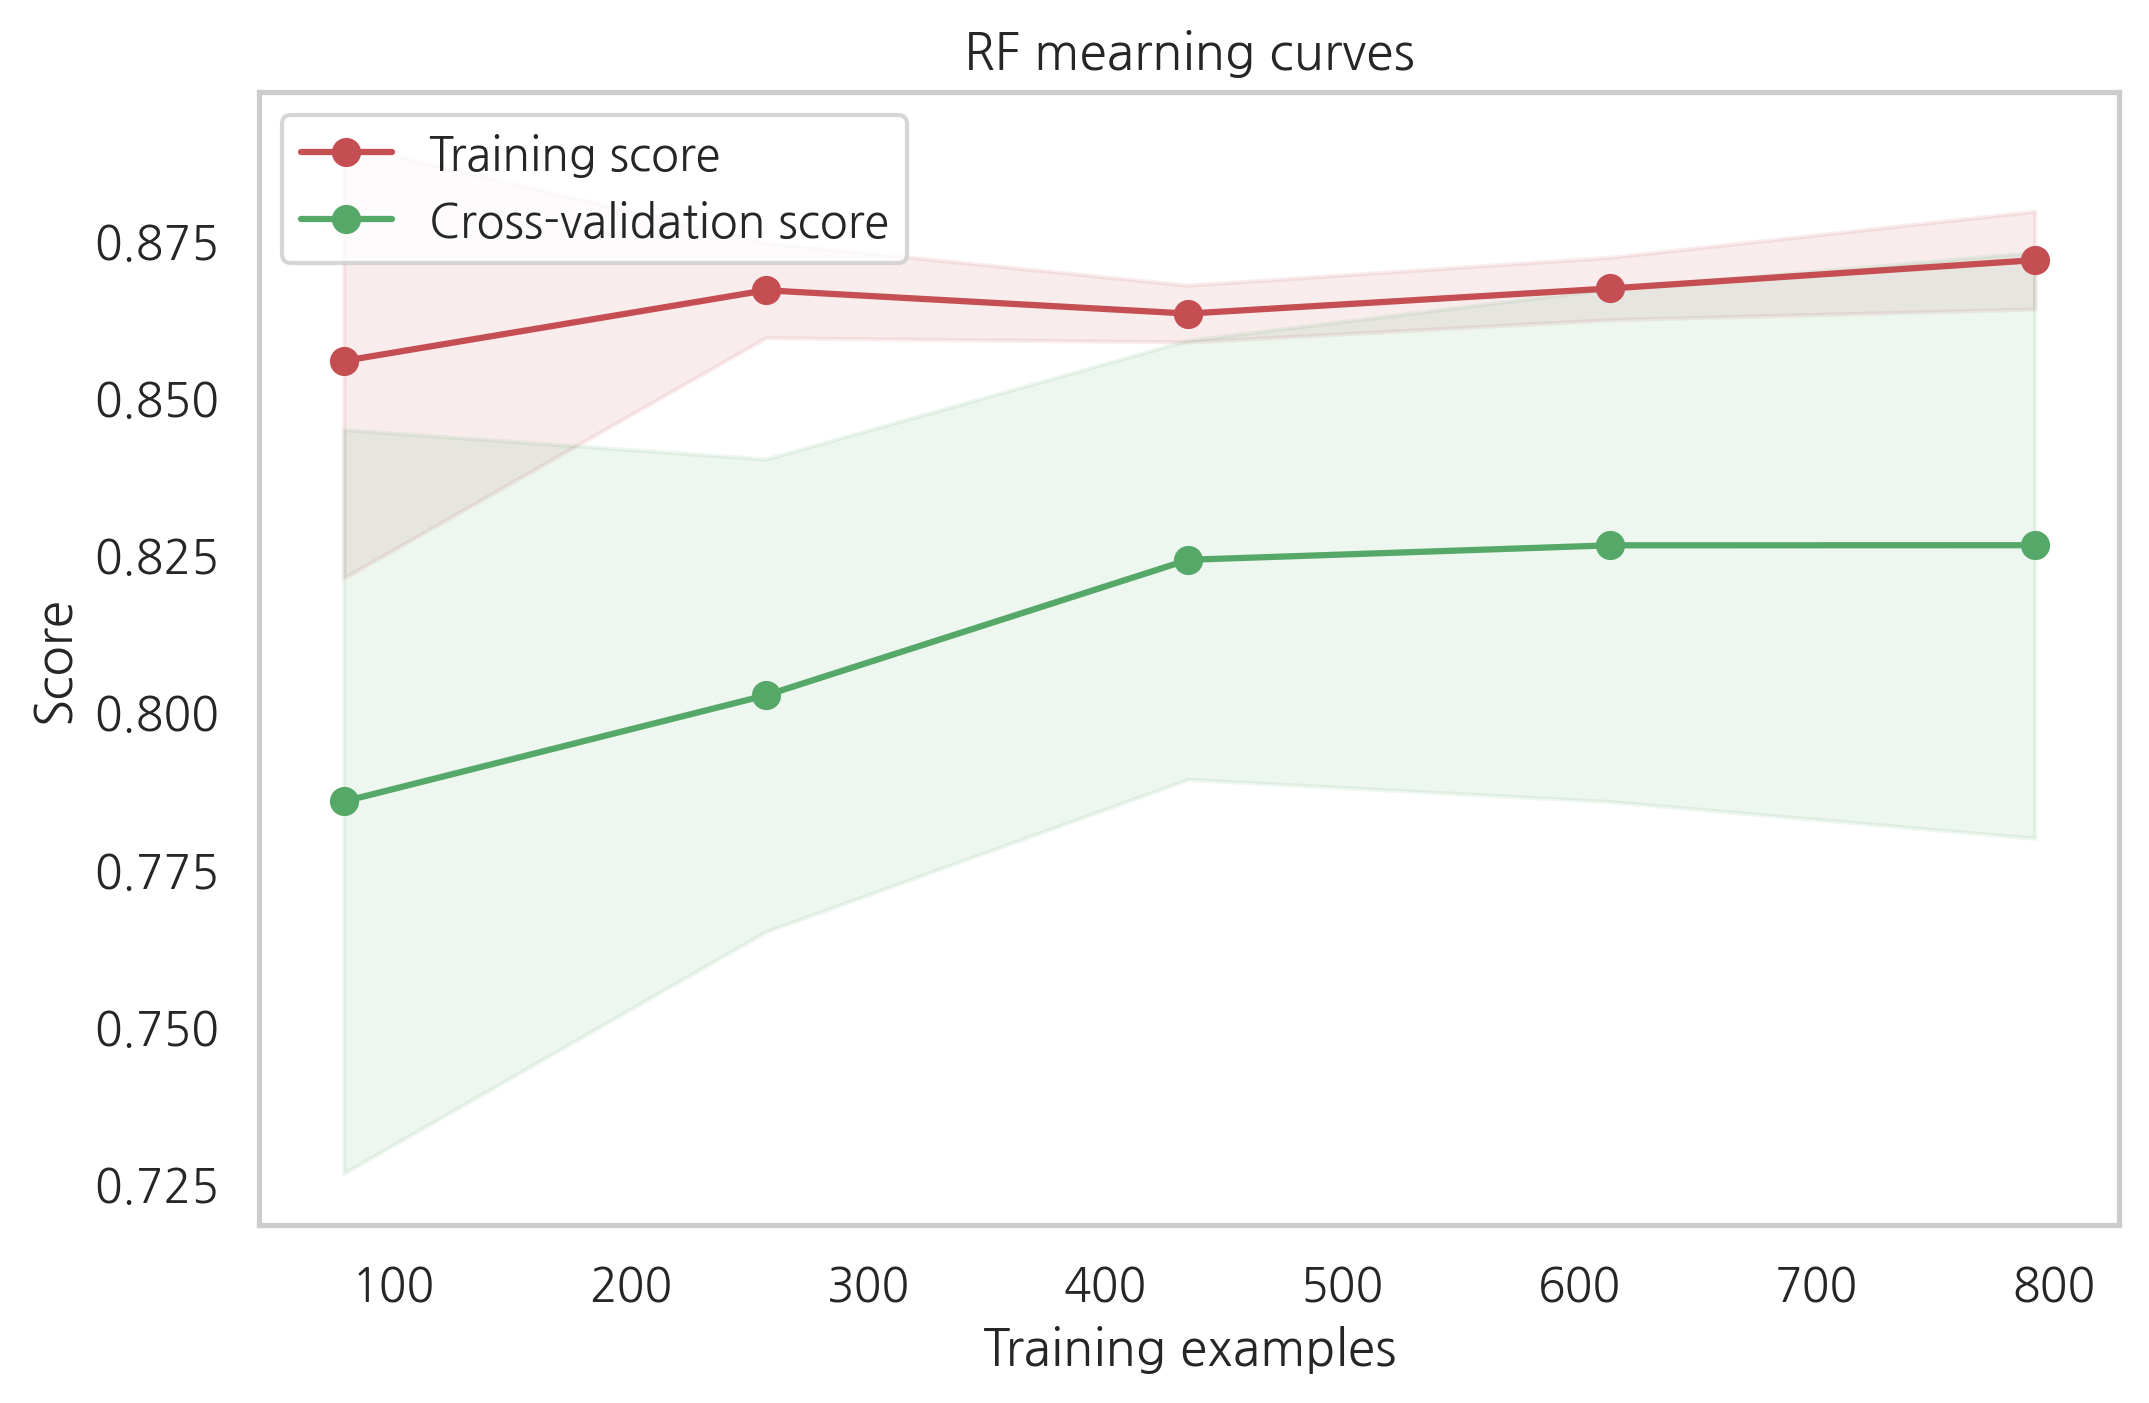

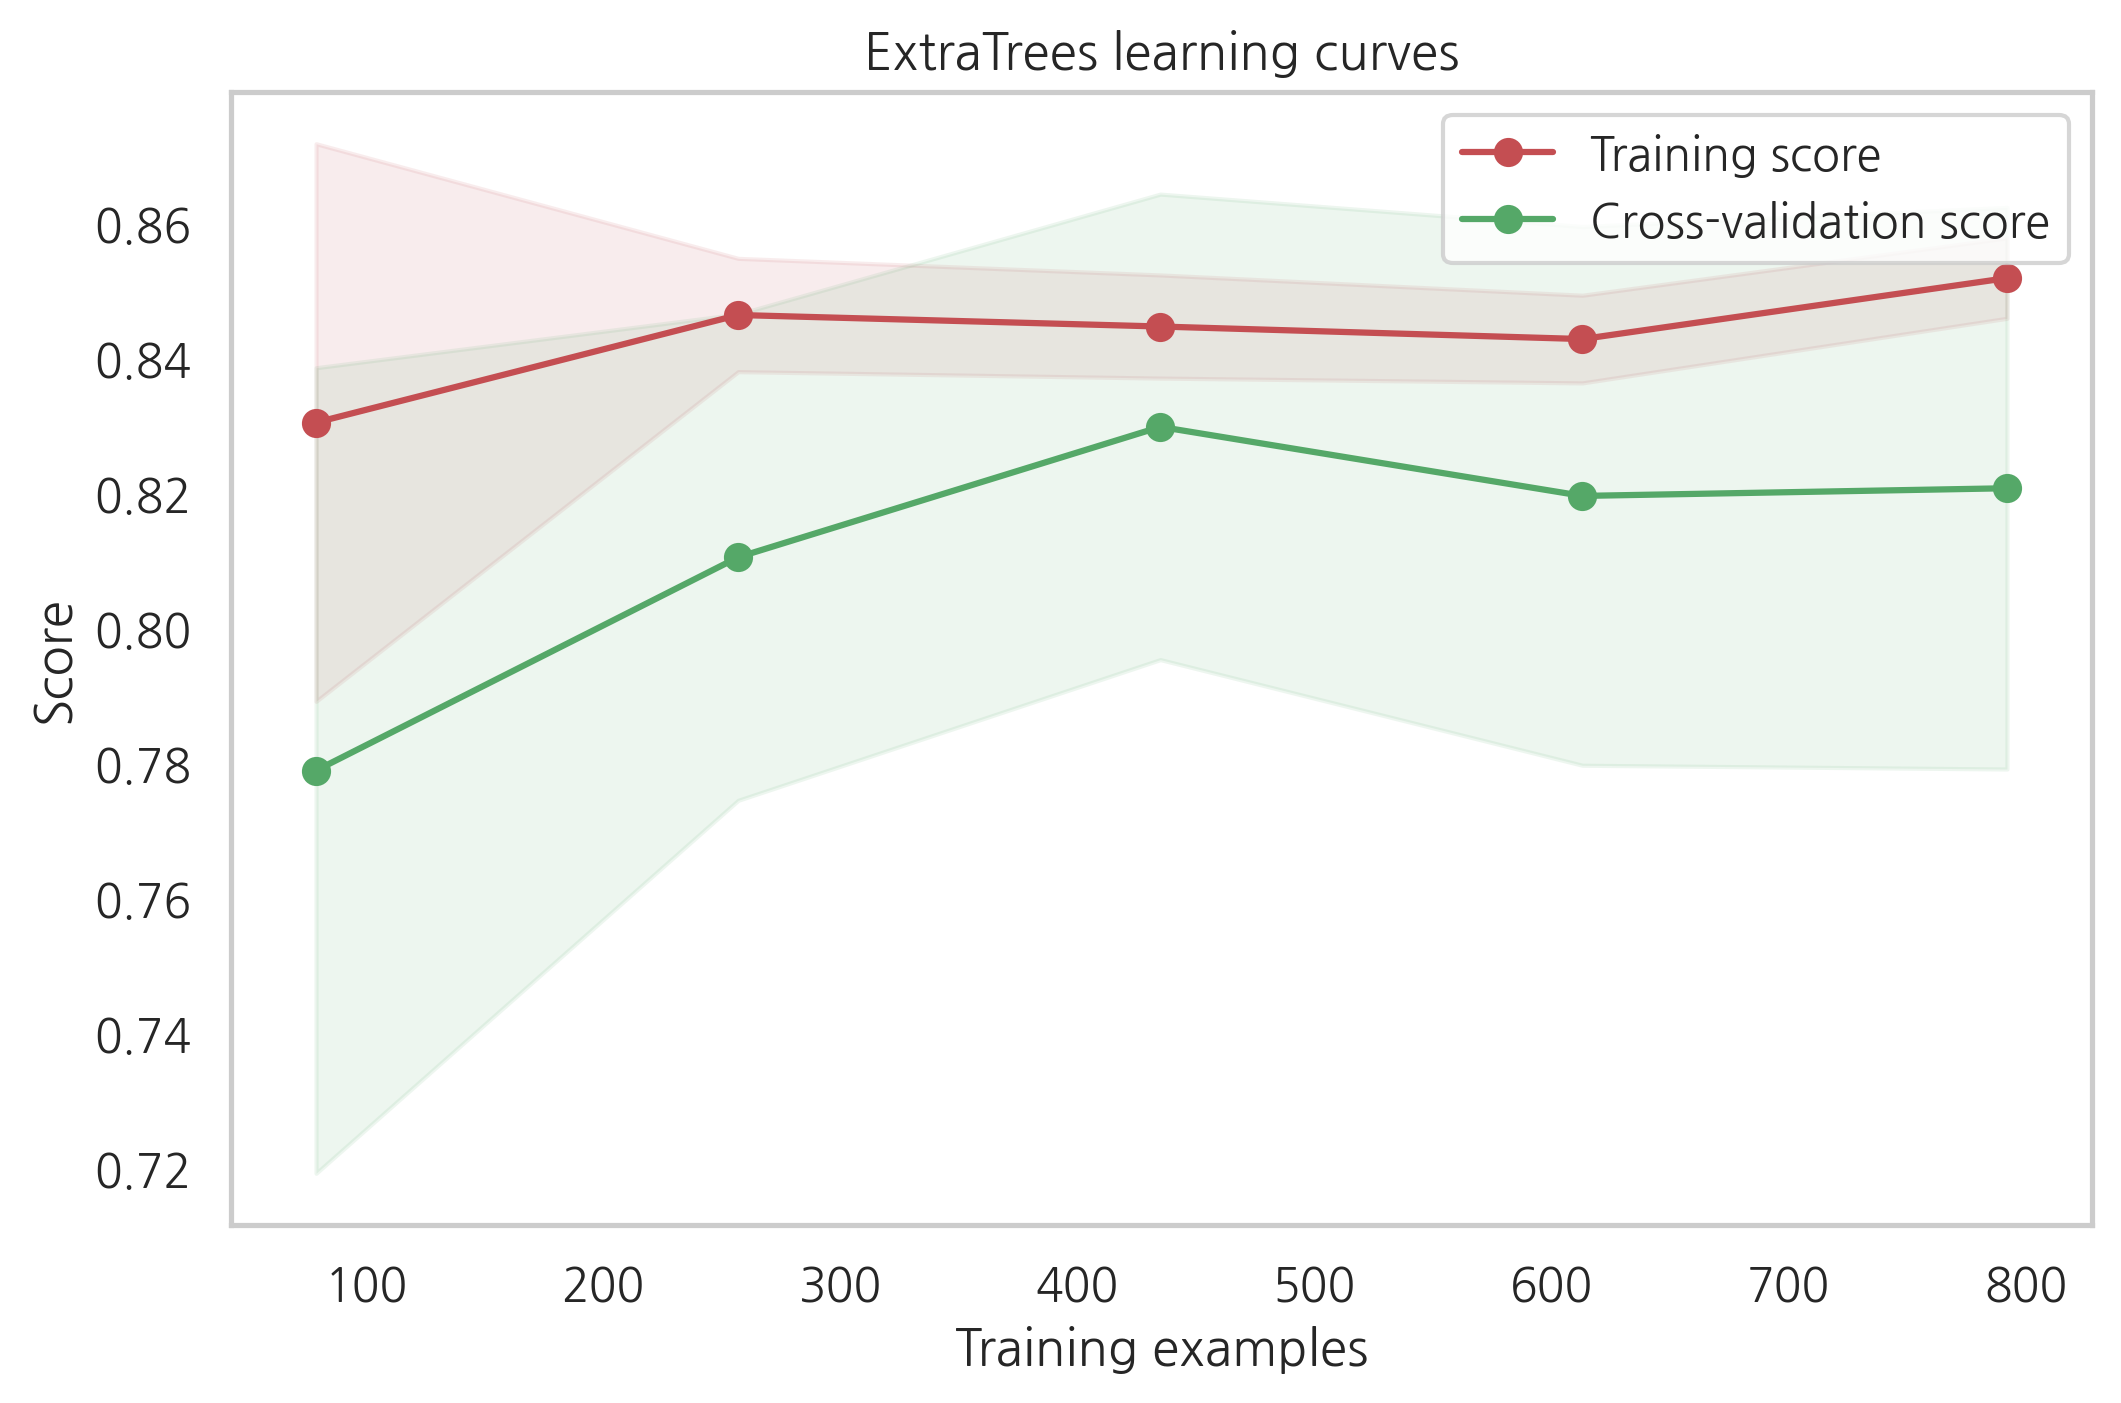

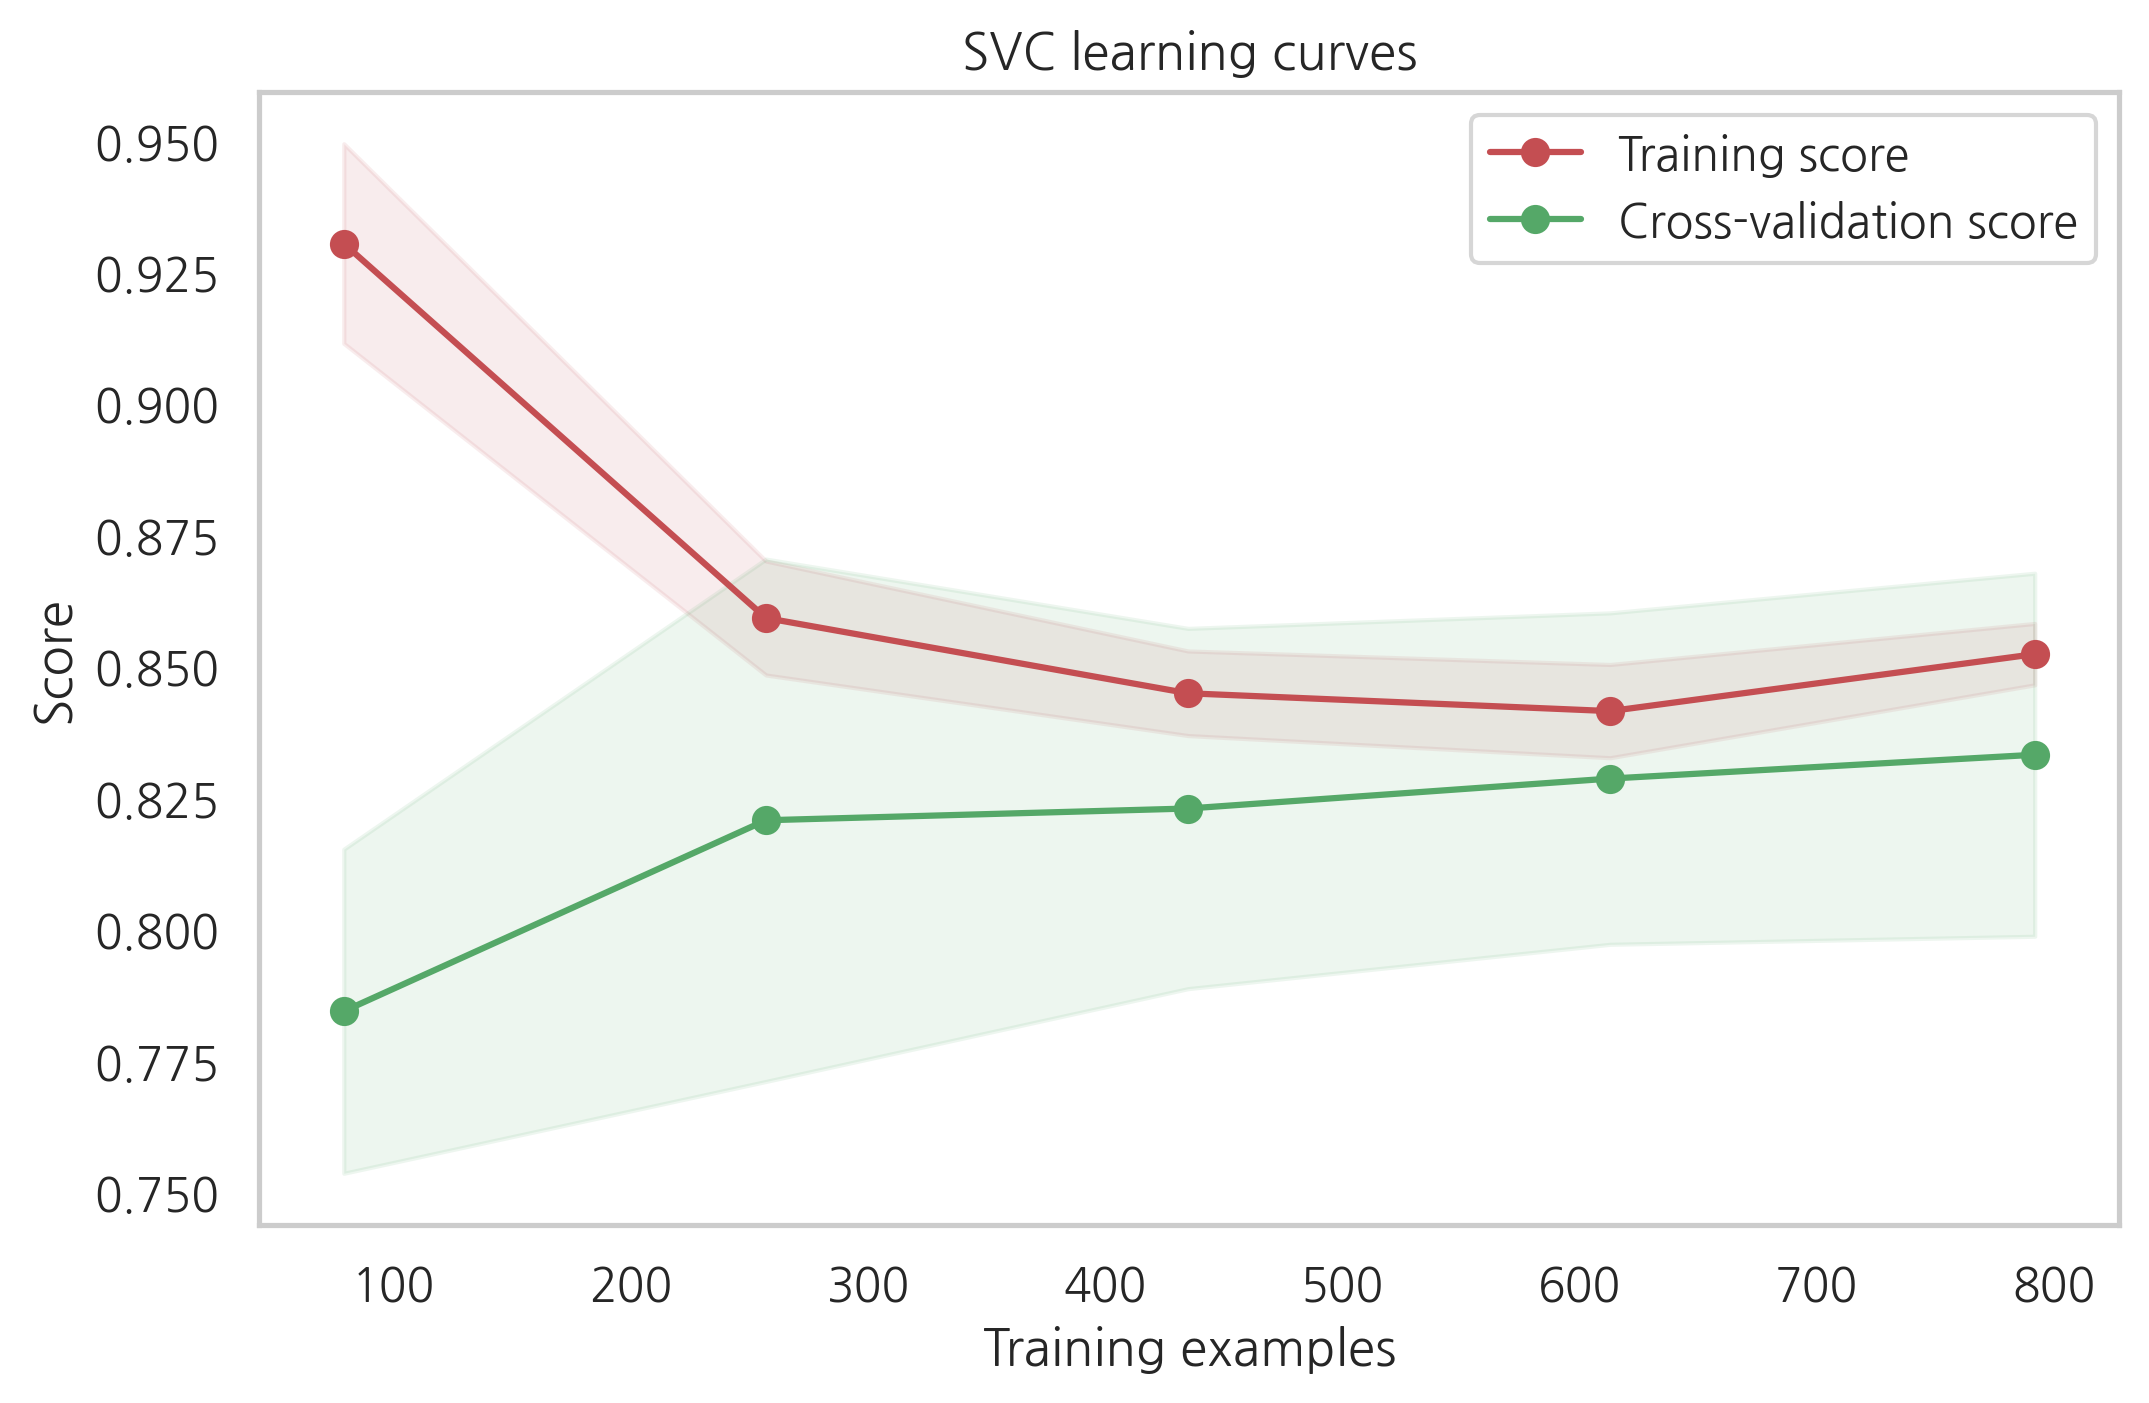

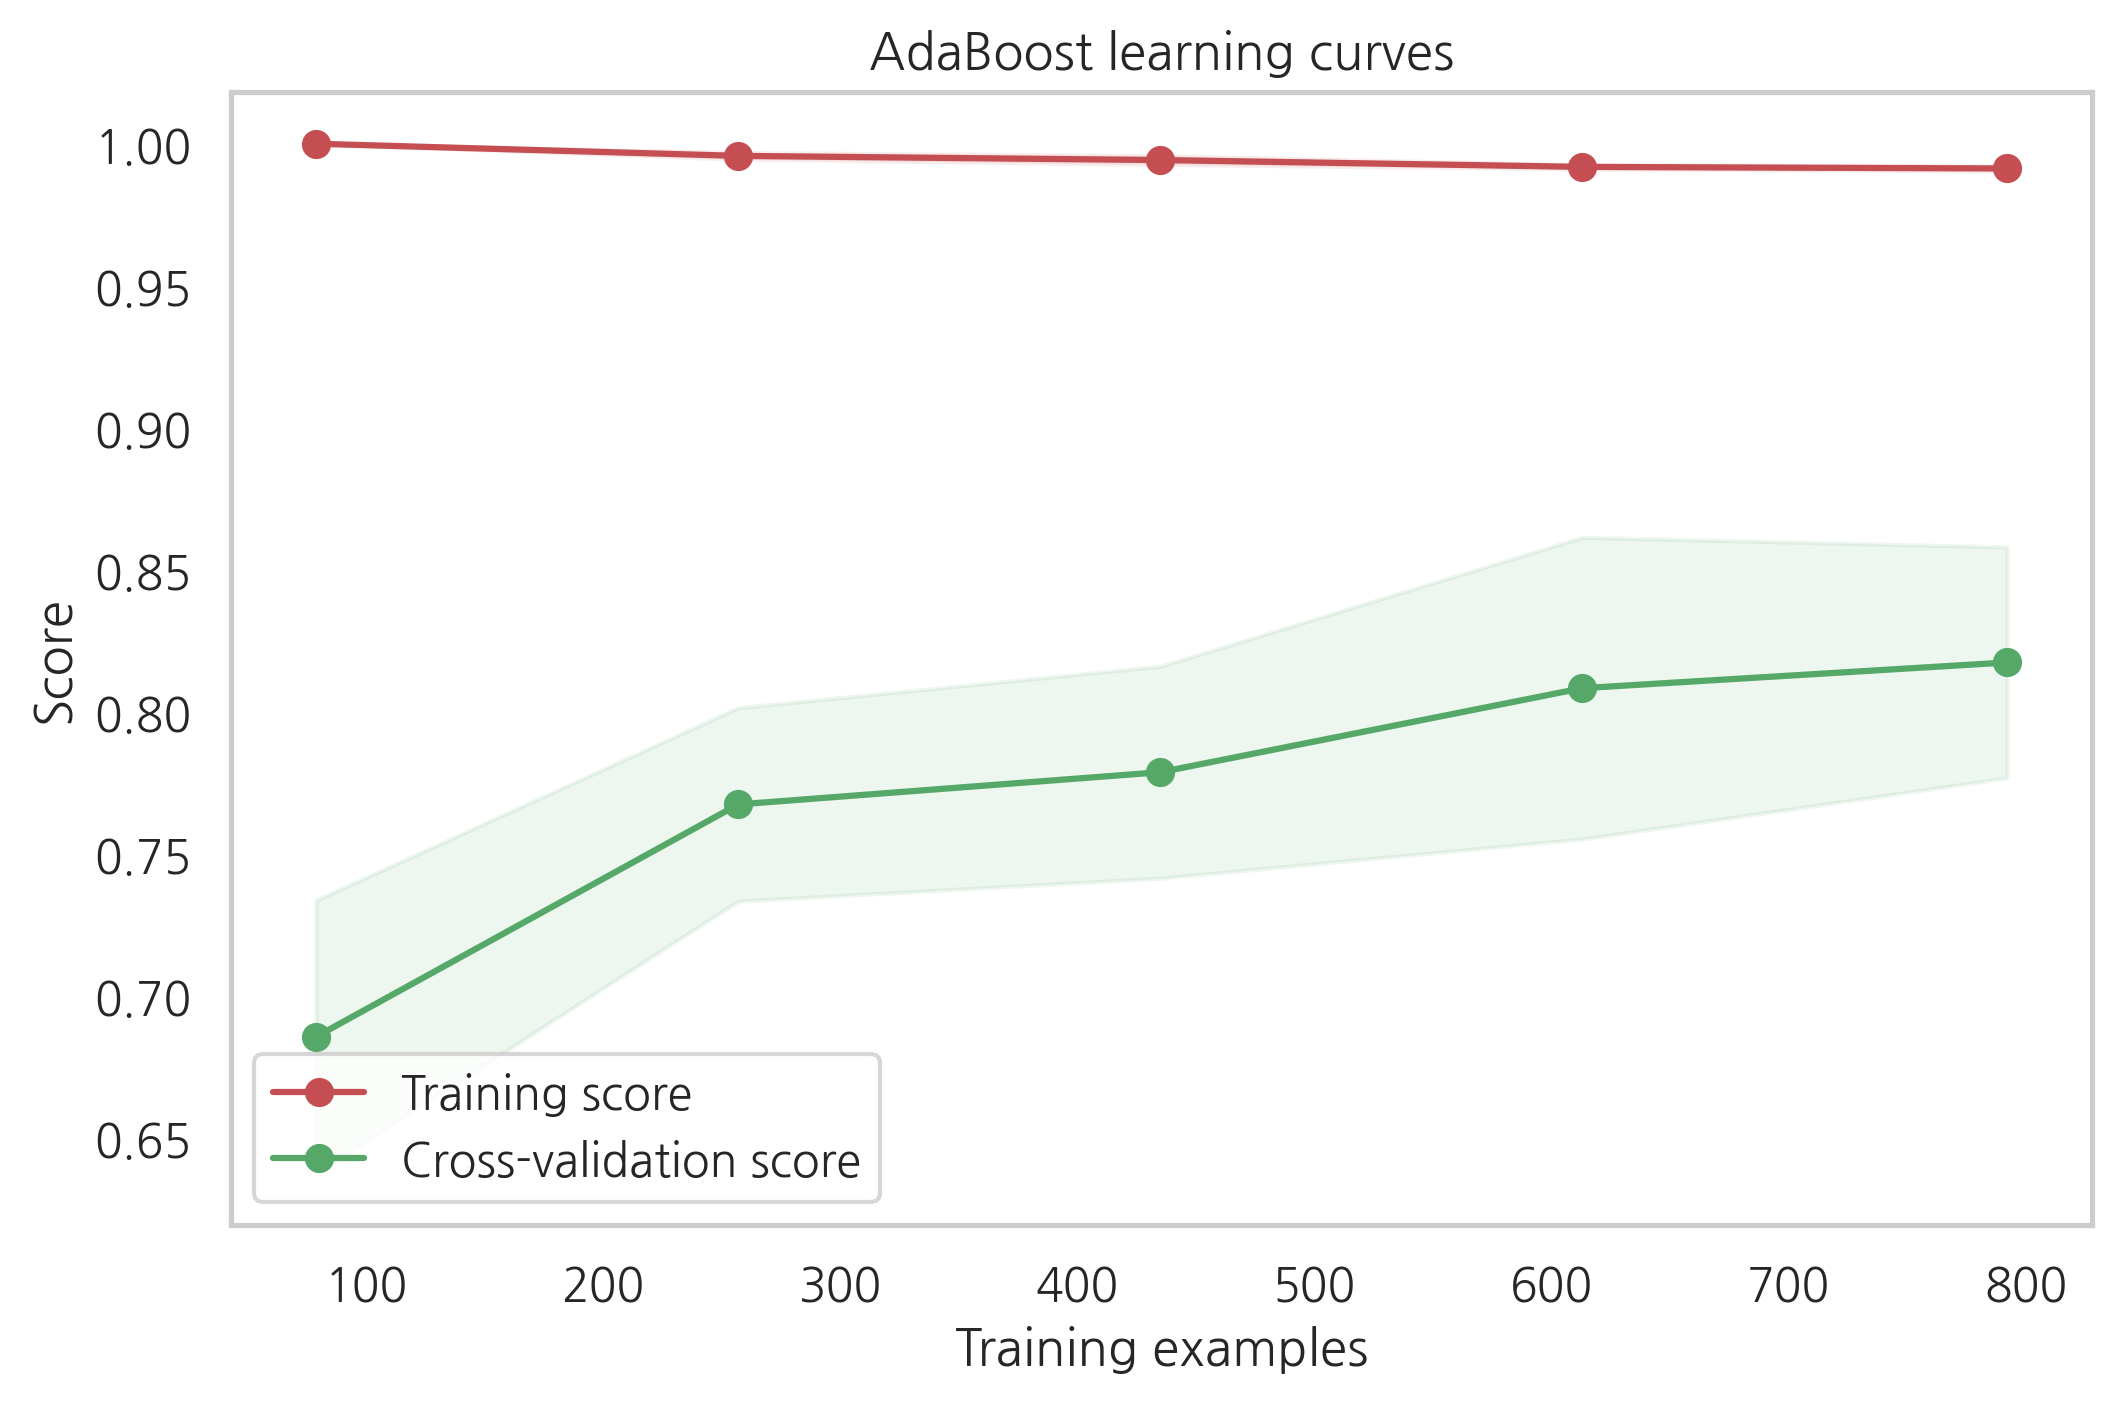

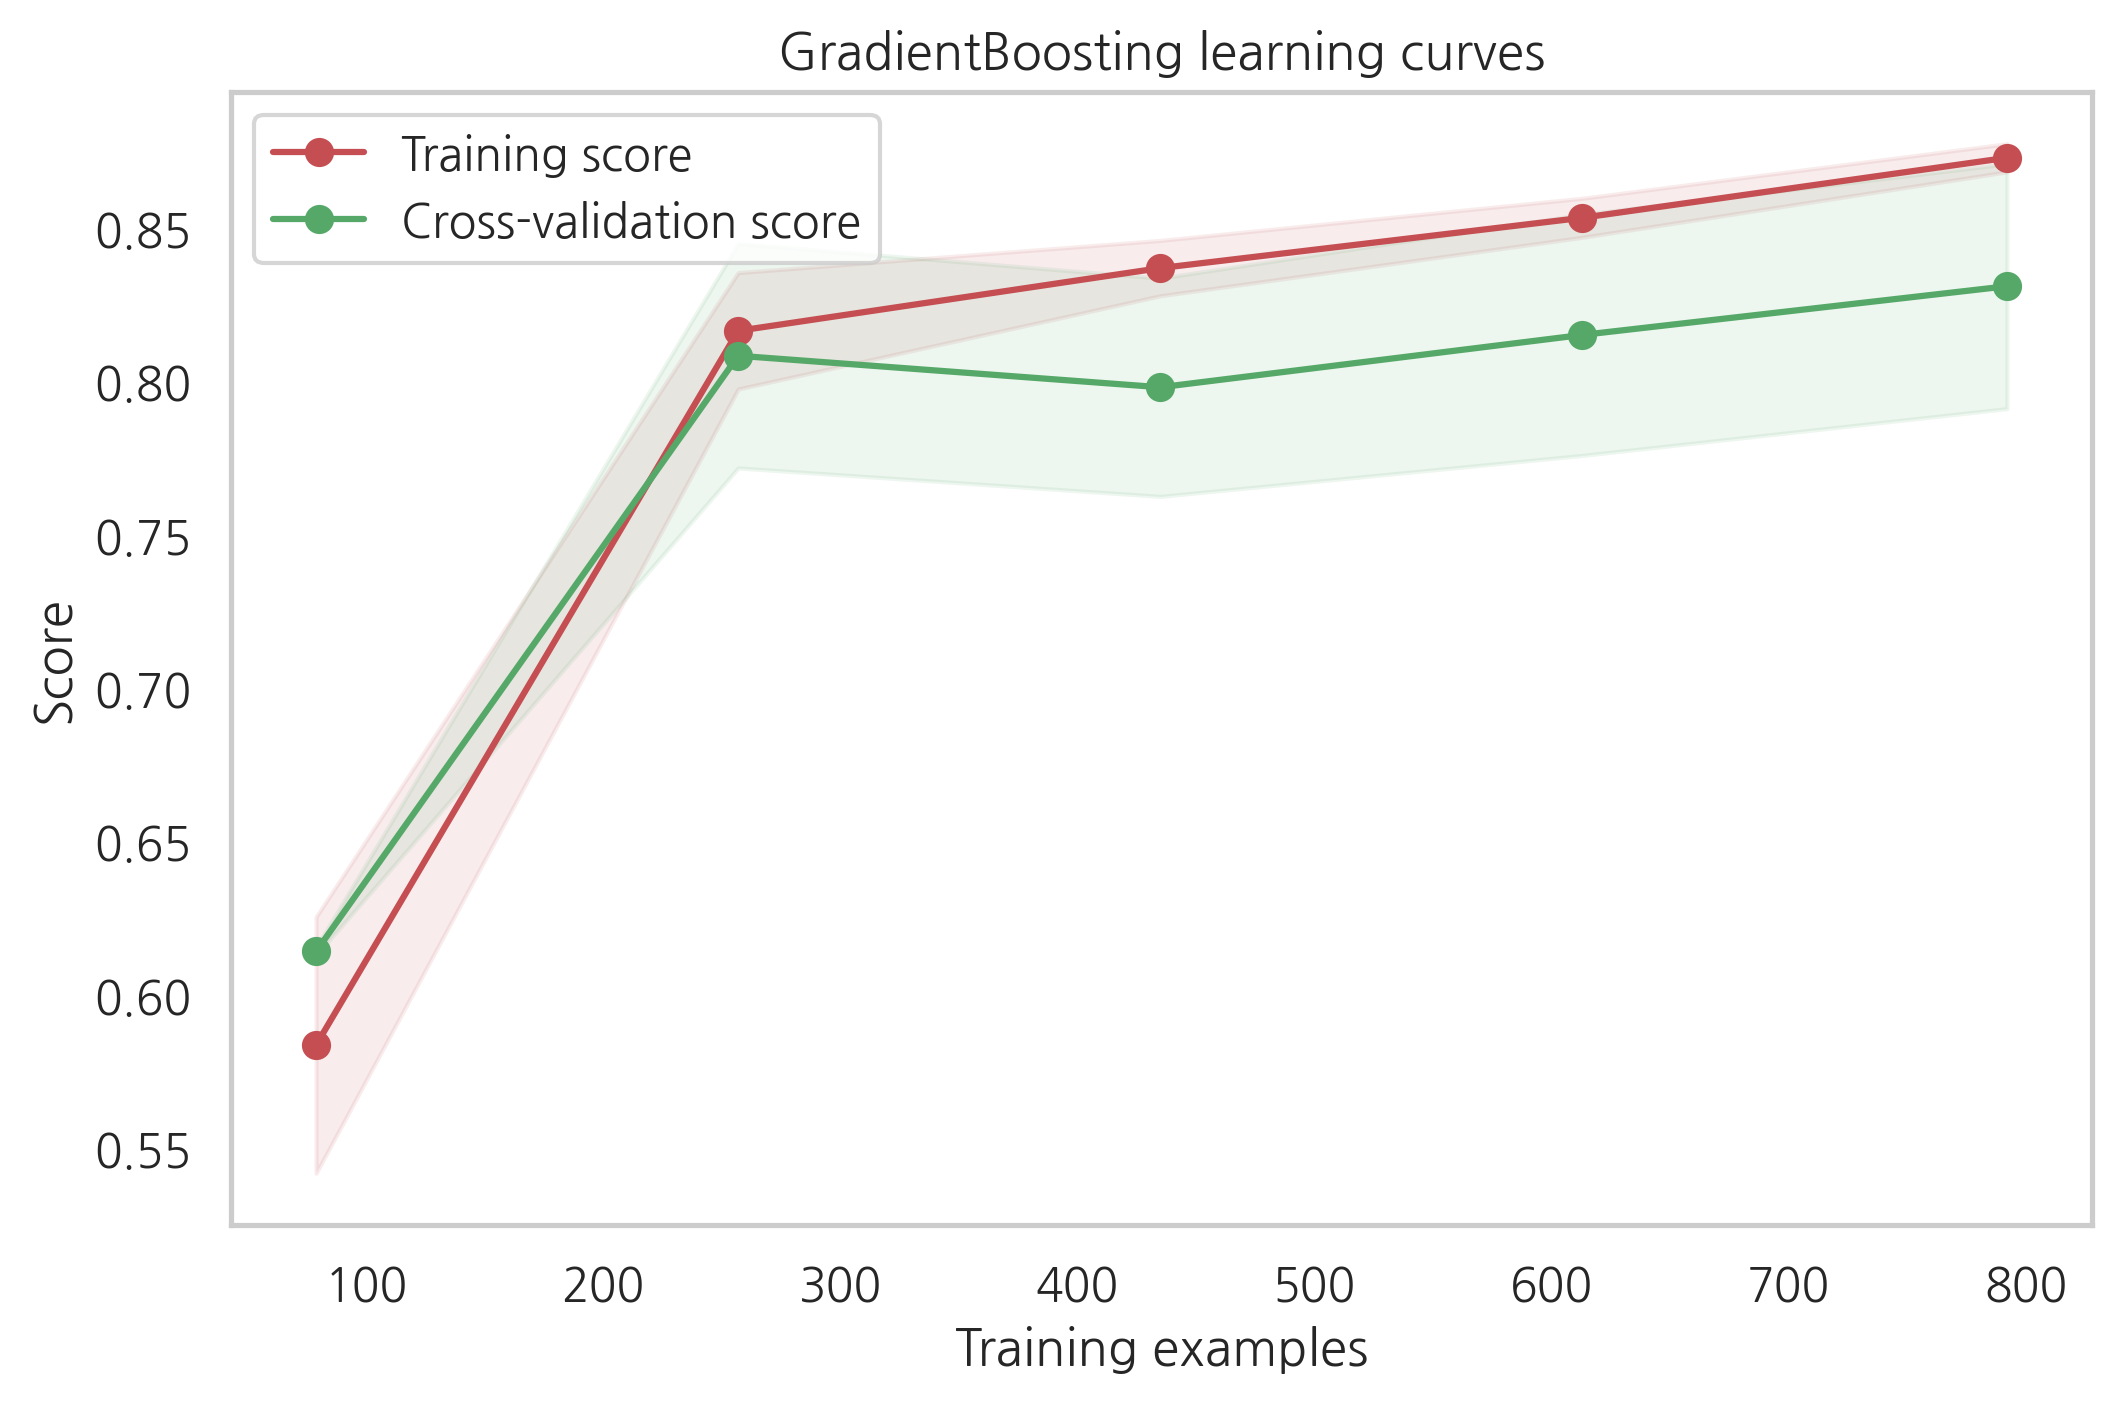

In [89]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

cross-validation 커브곡선의 증가하는 것을 보았을때, GradientBoosting과 Adaboost는 더 많은 샘플이 있으면 더 나은 성능을 보여줄 수 있을 것 같습니다.

SVC와 ExtraTreesClassifiers는 training과 cross-validation의 커브곡선이 크게 차이나지 않는 것을 보았을때 예측을 하는데 있어서 더 일반화가 잘되어있는 것처럼 보입니다.

#### 6.1.4 Feature importance of tree based classifiers
탑승객의 생존여부를 예측하는데 가장 유익한 feature을 보기 위해, 4개의 트리 기반 분류기들의 feature importance를 시각화해봅니다.

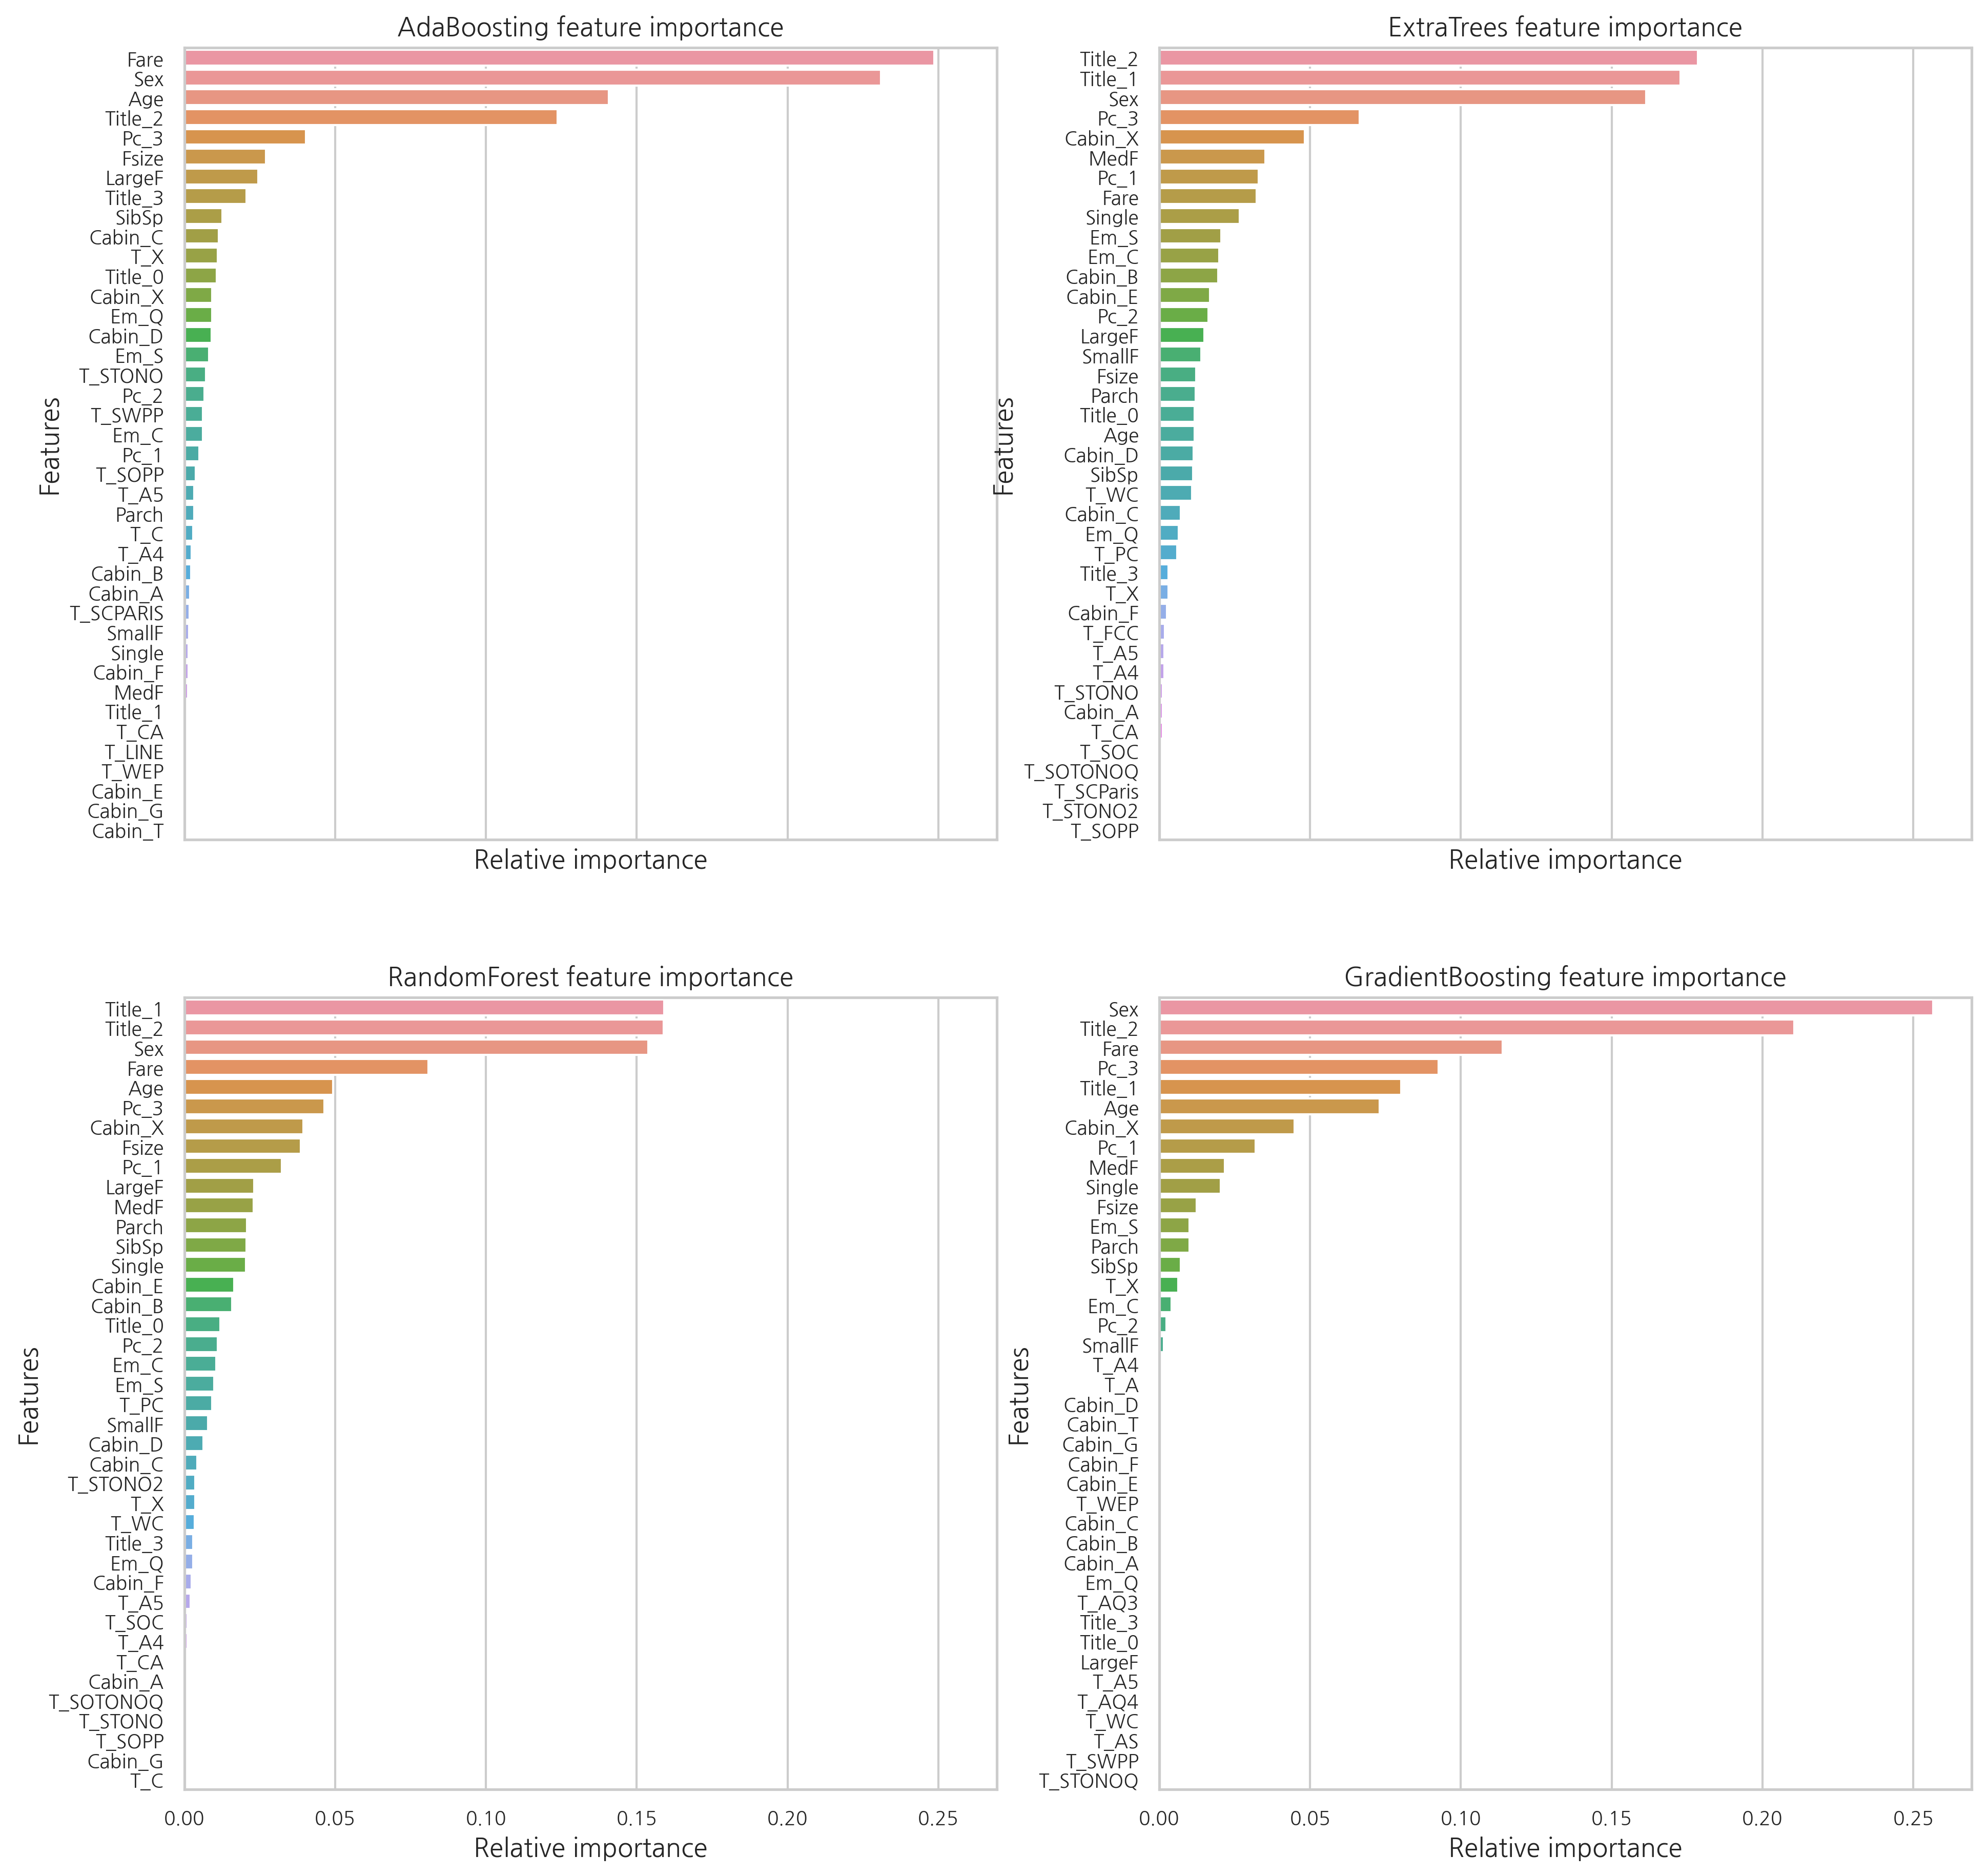

In [93]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", figsize=(15, 15))
names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices], x=classifier.feature_importances_[indices],
                        orient="h", ax=axes[row][col])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

각각의 분류기의 feature 중요도가 다른 것을 확인할 수 있다. 이는 각각의 분류기들이 같은 feature을 기반으로 예측을 하지 않는 것을 의미한다. 하지만 Fare, Title_2, Age, Sex와 같은 feature들은 공통적으로 중요하게 여겨진다.

여성들을 나타내는 Title_2는 Sex와 상관관계가 굉장히 높다.

최종적으로 알 수 있는 점은:

- Pc_1, Pc_2, Pc3와 Fare는 승객들의 일반적인 사회적 지위를 나타낸다고 볼 수 있다.
- Sex와 Title_2, Title_3는 성별을 나타낸다.
- Age와 Title_1은 탑승객들의 나이를 나타낸다.
- Fsize, LargeF, MedF, Single은 탑승객 가족의 수를 나타낸다.

**배 안에서의 위치보다는 나이, 성별, 가족의 수, 사회적 지위가 생존을 예측하는데 있어 더 연관성이 있어 보인다.**

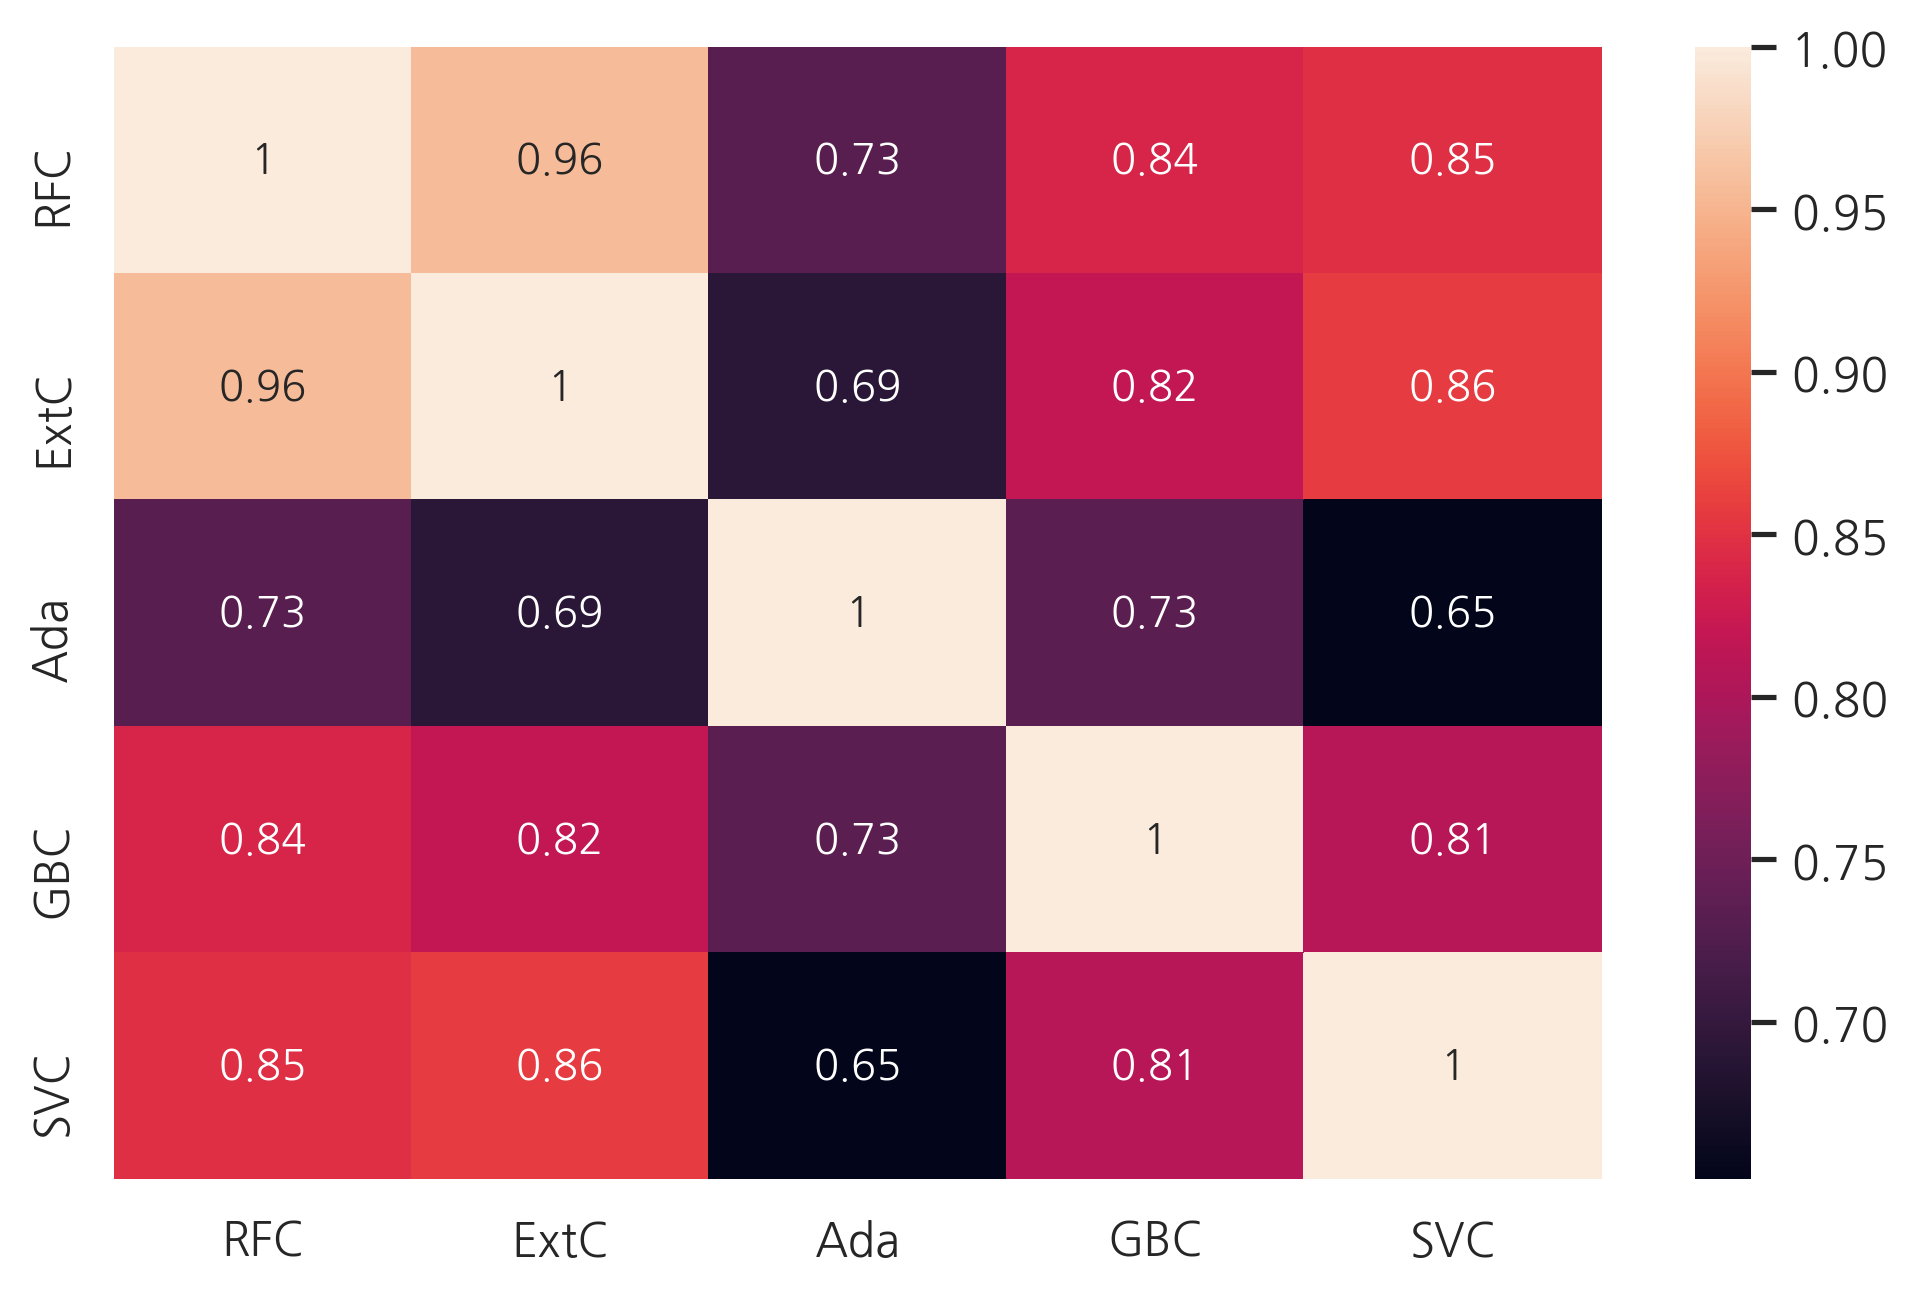

In [95]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# 모든 결과들을 concatenate
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC,
                              test_Survived_GBC, test_Survived_SVMC], axis=1)
g = sns.heatmap(ensemble_results.corr(), annot=True)

예측은 Adaboost를 제외하곤 꽤 비슷해 보입니다. 이 약간의 차이는 ensembling vote를 하는데 괜찮아 보입니다.

### 6.2 Ensemble modeling
#### 6.2.1 Combining models

5개의 분류기를 합치고, soft voting 방식을 사용합니다.

In [96]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), 
                                       ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting="soft", n_jobs=-1)
votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction
#### 6.3.1 Predict and Submit results

In [104]:
test_Survived = pd.Series(votingC.predict(test).astype("int"), name="Survived")
# Survived 칼럼이 float 형식이면 score가 0이 나옴
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv("ensemble_python_voting.csv", index=False)

---------------
# End